# Preparación de los datos

Descarga del conjunto de datos.

la subcarpeta “lunar” que contiene:

- Datos de entrenamiento (en formato miniseed y CSV) para eventos lunares de grado A del Apolo 12, un catálogo sísmico y gráficos.
- Un conjunto de datos de prueba (en formato miniseed y CSV) que utiliza datos de grado A y B de Apollo 12, 15 y 16

La subcarpeta “marte” que contiene:

- Datos de entrenamiento (en formato miniseed y CSV) para dos eventos registrados para InSight, un catálogo sísmico y gráficos.
- Un conjunto de datos de prueba (en formato miniseed y CSV) para los eventos de Mars InSight que ocurrirán entre 2019 y 2022.

In [1]:
!gdown 1SGKjpDrlt35kXwVFdY8lP2f_R2UDdOoD

Downloading...
From (original): https://drive.google.com/uc?id=1SGKjpDrlt35kXwVFdY8lP2f_R2UDdOoD
From (redirected): https://drive.google.com/uc?id=1SGKjpDrlt35kXwVFdY8lP2f_R2UDdOoD&confirm=t&uuid=294795c0-bae5-4f2a-a5ea-93332f9a141a
To: /content/space_apps_2024_seismic_detection.zip
100% 2.26G/2.26G [01:34<00:00, 23.8MB/s]


In [2]:
!unzip space_apps_2024_seismic_detection.zip

Archive:  space_apps_2024_seismic_detection.zip
   creating: space_apps_2024_seismic_detection/
   creating: space_apps_2024_seismic_detection/.ipynb_checkpoints/
  inflating: space_apps_2024_seismic_detection/.ipynb_checkpoints/demo_notebook-checkpoint.ipynb  
   creating: space_apps_2024_seismic_detection/data/
   creating: space_apps_2024_seismic_detection/data/lunar/
   creating: space_apps_2024_seismic_detection/data/lunar/test/
   creating: space_apps_2024_seismic_detection/data/lunar/test/data/
   creating: space_apps_2024_seismic_detection/data/lunar/test/data/S12_GradeB/
  inflating: space_apps_2024_seismic_detection/data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1969-12-16HR00_evid00006.csv  
  inflating: space_apps_2024_seismic_detection/data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed  
  inflating: space_apps_2024_seismic_detection/data/lunar/test/data/S12_GradeB/xa.s12.00.mhz.1970-01-09HR00_evid00007.csv  
  inflating: space_apps_2024_seismic_de

In [3]:
!mv space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR02_evid00029.csv space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR00_evid00029.csv

In [4]:
!pip install obspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.3 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.35
    Uninstalling SQLAlchemy-2.0.35:
      Successfully uninstalled SQLAlchemy-2.0.35
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


# Preprocesamiento de los datos

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import time
import pickle
from itertools import permutations
from obspy.signal.trigger import delayed_sta_lta
from obspy.signal.trigger import classic_sta_lta
from datetime import datetime
from typing import Literal, List, Tuple
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [6]:
MARS_TRAINING_PATH: str = 'space_apps_2024_seismic_detection/data/mars/training/data/'
MARS_CATALOGS_PATH: str = 'space_apps_2024_seismic_detection/data/mars/training/catalogs/'

MARS_TEST_PATH: str = 'space_apps_2024_seismic_detection/data/mars/test/data/'

MARS_TEST_PATH: str = 'space_apps_2024_seismic_detection/data/mars/test/data/'
MARS_CATALOG: str = 'Mars_InSight_training_catalog_final.csv'

# Lunar paths
LUNAR_TRAINING_PATH: str = 'space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA'
LUNAR_CATALOGS_PATH: str = 'space_apps_2024_seismic_detection/data/lunar/training/catalogs'

LUNAR_TEST_PATH: str = 'space_apps_2024_seismic_detection/data/lunar/test/data/S12_GradeB'

LUNAR_CATALOG: str = 'apollo12_catalog_GradeA_final.csv'

In [7]:
class Dataset:
    def __init__(self, catalog_pos: pd.Series, type_: Literal['moon', 'mars']) -> None:
        self.dataset_data = catalog_pos
        self.arrival_time = catalog_pos['time_rel(sec)']  # Este es el valor real del inicio del terremoto
        self.filename = self.dataset_data.filename
        self.type_ = type_

    def get_path(self) -> str:
        base_path = MARS_TRAINING_PATH if self.type_ == 'mars' else LUNAR_TRAINING_PATH
        return os.path.join(base_path, self.filename)

    def get_dataframe(self) -> pd.DataFrame:
        ext: str = '.csv' if self.type_ == 'moon' else ''
        return pd.read_csv(self.get_path() + ext)

    def get_arrival_time(self) -> float:
        return self.arrival_time  # Este valor se utilizará como etiqueta durante el entrenamiento

In [8]:
def plot_data(dataset: Dataset, x_column: str, y_column: str) -> None:
    df: pd.DataFrame = dataset.get_dataframe()

    fig, ax = plt.subplots(1, 1, figsize=(10, 3))

    x_data: np.dnarray = df[x_column].astype(float)
    y_data: np.dnarray = df[y_column].astype(float)

    sns.lineplot(x=x_data, y=y_data, ax=ax)

    ax.set_xlim([x_data.min(), x_data.max()])

    ax.set_ylabel(y_column)
    ax.set_xlabel(x_column)

    ax.set_title(f'{dataset.filename}', fontweight='bold')

    ax.axvline(x=dataset.arrival_time , color='red', label='Rel. Arrival')

    ax.legend()

    plt.show()

## Mars Catalogs

First of all we are going to explore the two unique mars catalogs.

In [9]:
# mars_datasets contiene el listado de los datasets disponible en formato de DataFrame, de los eventos sismicos
mars_catalog: pd.DataFrame = pd.read_csv(os.path.join(MARS_CATALOGS_PATH, MARS_CATALOG))
mars_catalog

filename time_abs(%Y-%m-%dT%H:%M:%S.%f)  \
0  XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.csv     2022-02-03T08:08:27.000000   
1  XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.csv     2022-01-02T04:35:30.000000   

   time_rel(sec)      evid  
0          507.0  evid0005  
1         2130.0  evid0006

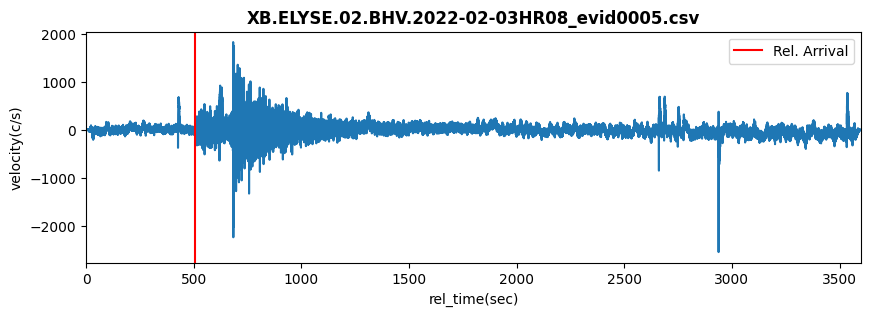

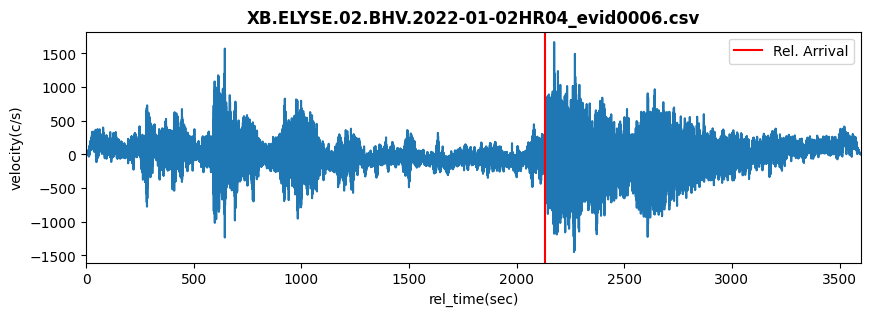

In [10]:
mars_train_dataframes: List[Dataset] = []

for index, rows in mars_catalog.iterrows():
  mars_dataset_n = Dataset(catalog_pos=rows, type_='mars')
  mars_train_dataframes.append(mars_dataset_n)

  plot_data(dataset=mars_dataset_n, x_column='rel_time(sec)', y_column='velocity(c/s)')

## Moon Catalogs

We do the same for the lunar catalogs.

In [11]:
lunar_catalog: pd.DataFrame = pd.read_csv(os.path.join(LUNAR_CATALOGS_PATH, LUNAR_CATALOG))
lunar_catalog.head(5)

filename time_abs(%Y-%m-%dT%H:%M:%S.%f)  \
0  xa.s12.00.mhz.1970-01-19HR00_evid00002     1970-01-19T20:25:00.000000   
1  xa.s12.00.mhz.1970-03-25HR00_evid00003     1970-03-25T03:32:00.000000   
2  xa.s12.00.mhz.1970-03-26HR00_evid00004     1970-03-26T20:17:00.000000   
3  xa.s12.00.mhz.1970-04-25HR00_evid00006     1970-04-25T01:14:00.000000   
4  xa.s12.00.mhz.1970-04-26HR00_evid00007     1970-04-26T14:29:00.000000   

   time_rel(sec)       evid    mq_type  
0        73500.0  evid00002  impact_mq  
1        12720.0  evid00003  impact_mq  
2        73020.0  evid00004  impact_mq  
3         4440.0  evid00006  impact_mq  
4        52140.0  evid00007    deep_mq

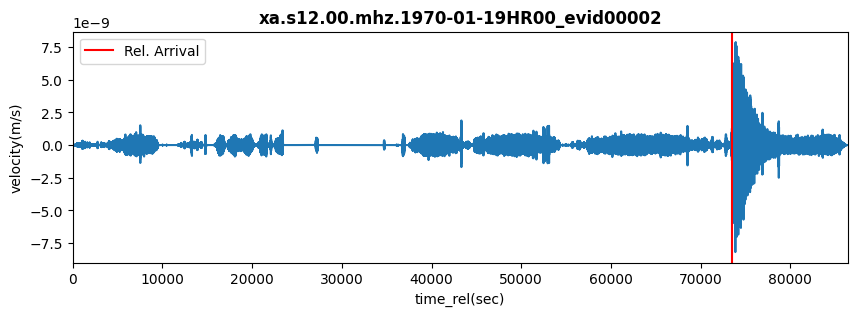

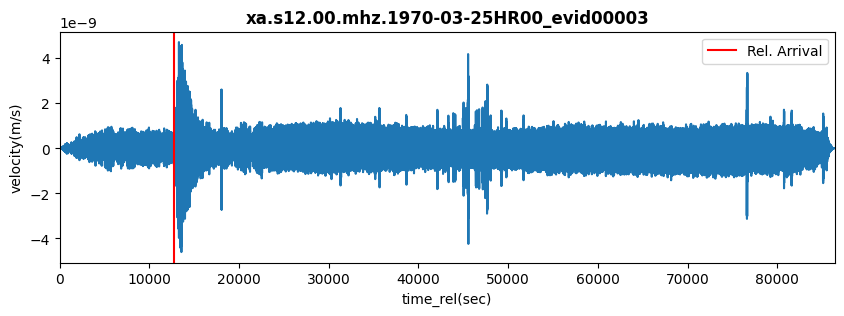

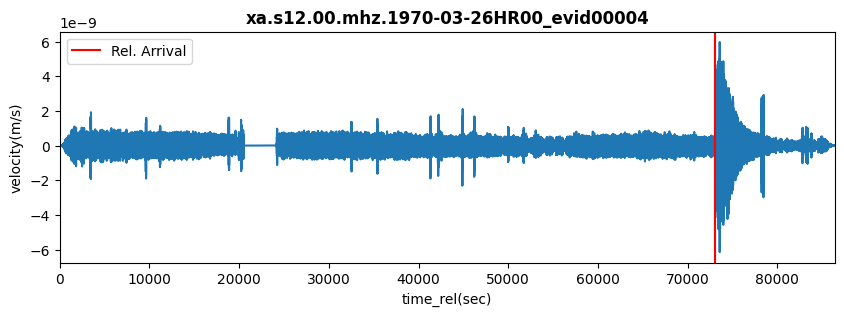

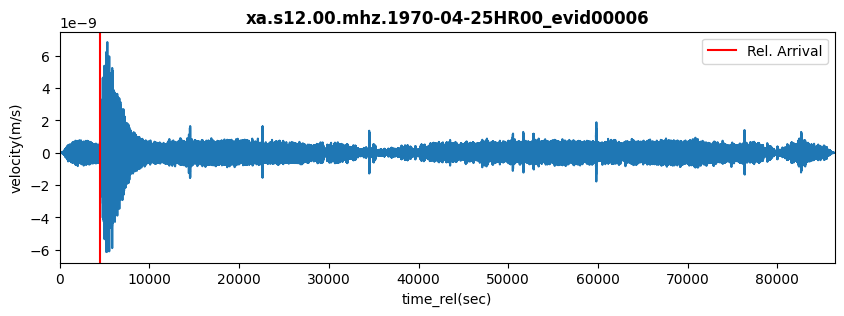

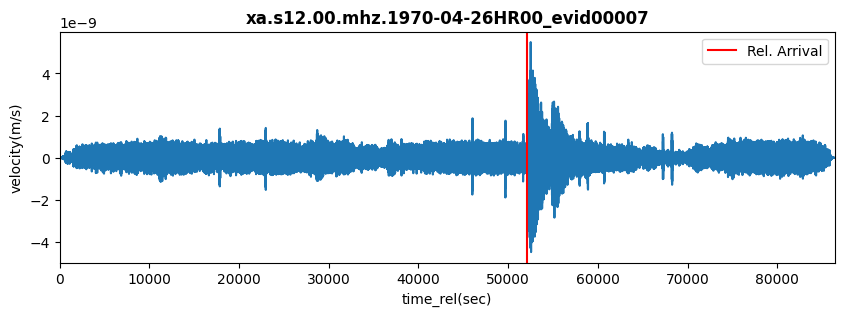

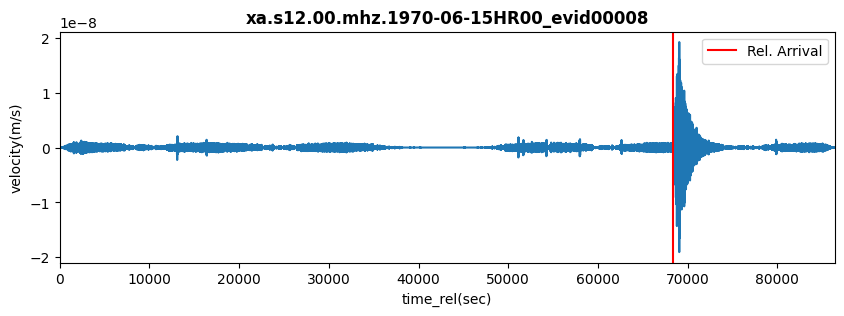

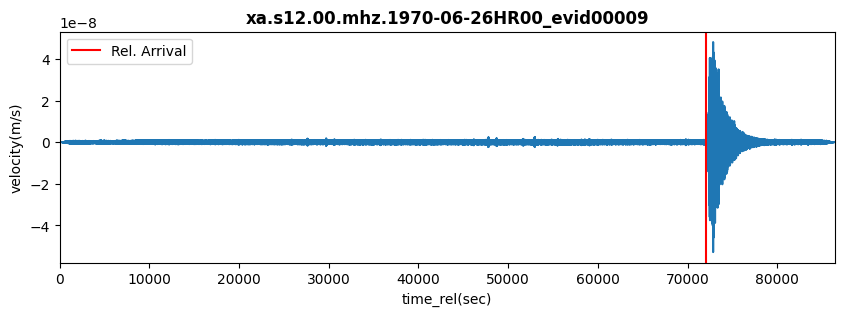

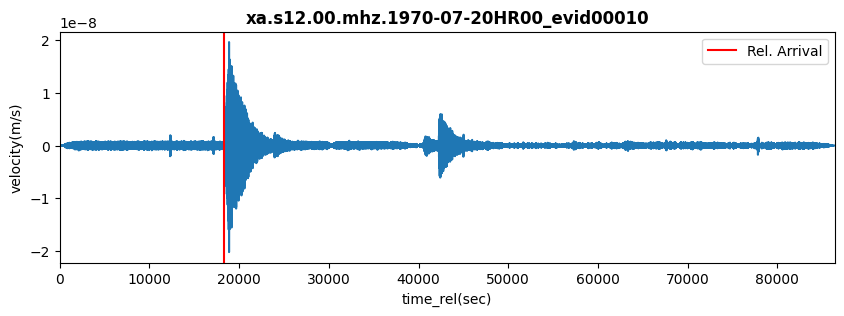

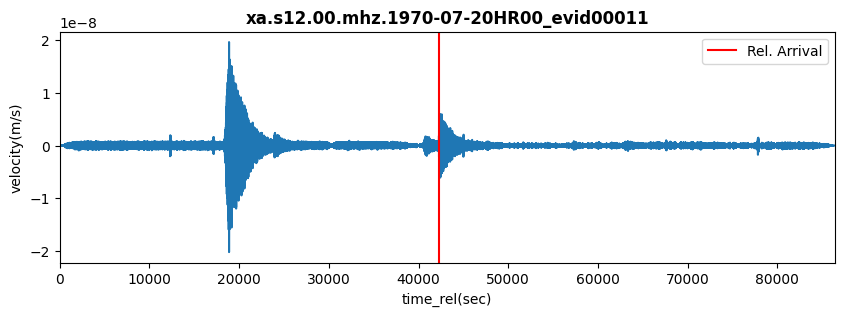

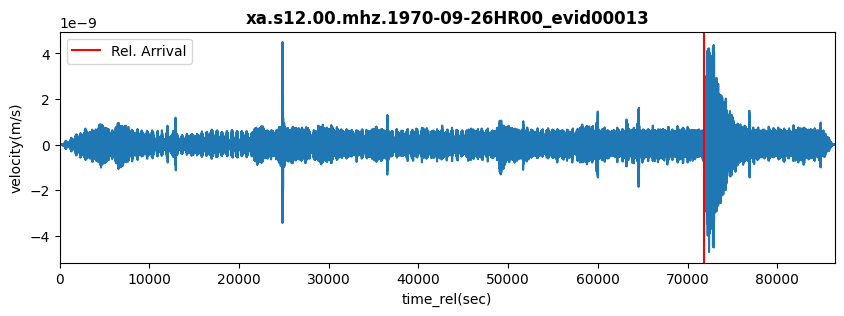

In [12]:
lunar_train_dataframes: List[pd.DataFrame] = []
cnt: int = 0

for index, rows in lunar_catalog.iterrows():
  lunar_dataset_n = Dataset(catalog_pos=rows, type_='moon')
  lunar_train_dataframes.append(lunar_dataset_n)

  if cnt < 10:
    plot_data(dataset=lunar_dataset_n, x_column='time_rel(sec)', y_column='velocity(m/s)')
    cnt += 1

## Test data load

In [13]:
mars_test_dataframes: List[pd.DataFrame] = []
moon_test_dataframes: List[pd.DataFrame] = []

for file in os.listdir(MARS_TEST_PATH):
  if file.endswith('.csv'):
    mars_test_dataframes.append(pd.read_csv(os.path.join(MARS_TEST_PATH, file)))

for file in os.listdir(LUNAR_TEST_PATH):
  if file.endswith('.csv'):
    moon_test_dataframes.append(pd.read_csv(os.path.join(LUNAR_TEST_PATH, file)))

## Entrenamiento **LSTM**

In [ ]:
def preprocess_data(datasets: List[Dataset], sequence_length: int = 100) -> Tuple[np.ndarray, np.ndarray, MinMaxScaler]:
    """
    Preprocesa los datos de cada dataset y utiliza 'arrival_time' como etiqueta.
    """
    X, y = [], []

    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    for dataset in datasets:
        df = dataset.get_dataframe()
        arrival_time = dataset.get_arrival_time()

        velocity_col = 'velocity(m/s)' if dataset.type_ == 'moon' else 'velocity(c/s)'

        velocity_scaled = scaler_X.fit_transform(df[[velocity_col]].values)

        arrival_time_scaled = scaler_y.fit_transform(np.array([[arrival_time]]))  # Escalar el arrival_time

        for i in range(sequence_length, len(velocity_scaled)):
            X.append(velocity_scaled[i-sequence_length:i, 0])  # Secuencia de velocidad
            y.append(arrival_time_scaled[0, 0])  # Misma etiqueta para todas las secuencias

    X = np.array(X)
    y = np.array(y)

    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Redimensionar para LSTM

    return X, y, scaler_y

In [ ]:
def preprocess_test_data(dataframe: pd.DataFrame, sequence_length: int = 100, type_: Literal['moon', 'mars'] = 'mars') -> Tuple[np.ndarray, MinMaxScaler]:
    """
    Preprocesa los datos de prueba a partir de un DataFrame y devuelve solo las secuencias de entrada X.
    """
    X_test = []

    scaler_X = MinMaxScaler(feature_range=(0, 1))  # Escalador para las secuencias de velocidad

    velocity_col = 'velocity(m/s)' if type_ == 'moon' else 'velocity(c/s)'

    velocity_scaled = scaler_X.fit_transform(dataframe[[velocity_col]].values)

    for i in range(sequence_length, len(velocity_scaled)):
        X_test.append(velocity_scaled[i-sequence_length:i, 0])  # Secuencia de velocidad

    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_test, scaler_X


In [ ]:
def create_lstm_model(input_shape: Tuple[int, int], dropout_rate: float = 0.3) -> Sequential:
    """
    Crea un modelo LSTM para predecir el tiempo de llegada del terremoto.
    """
    model = Sequential()

    model.add(LSTM(units=200, return_sequences=True,
                   kernel_regularizer=l2(0.001),
                   input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units=150, return_sequences=True,
                   kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units=100, return_sequences=True,
                   kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units=50, return_sequences=False,
                   kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(units=100, activation='relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(units=50, activation='relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(units=1))  # Predicción de un solo valor (tiempo de llegada)

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model

In [ ]:
def train_model(model: Sequential, X_train: np.ndarray, y_train: np.ndarray, model_name: str, epochs: int = 50, batch_size: int = 32, patience: int = 5):
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.2,
                        callbacks=[early_stopping])

    model.save(f'{model_name}.h5')

    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Pérdida durante el entrenamiento')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [ ]:
def load_trained_model(model_path: str) -> Sequential:
    """
    Carga un modelo entrenado desde un archivo .h5.
    """
    try:
        model = load_model(model_path)
        print(f'Modelo cargado exitosamente desde: {model_path}')
        return model
    except Exception as e:
        print(f'Error al cargar el modelo: {e}')
        return None


In [ ]:
def test_model(model: Sequential, X_test: np.ndarray, scaler: MinMaxScaler) -> np.ndarray:
    """
    Realiza predicciones del tiempo de llegada utilizando el modelo entrenado
    y devuelve las predicciones escaladas inversamente.
    """
    single_prediction = model.predict(X_test)

    single_prediction = scaler.inverse_transform(single_prediction)

    X_test_rescaled = scaler.inverse_transform(X_test.reshape(X_test.shape[0], X_test.shape[1]))

    plt.figure(figsize=(12, 6))

    plt.plot(X_test_rescaled.flatten(), color='blue', alpha=0.5, label='Sismic Data')  # Aplanar para graficar toda la secuencia

    prediction_index = X_test.shape[1] - 1  # Índice de la predicción
    plt.axvline(x=prediction_index, color='red', linestyle='--',
                label='Predicted Arrival Time (inverted) = {:.4f} sec'.format(single_prediction[0][0]))

    plt.title('Arrival Time Prediction vs Sismic Data')
    plt.xlabel('Time Steps')
    plt.ylabel('Sismic Data Value')
    plt.legend()
    plt.show()

    return single_prediction

In [ ]:
def predict(model: Sequential, dataset: pd.DataFrame, type_: Literal['moon', 'mars']) -> float:
    """
    Realiza predicciones del tiempo de llegada utilizando el modelo dado y un DataFrame de prueba.
    """
    X_test, test_scaler = preprocess_test_data(dataset, sequence_length=100, type_=type_)

    val = test_model(model, X_test, test_scaler)

    return val[0][0]  # Devolver el primer valor predicho (tiempo de llegada)


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

Num GPUs Available:  1
Found GPU at: /device:GPU:0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 143s 26ms/step - loss: 0.3345 - mae: 0.0860 - val_loss: 0.0061 - val_mae: 3.8698e-05
Epoch 2/50
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 141s 26ms/step - loss: 0.0028 - mae: 0.0014 - val_loss: 5.4792e-05 - val_mae: 6.3051e-07
Epoch 3/50
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 141s 26ms/step - loss: 2.1260e-05 - mae: 3.9859e-07 - val_loss: 7.2420e-09 - val_mae: 1.9787e-07
Epoch 4/50
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 142s 26ms/step - loss: 1.5873e-09 - mae: 2.3229e-07 - val_loss: 3.9303e-14 - val_mae: 1.9825e-07
Epoch 5/50
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 93s 26ms/step - loss: 2.4441e-10 - mae: 5.8687e-06 - val_loss: 1.4474e-10 - val_mae: 1.2031e-05
Epoch 6/50
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 144s 26ms/step - loss: 7.7255e-10 - mae: 1.6535e-05 - val_loss: 4.1208e-10 - val_mae: 2.0299e-05
Epoch 7/50
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 141s 26ms/step - loss: 9.3447e-10 - mae: 1.8373e-05 - val_loss: 9.4688e-12 - val_mae: 3.0771e-06
Epoch 8/50
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 140s 2

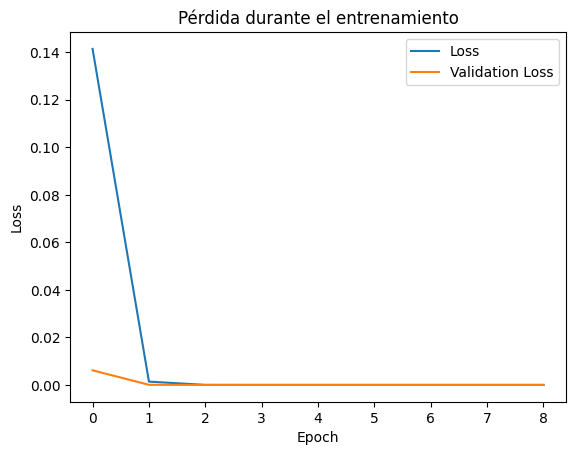

In [ ]:
X_train, y_train, scaler = preprocess_data(mars_train_dataframes)

input_shape = (X_train.shape[1], X_train.shape[2])
model = create_lstm_model(input_shape)

train_model(model,
            X_train,
            y_train,
            model_name = 'mars_1',
            epochs = 50,
            batch_size = 32)

In [ ]:
model = load_trained_model('mars_1.h5')

Modelo cargado exitosamente desde: mars_1.h5


2247/2247 ━━━━━━━━━━━━━━━━━━━━ 429s 190ms/step


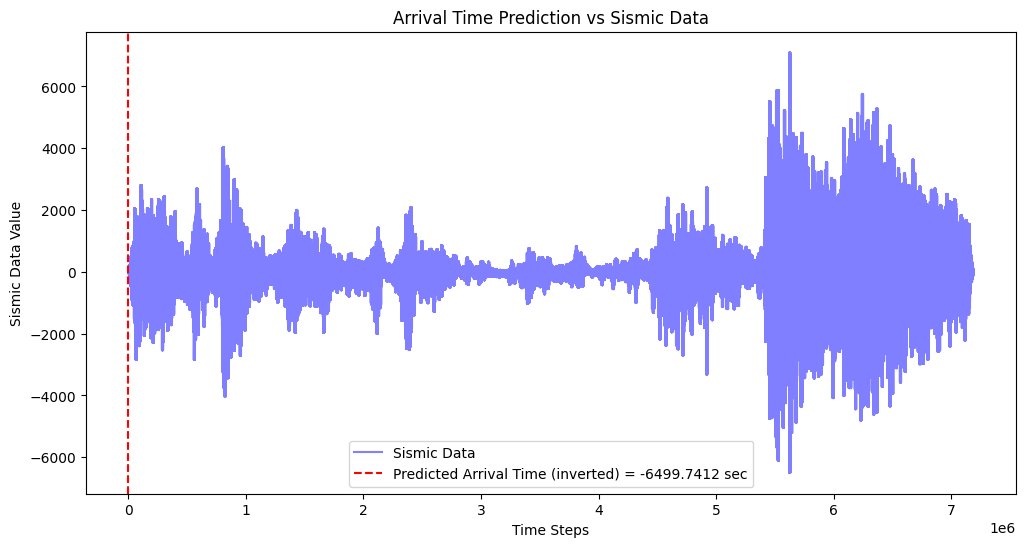

In [ ]:
for i in range(1):
  predict(model, mars_test_dataframes[i], 'mars')

2247/2247 ━━━━━━━━━━━━━━━━━━━━ 431s 192ms/step


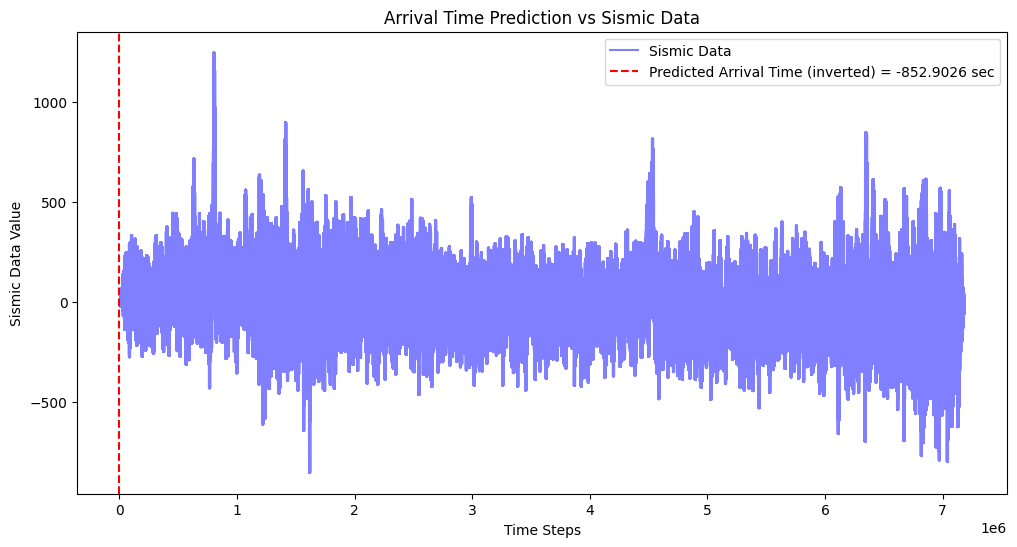

In [ ]:
val = predict(model, mars_test_dataframes[3], 'mars')

# Entrenamiento **LTA/STA**

In [14]:
def sta_lta(signal: np.ndarray, sta_window: float, lta_window: float) -> Tuple[float, int]:
    sta: np.ndarray = np.convolve(signal, np.ones(sta_window) / sta_window, mode='valid')
    lta: np.ndarray = np.convolve(signal, np.ones(lta_window) / lta_window, mode='valid')

    lta = lta[:len(sta)]

    lta[lta == 0] = 1e-10

    idx: int = np.argmax(sta / lta)

    return sta / lta, idx

In [15]:
class StaLtaParams:
  def __init__(self,
               sta_window: float, lta_window: float) -> None:
    self.sta_window = sta_window
    self.lta_window = lta_window

In [16]:
from uuid import uuid4

def get_arrival_time(dataset: pd.DataFrame, type_: Literal['moon', 'mars'], params: StaLtaParams, **kwars) -> Tuple[float, int]:
  col_name: str = 'velocity(m/s)' if type_ == 'moon' else 'velocity(c/s)'
  X: pd.Series = dataset[col_name]
  factor: int = 1e-8 if type_ == 'moon' else 1000
  error: float = 0
  min_window: int = 15000 if type_ == 'moon' else 1000

  sta_arr: np.ndarray = delayed_sta_lta(a=np.array(X),
                         nsta=params.sta_window,
                         nlta=params.lta_window)

  idx: float = np.argmax(sta_arr)

  max_: int = np.argmin(sta_arr[idx:]) + len(sta_arr[0:idx])
  min_: int = len(sta_arr[0:idx-min_window])

  if 'plot' in kwars.keys():
    plot = kwars['plot']
  else:
    plot = True

  if 'save' in kwars.keys():
    save = kwars['save']
  else:
    save = False

  if not plot:
    return sta_arr, idx, min_, max_, error

  _, axs = plt.subplots(1, 2, layout='constrained', sharex=True, sharey=True, figsize=(15, 5))

  ax0_legend: List[str] = ['Seismic Data', 'Detection', 'Start', 'End']

  axs[0].set_title('Sismic Data')

  axs[0].plot(X, c='blue')

  # Evaluar seriamente esta línea
  #idx = np.argmax(np.array(X))

  axs[0].axvline(x=idx, linestyle="-", color='r')

  axs[0].axvline(x=max_, linestyle=":", color='r')

  axs[0].axvline(x=min_, linestyle=":", color='r')

  axs[0].set_ylabel(col_name)
  axs[0].set_xlabel('Time (seconds)')
  # np.argmin(sta_arr[idx-10000:idx]) + len(sta_arr[0:idx])

  if 'real_arrival_time' in kwars.keys():
    axs[0].axvline(x=kwars['real_arrival_time'], linestyle="--", color='yellow')
    ax0_legend.append('Seismic Arrival')

    error = abs(idx - kwars['real_arrival_time'])

  axs[0].legend(ax0_legend)

  axs[1].set_title('LTA/STA')

  axs[1].plot(sta_arr*factor, c='green')

  axs[1].legend(['LTA/STA'])

  axs[1].set_ylabel('Local AVG')
  axs[1].set_xlabel('Time (seconds)')

  if save and type_ == 'mars':
    plt.savefig(f'mars_plots/{str(uuid4())}.png')
  elif save and type_ == 'moon':
    plt.savefig(f'moon_plots/{str(uuid4())}.png')

  plt.show()

  return sta_arr, idx, min_, max_, error

## Mars Tests

We evaluate the model for the training dataset, calculating the error in seconds.

In [17]:
!mkdir mars_plots

In [18]:
predictions: List[dict[str, pd.DataFrame]] = []

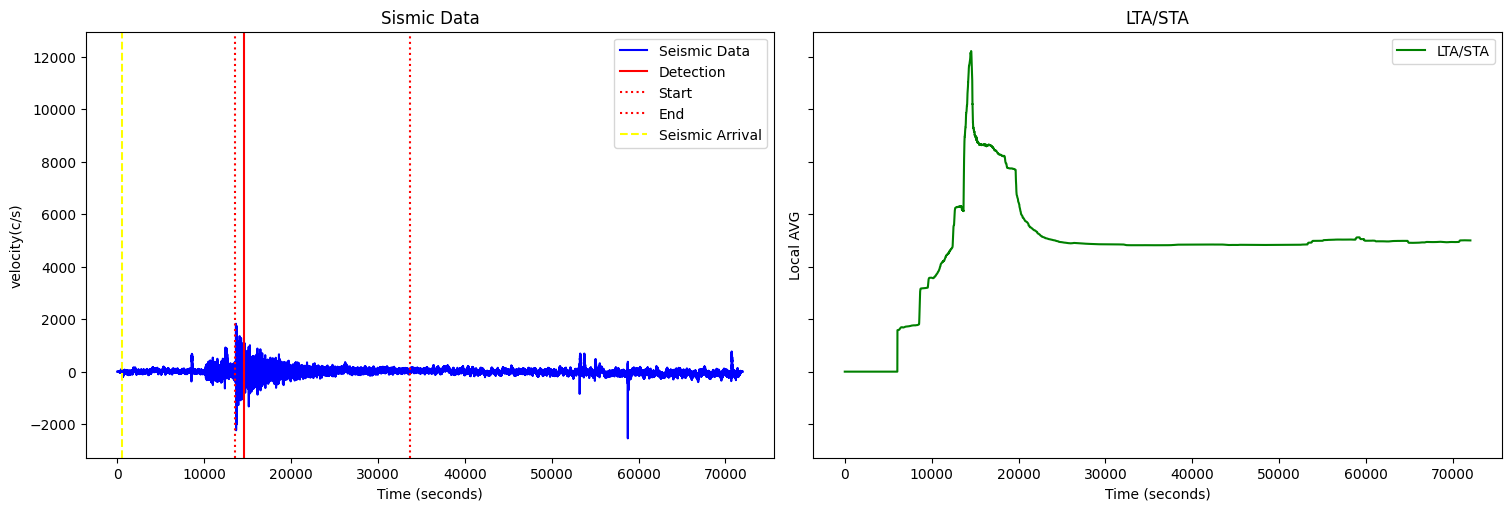

Time Elapsed: 1.0220839977264404 with error: 14038.0 segs.


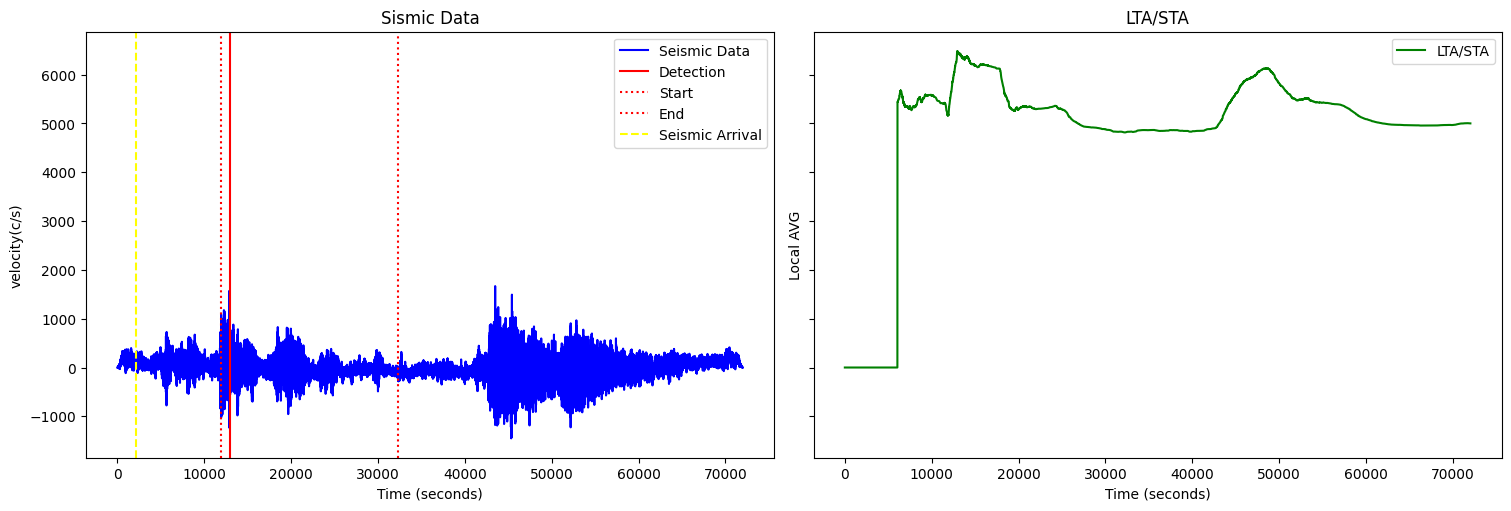

Time Elapsed: 1.0792279243469238 with error: 10809.0 segs.


In [20]:
params = StaLtaParams(sta_window=1000, lta_window=5000)
mars_errors: List[float] = []

for df in mars_train_dataframes:
  now = time.time()
  arr, idx, min_, max_, error = get_arrival_time(dataset=df.get_dataframe(),
                   type_='mars',
                   params=params,
                   real_arrival_time=df.get_arrival_time(),
                   save=False)

  pred = {
      'dataset': df,
      'arrival_time': df.get_arrival_time(),
      'prediction': idx,
      'min_' : min_,
      'max_': max_,
      'error': error,
      "filename" : df.get_path(),
      'type': 'mars',
  }

  predictions.append(pred)

  mars_errors.append(error)

  print(f'Time Elapsed: {time.time() - now} with error: {error} segs.')

In [ ]:
!mkdir moon_plots

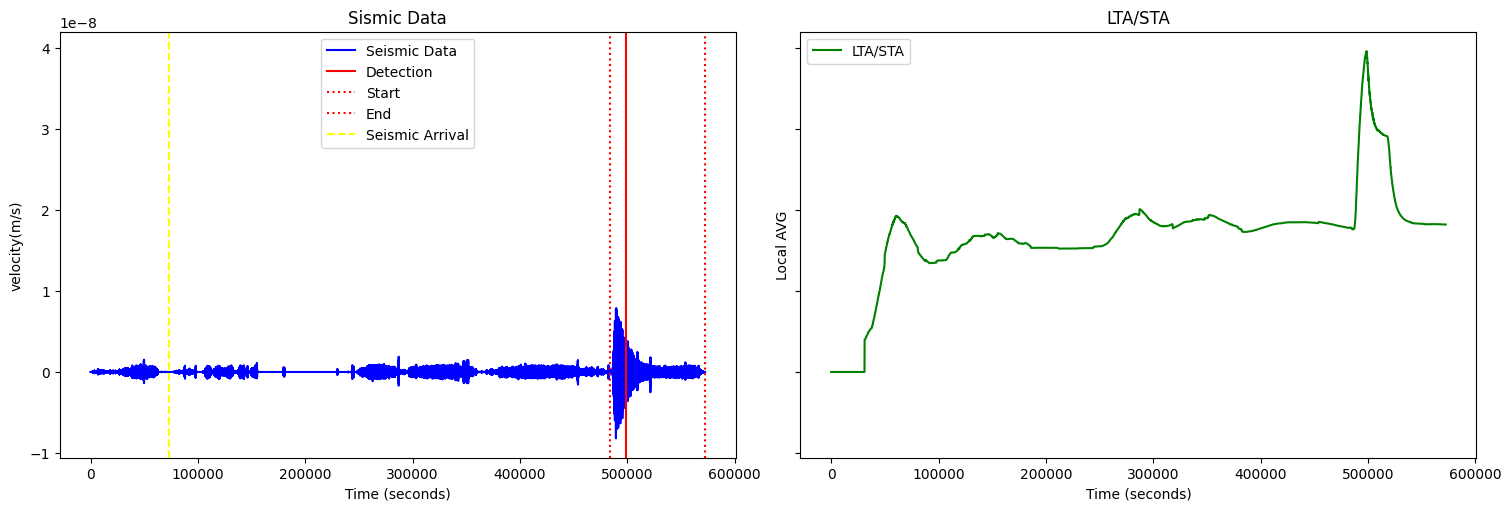

Processed: 1/76
Elapsed: 7.201524019241333 with error: 425094.0 segs.


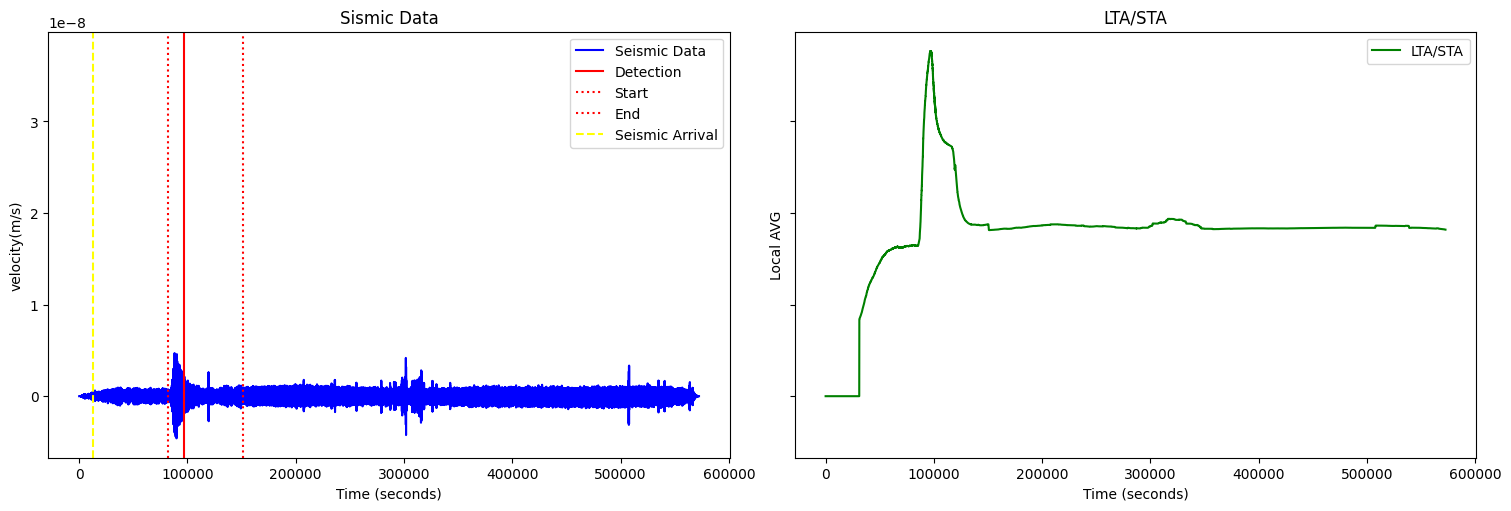

Processed: 2/76
Elapsed: 3.727022171020508 with error: 84180.0 segs.


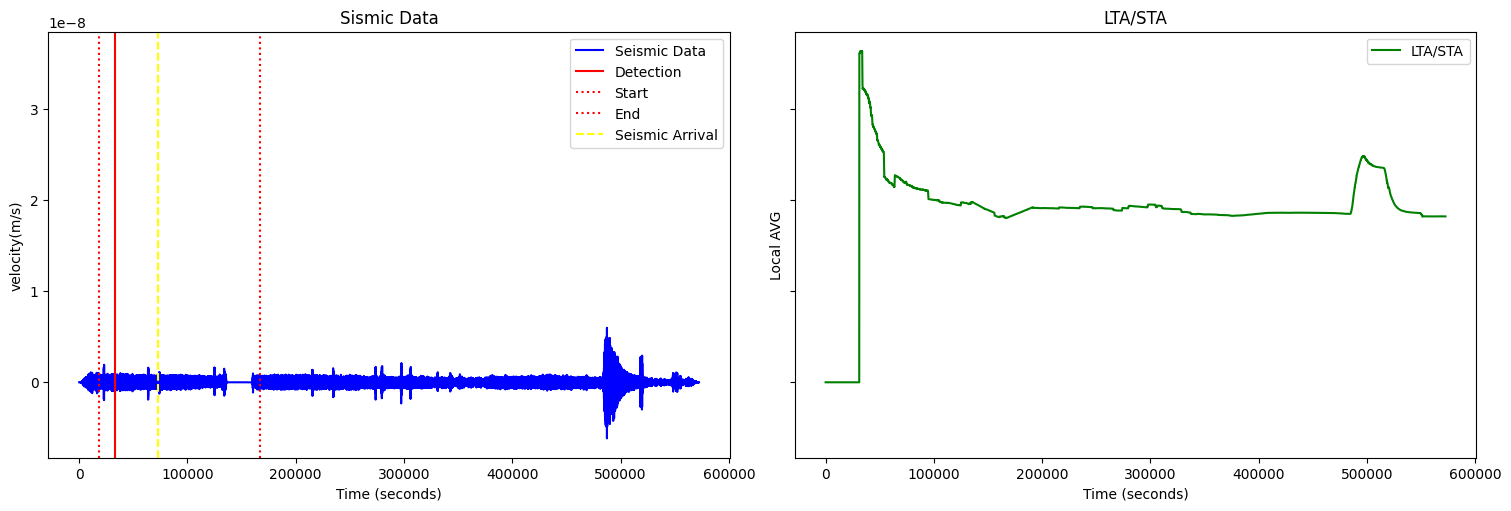

Processed: 3/76
Elapsed: 4.094441890716553 with error: 39957.0 segs.


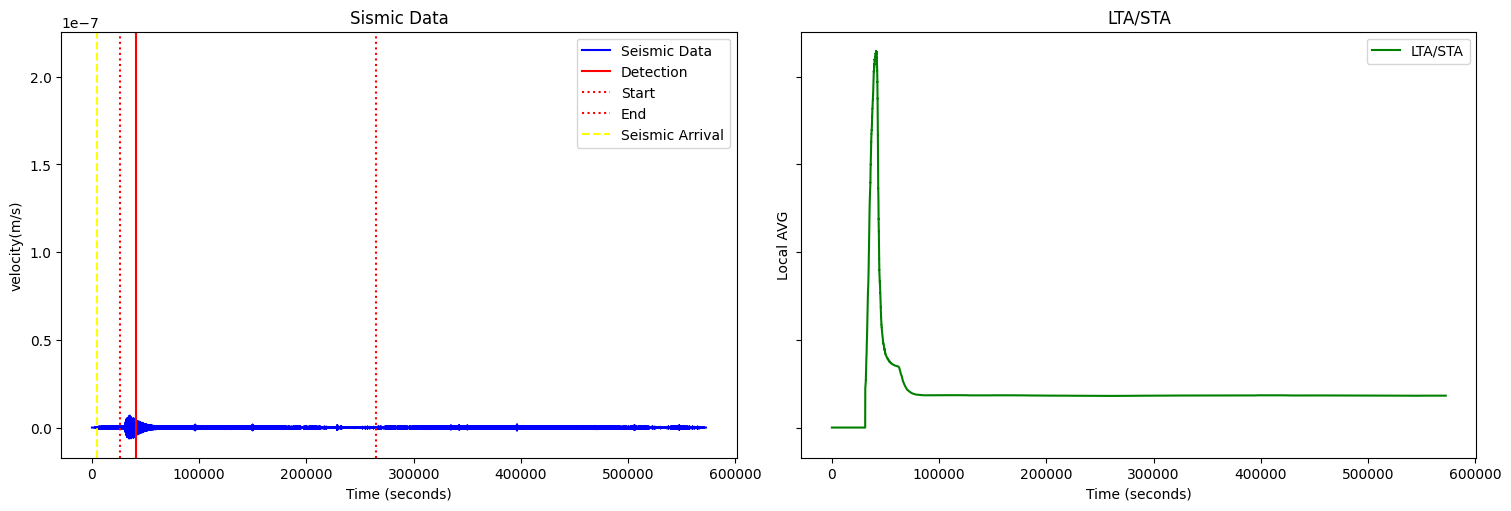

Processed: 4/76
Elapsed: 4.695087671279907 with error: 36754.0 segs.


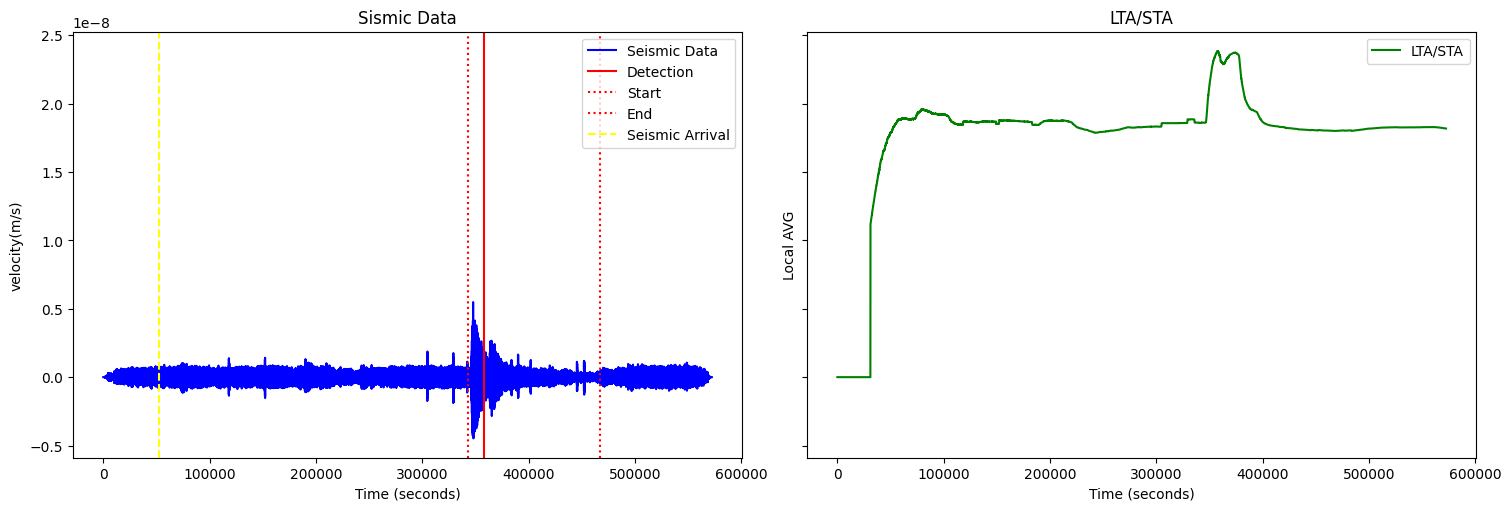

Processed: 5/76
Elapsed: 5.920199632644653 with error: 305568.0 segs.


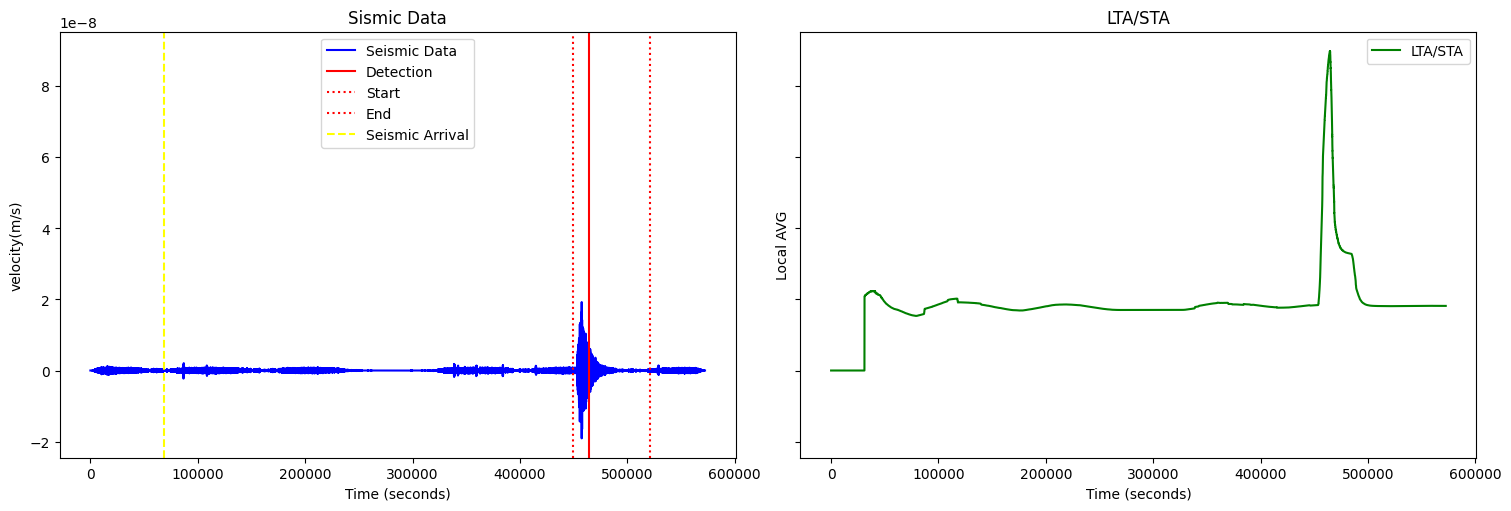

Processed: 6/76
Elapsed: 7.1258461475372314 with error: 396184.0 segs.


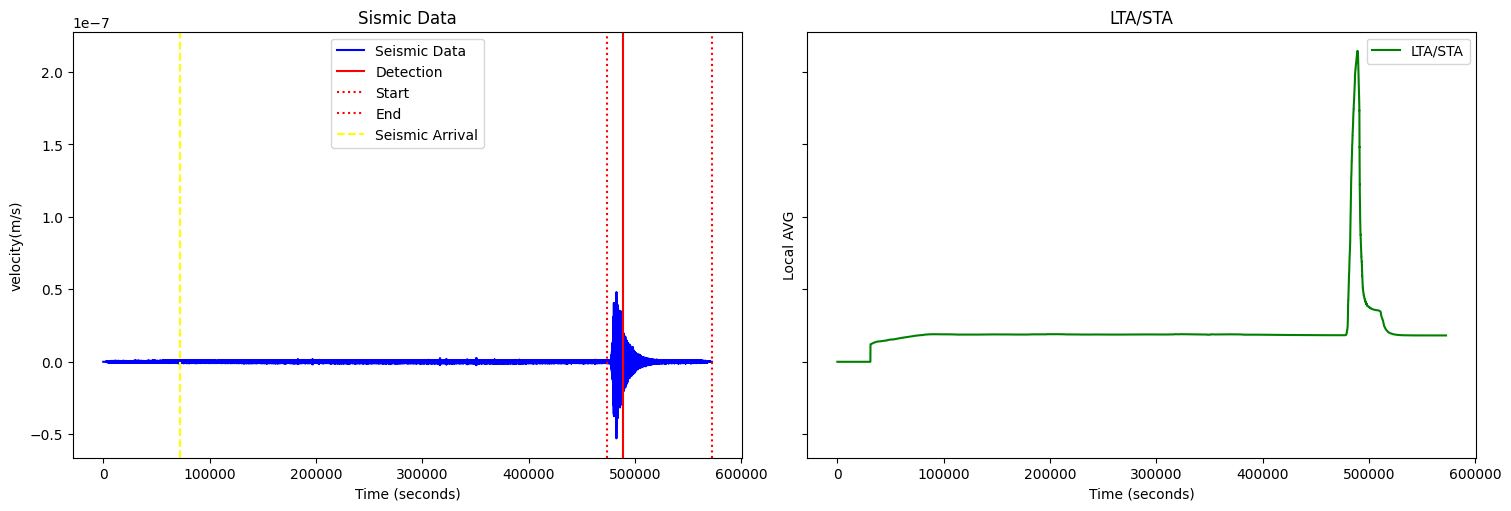

Processed: 7/76
Elapsed: 5.568561553955078 with error: 417127.0 segs.


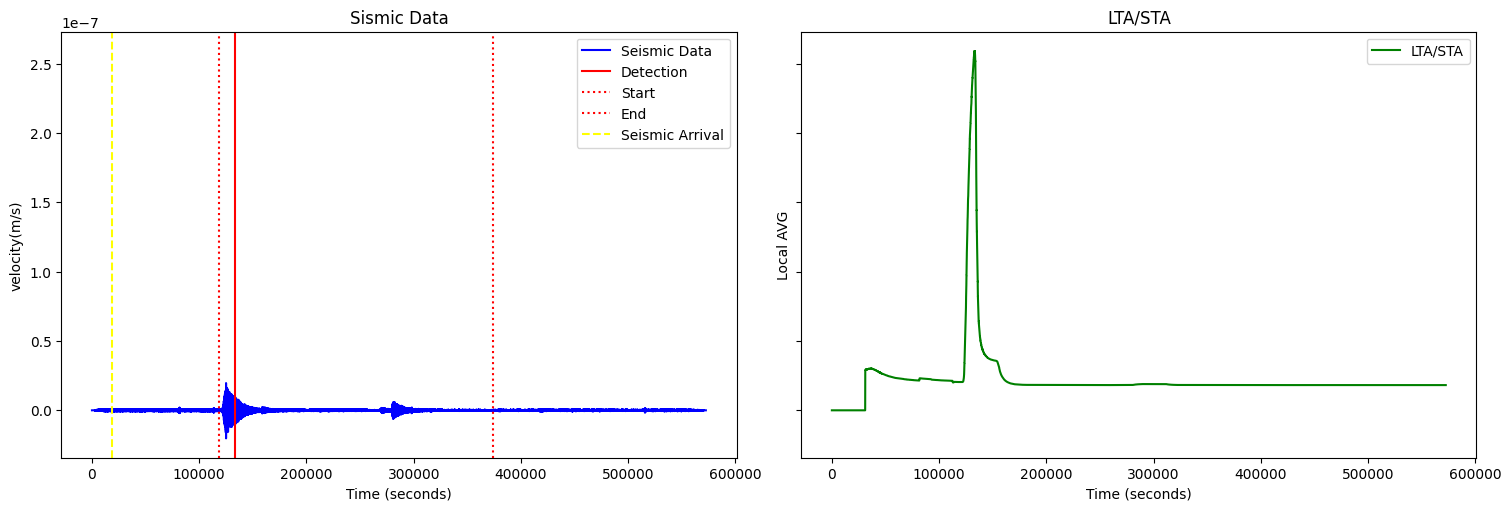

Processed: 8/76
Elapsed: 4.768103122711182 with error: 114633.0 segs.


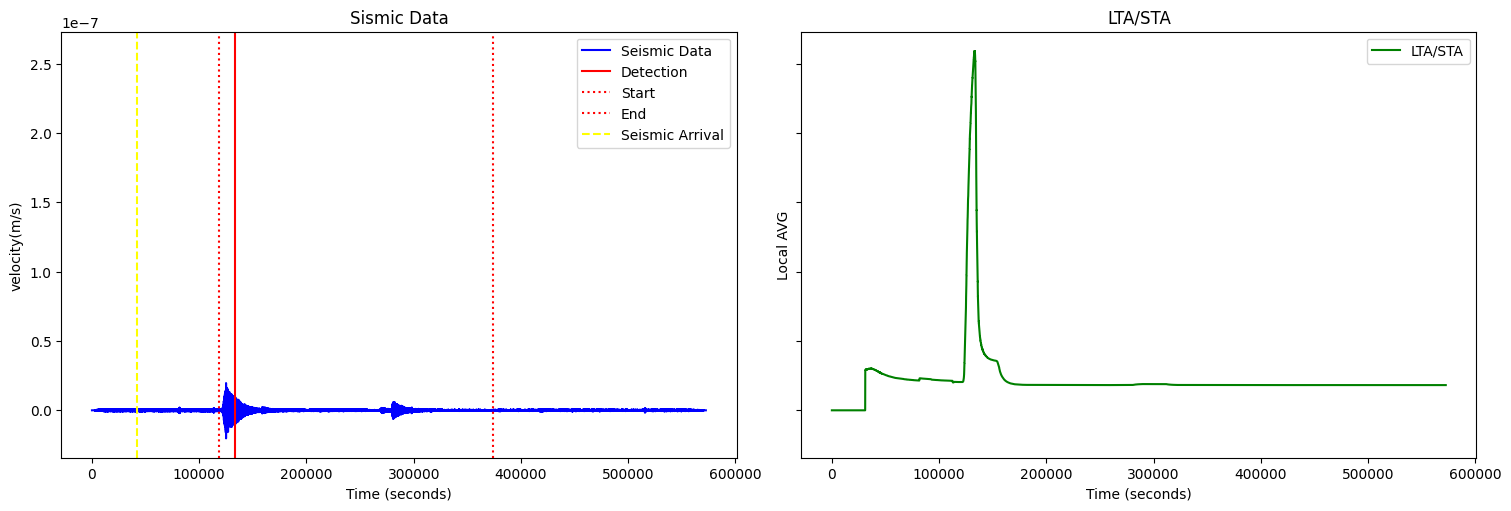

Processed: 9/76
Elapsed: 7.269891738891602 with error: 90753.0 segs.


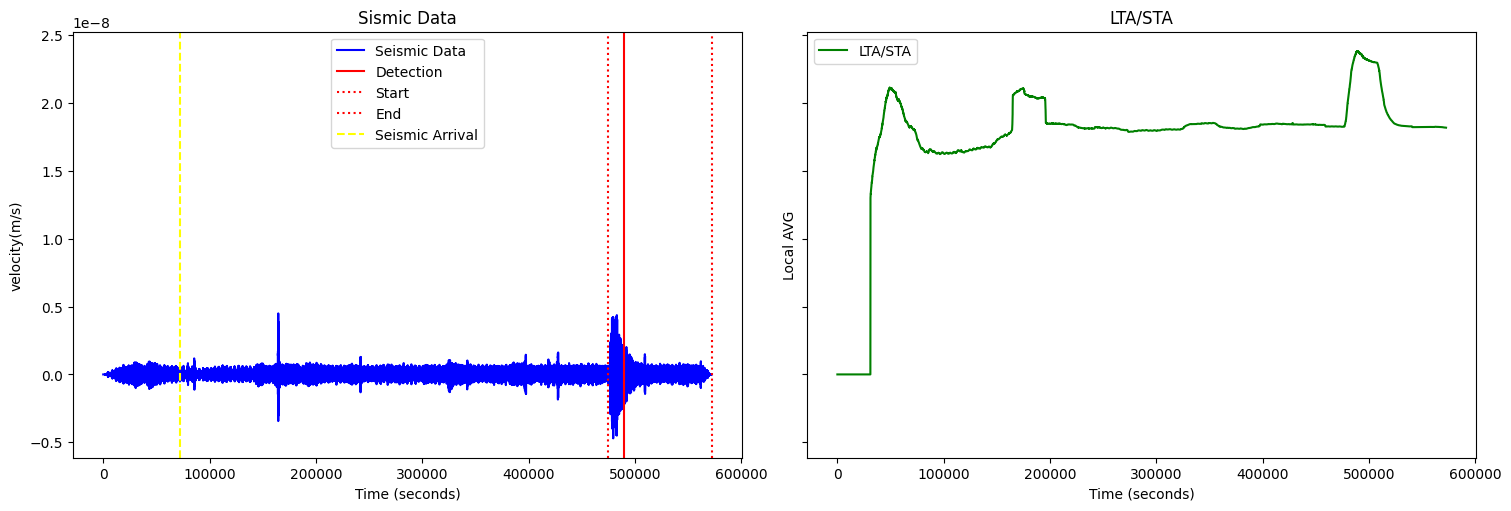

Processed: 10/76
Elapsed: 12.030778646469116 with error: 417595.0 segs.


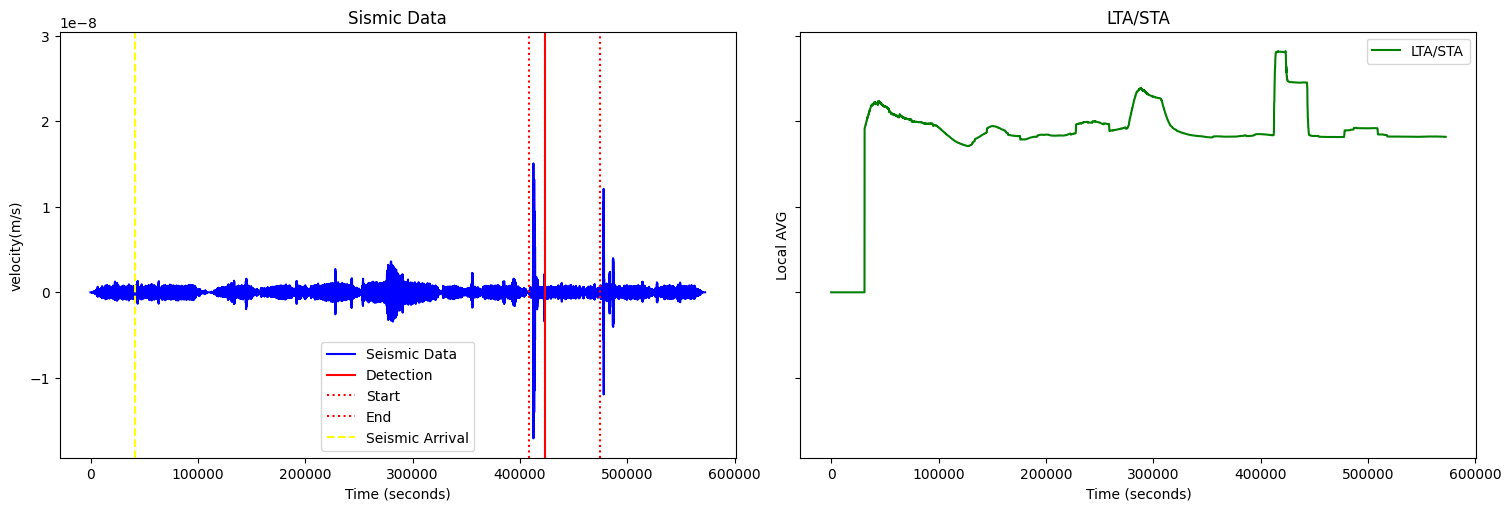

Processed: 11/76
Elapsed: 5.39057993888855 with error: 381680.0 segs.


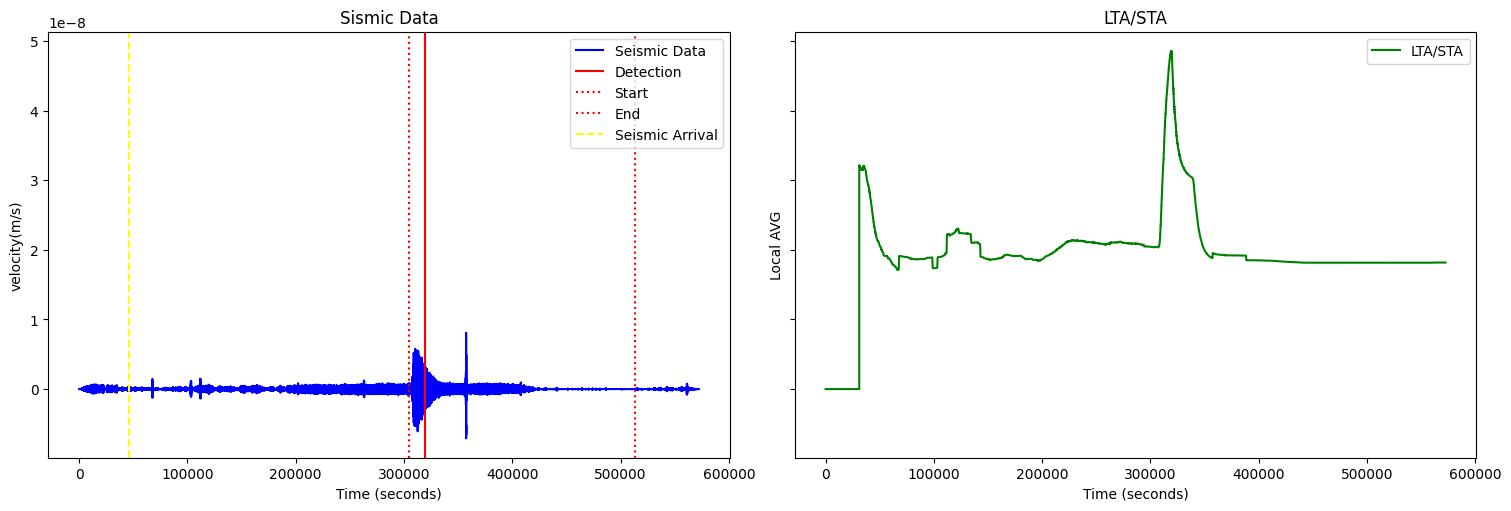

Processed: 12/76
Elapsed: 7.255090713500977 with error: 273062.0 segs.


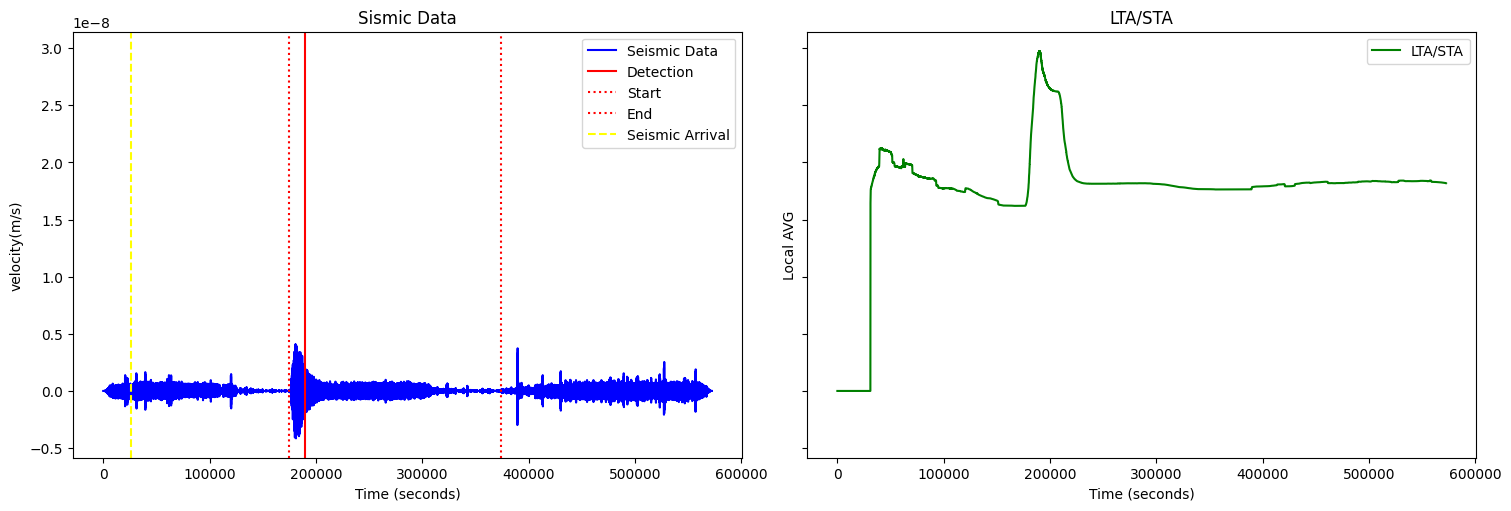

Processed: 13/76
Elapsed: 3.7401010990142822 with error: 163375.0 segs.


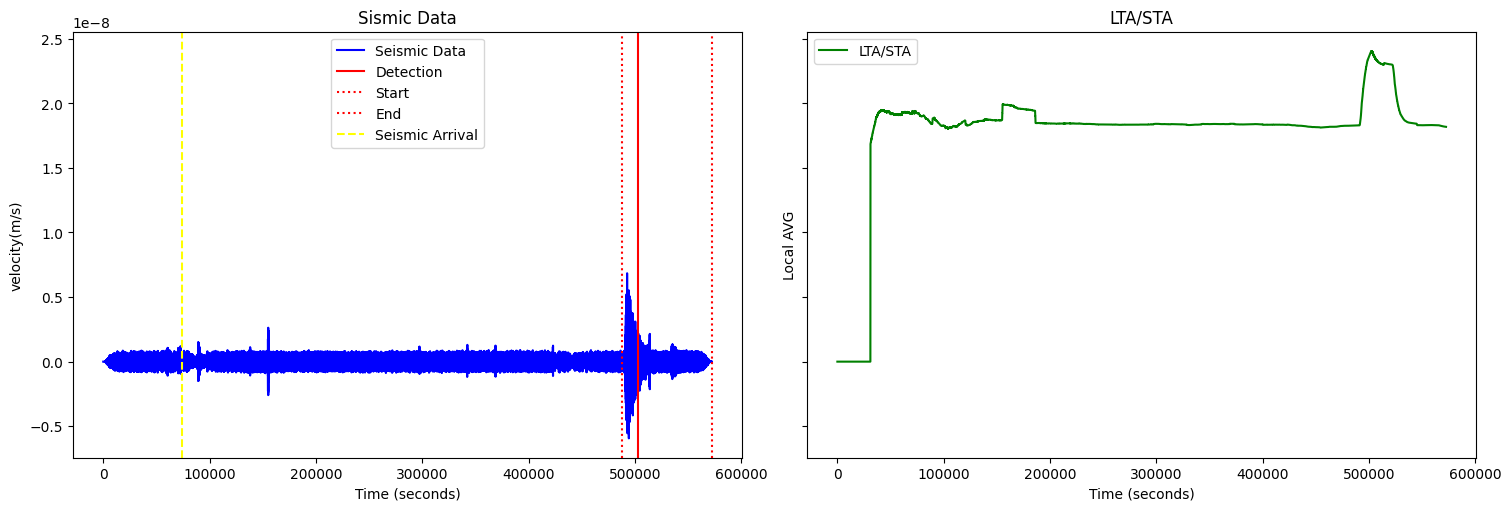

Processed: 14/76
Elapsed: 7.992517948150635 with error: 428489.0 segs.


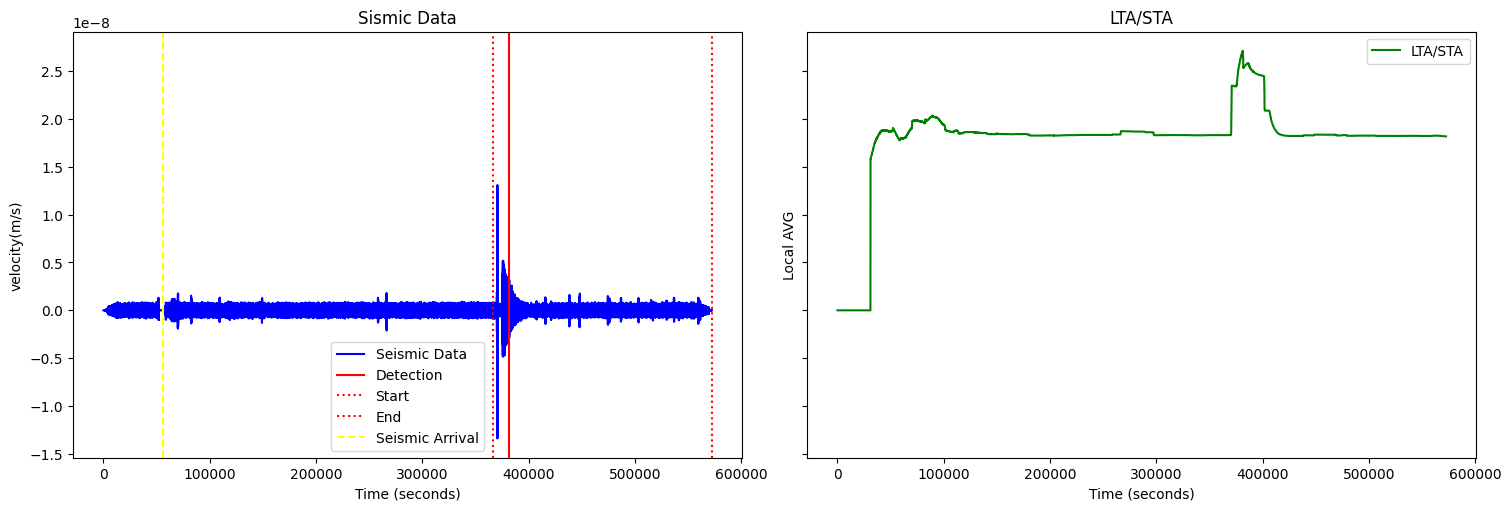

Processed: 15/76
Elapsed: 5.576807737350464 with error: 324850.0 segs.


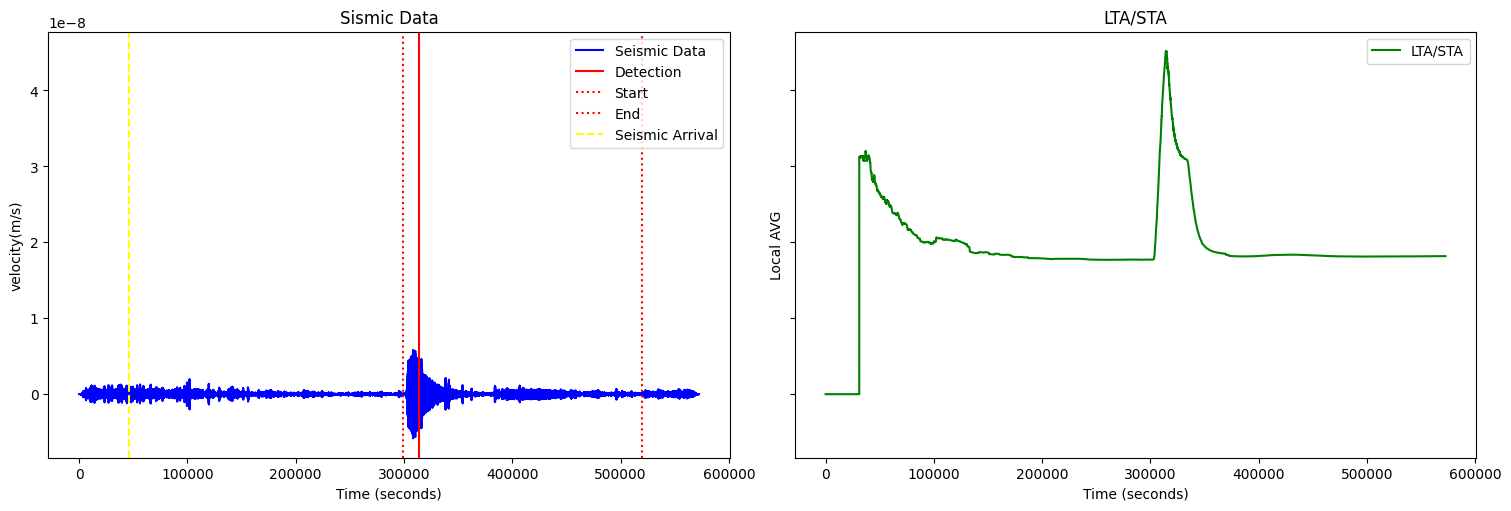

Processed: 16/76
Elapsed: 7.391932964324951 with error: 268696.0 segs.


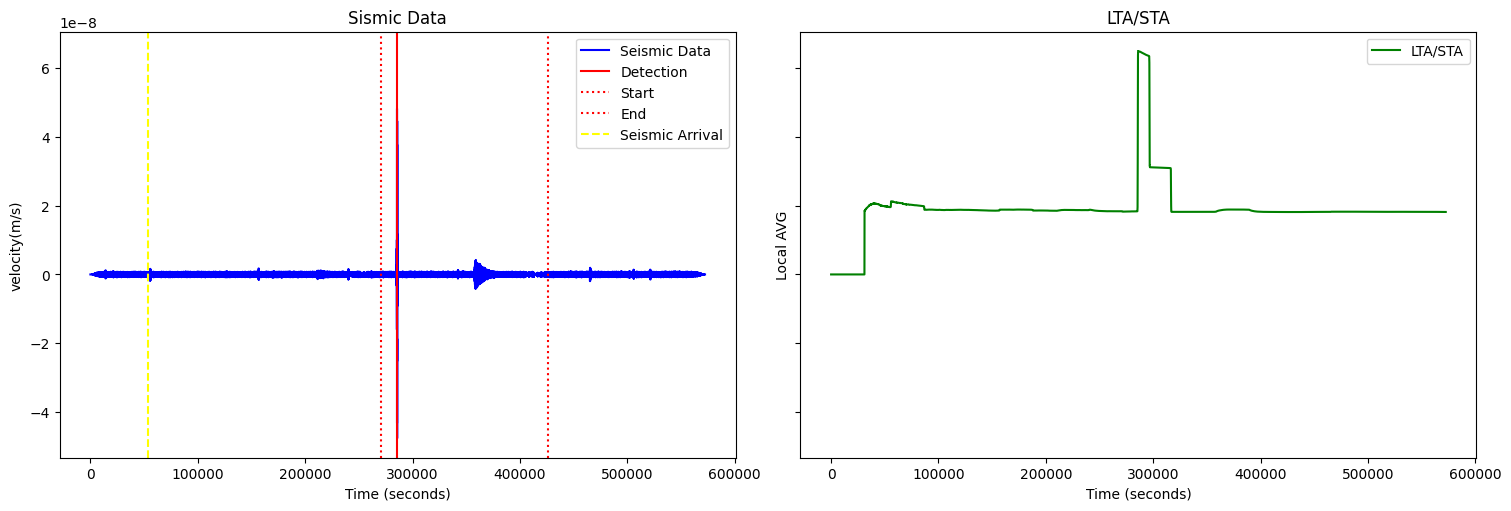

Processed: 17/76
Elapsed: 4.32910943031311 with error: 232071.0 segs.


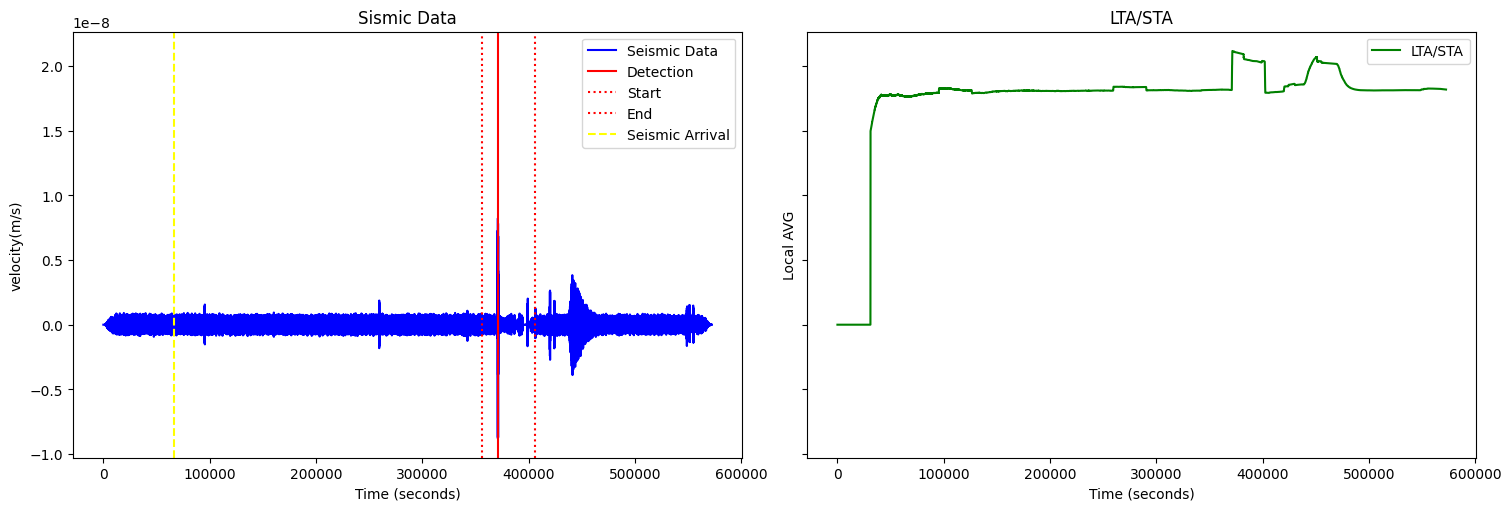

Processed: 18/76
Elapsed: 3.8300421237945557 with error: 305427.0 segs.


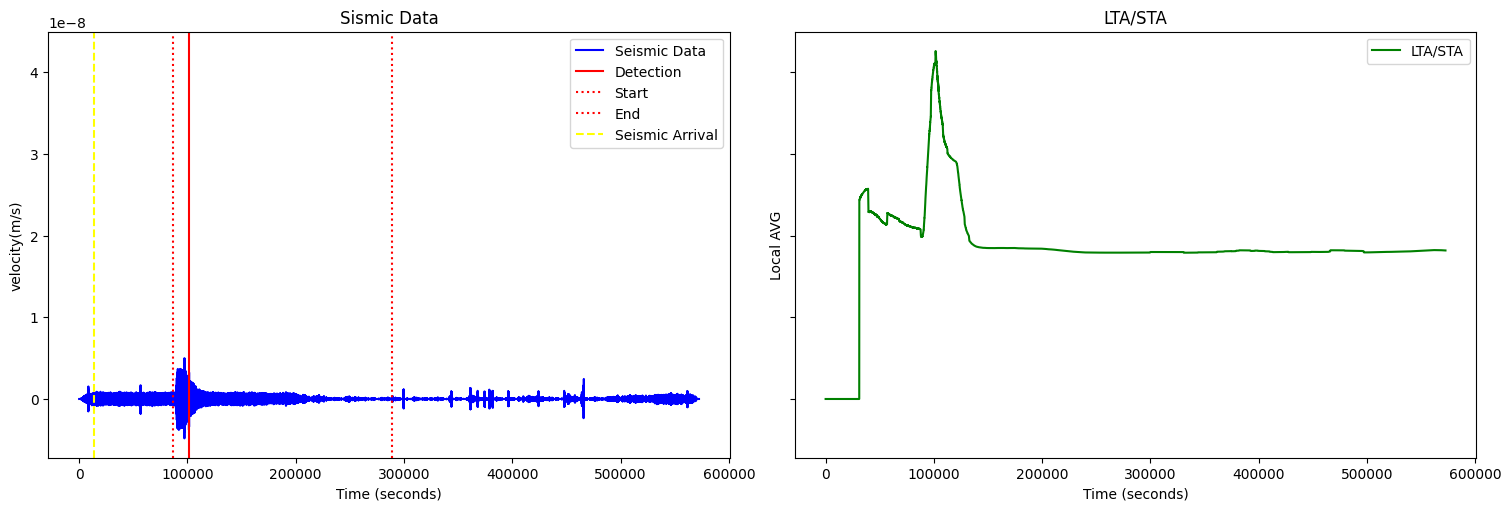

Processed: 19/76
Elapsed: 7.0468058586120605 with error: 88269.0 segs.


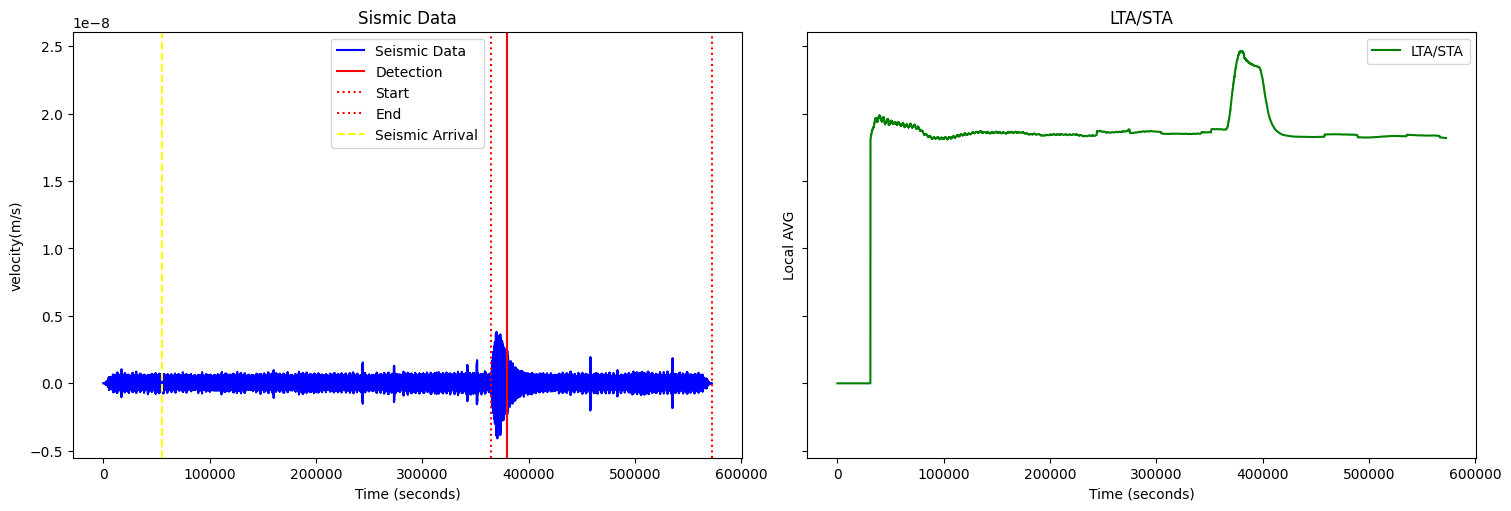

Processed: 20/76
Elapsed: 5.792137145996094 with error: 325010.0 segs.


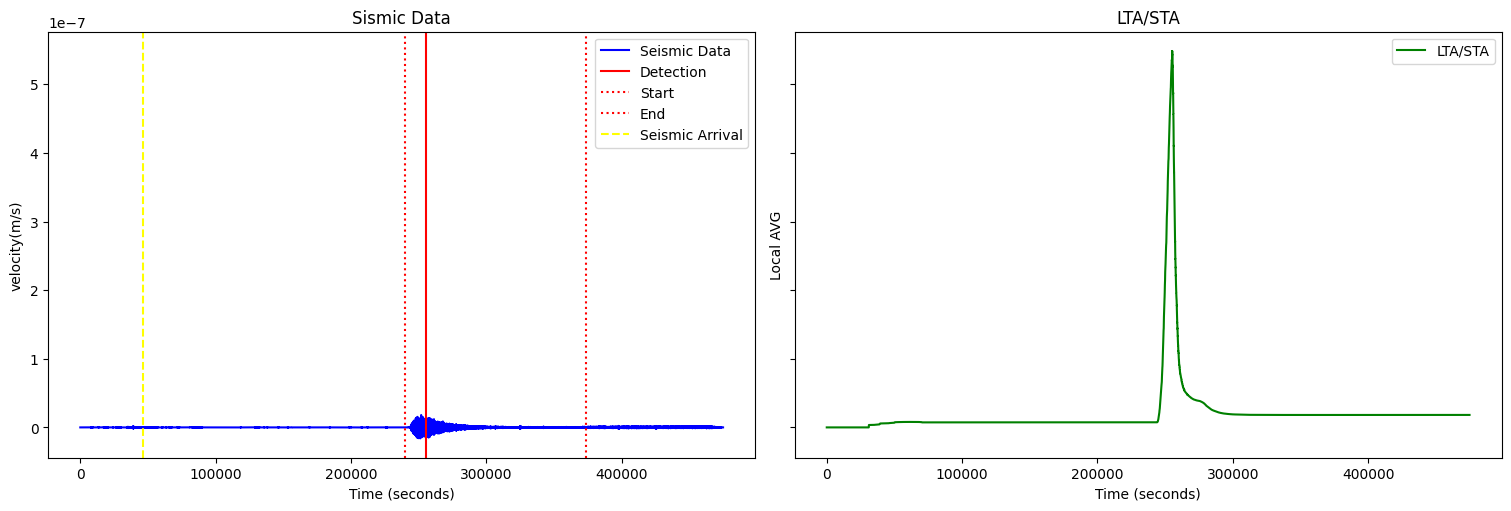

Processed: 21/76
Elapsed: 4.029967784881592 with error: 208746.0 segs.


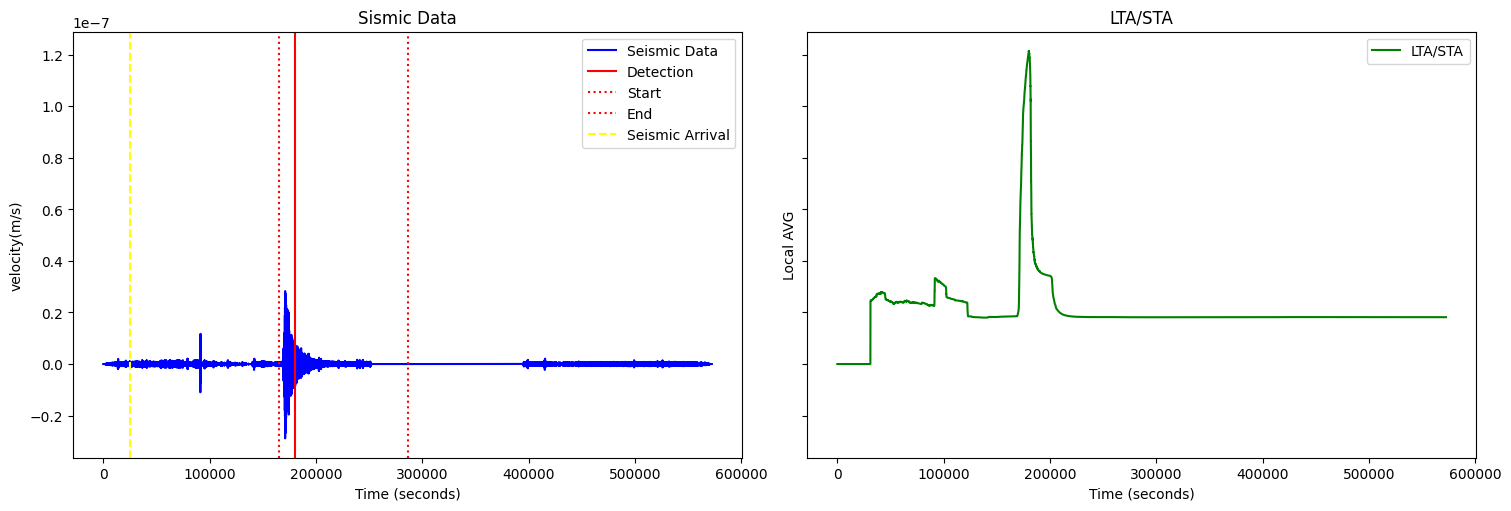

Processed: 22/76
Elapsed: 4.240325927734375 with error: 154709.0 segs.


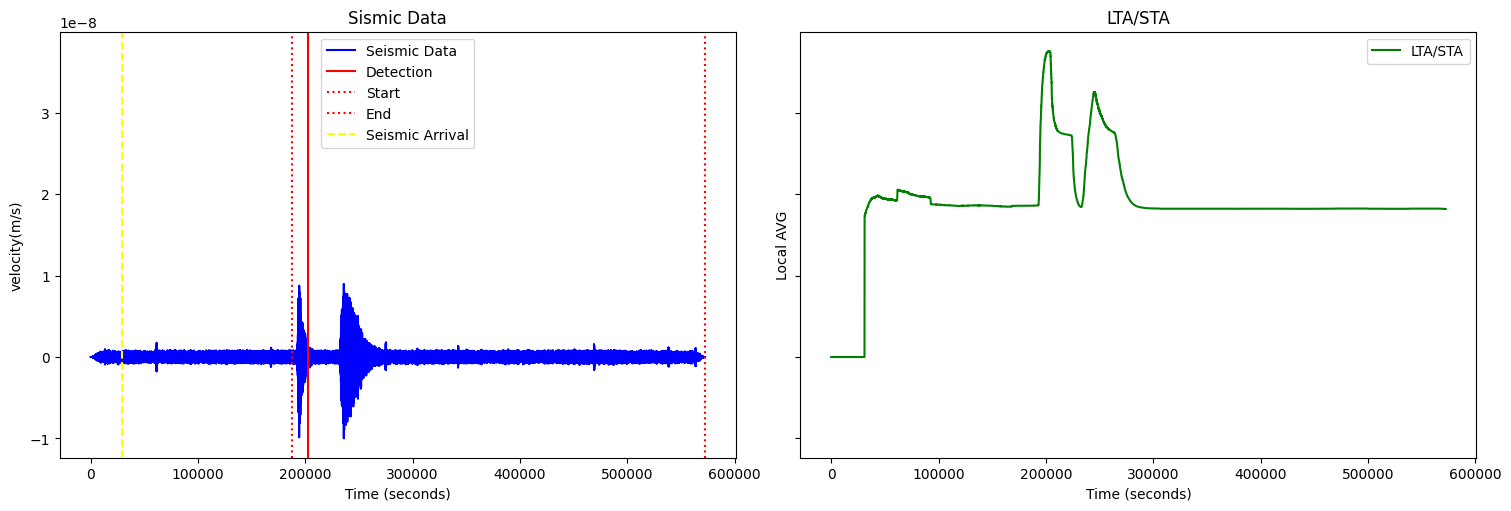

Processed: 23/76
Elapsed: 5.786509275436401 with error: 173859.0 segs.


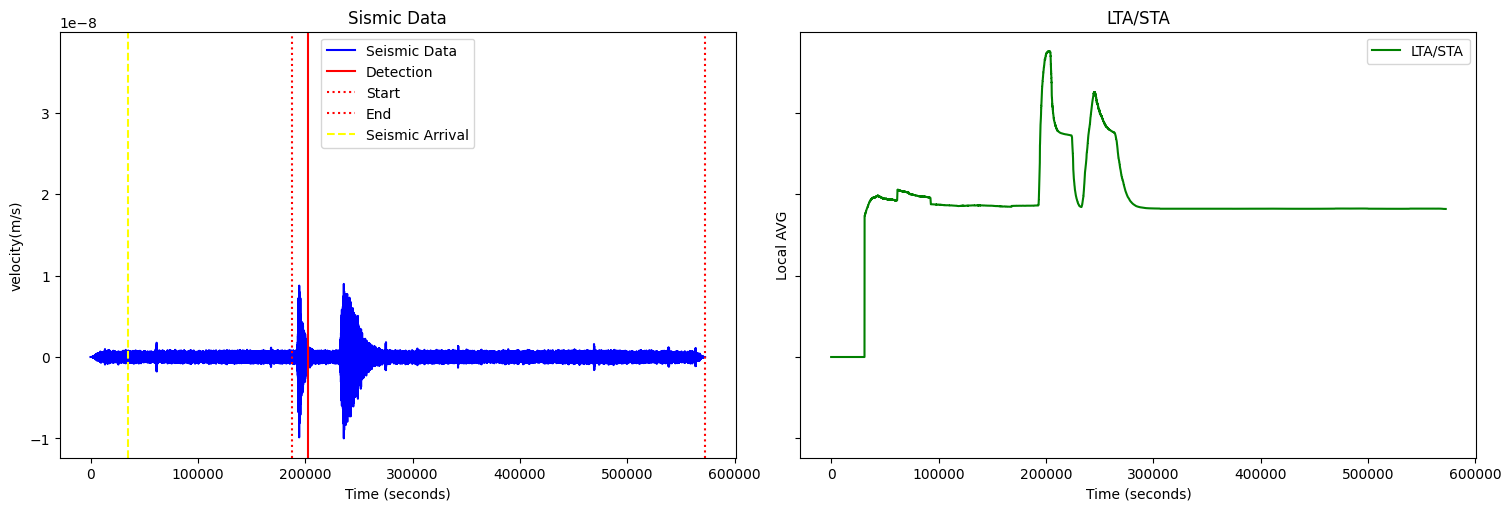

Processed: 24/76
Elapsed: 7.718397855758667 with error: 167859.0 segs.


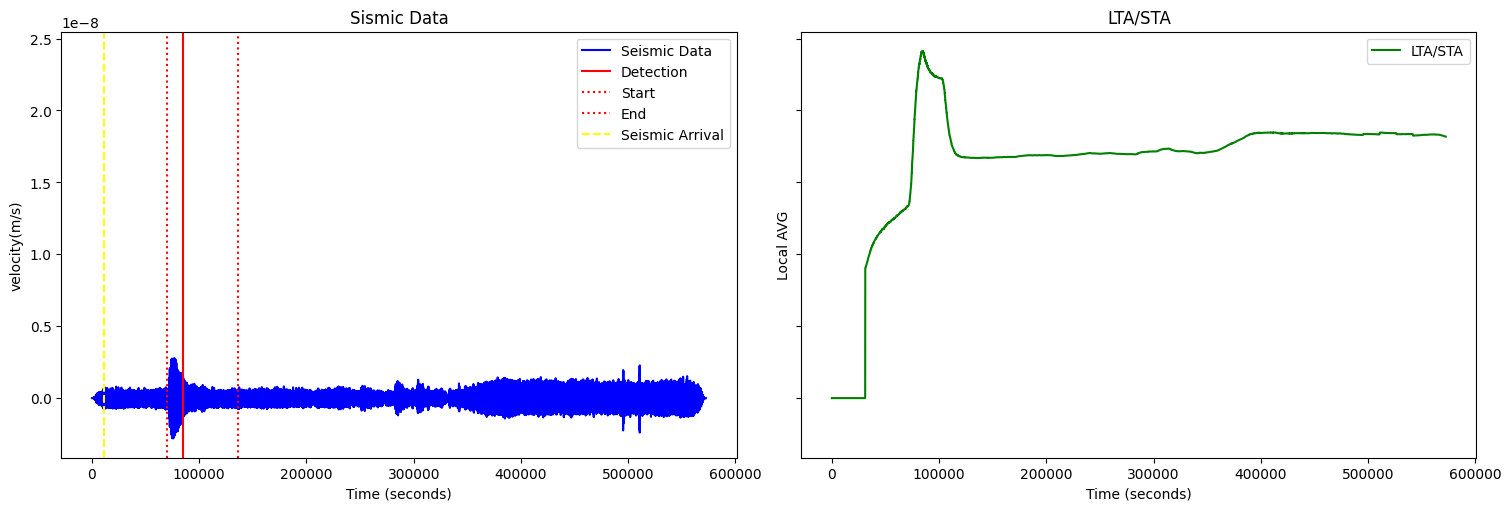

Processed: 25/76
Elapsed: 3.8384063243865967 with error: 73917.0 segs.


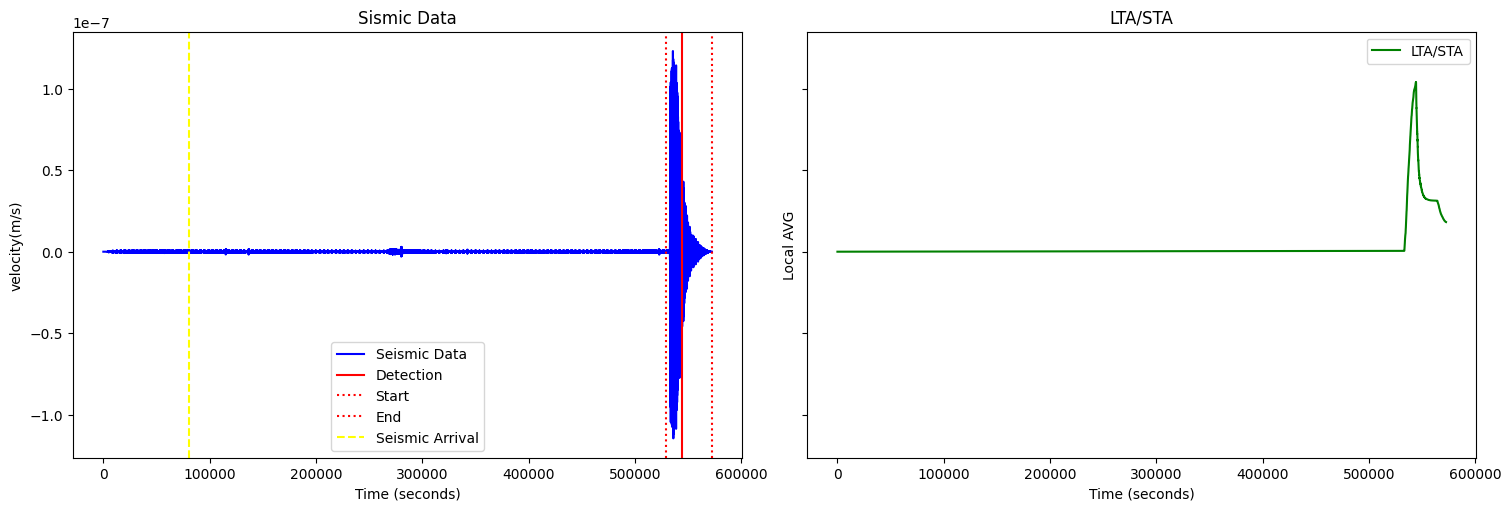

Processed: 26/76
Elapsed: 7.308748245239258 with error: 463669.0 segs.


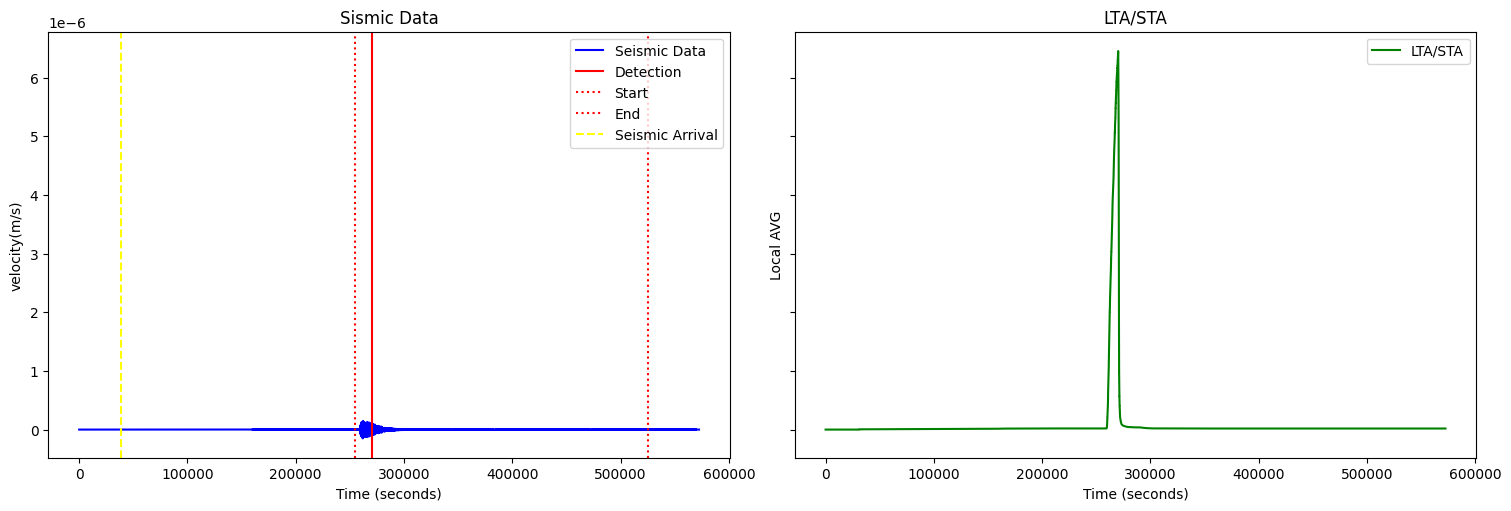

Processed: 27/76
Elapsed: 6.446302652359009 with error: 231107.0 segs.


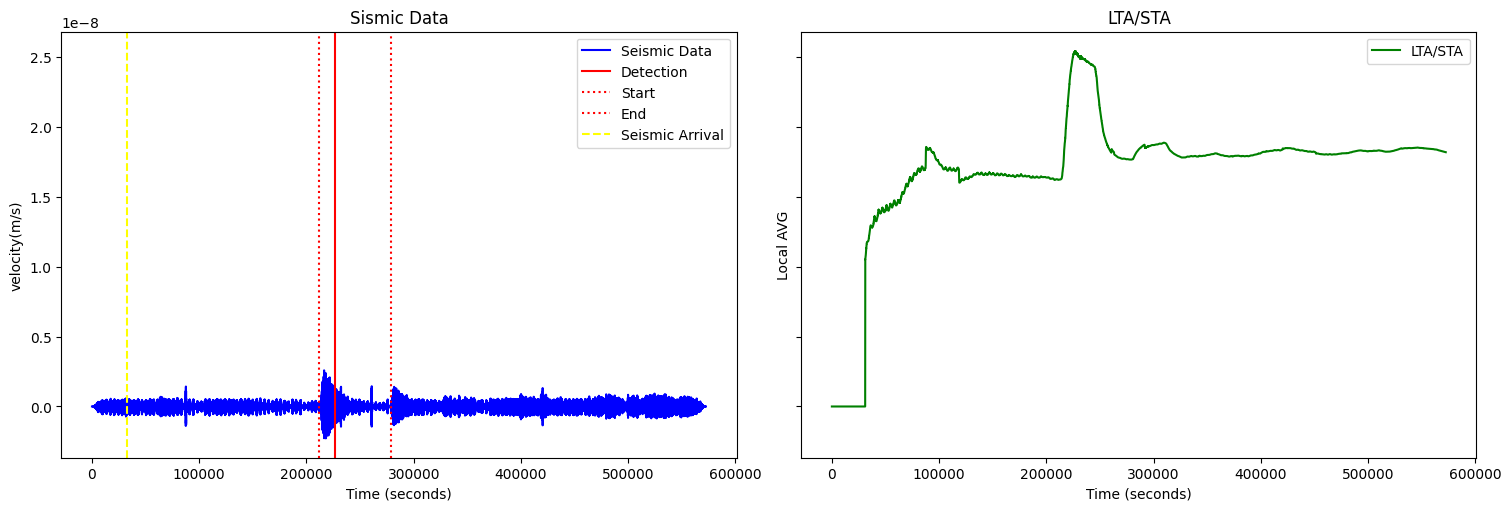

Processed: 28/76
Elapsed: 3.7384889125823975 with error: 194721.0 segs.


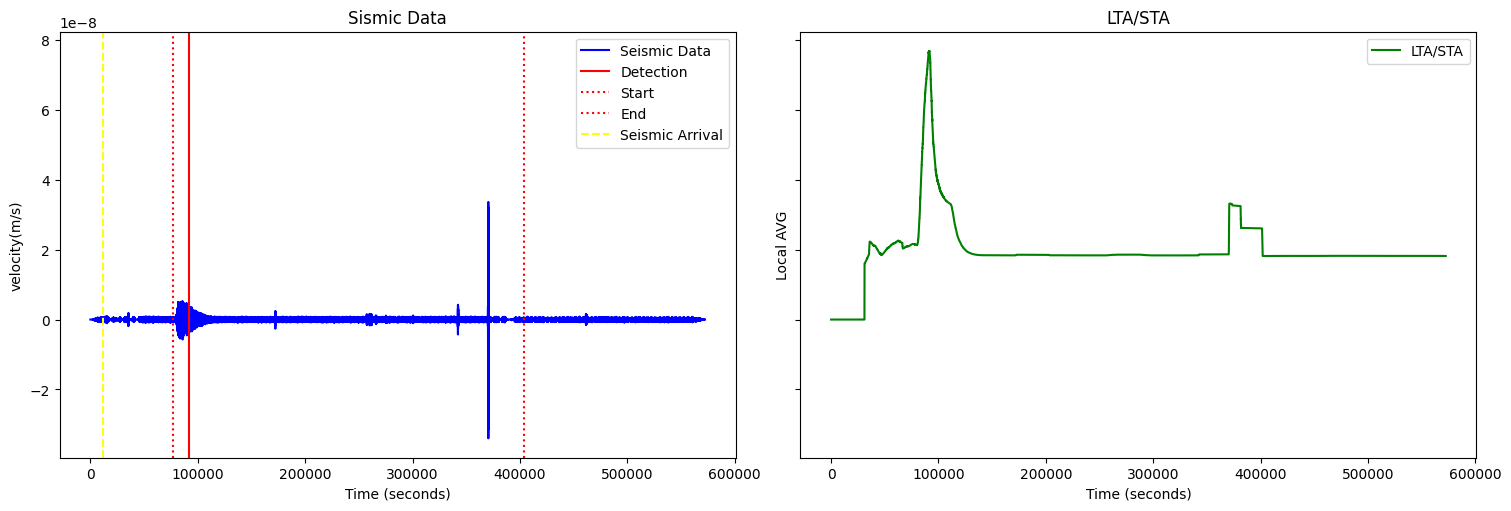

Processed: 29/76
Elapsed: 4.92492938041687 with error: 79573.0 segs.


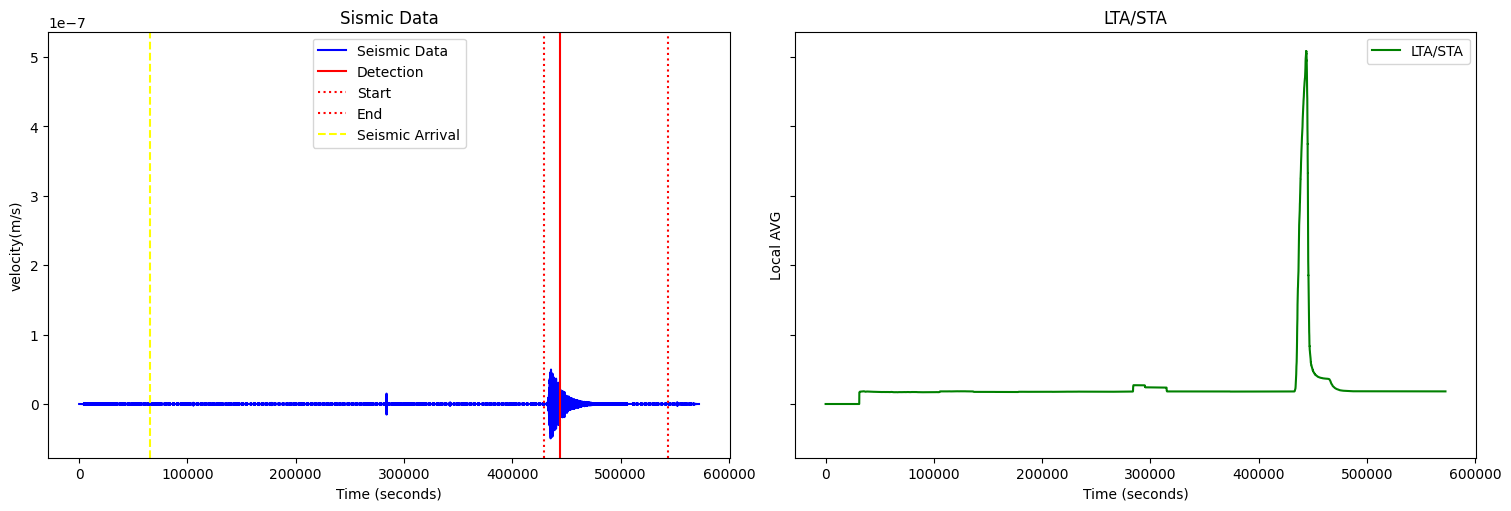

Processed: 30/76
Elapsed: 5.709164142608643 with error: 378609.0 segs.


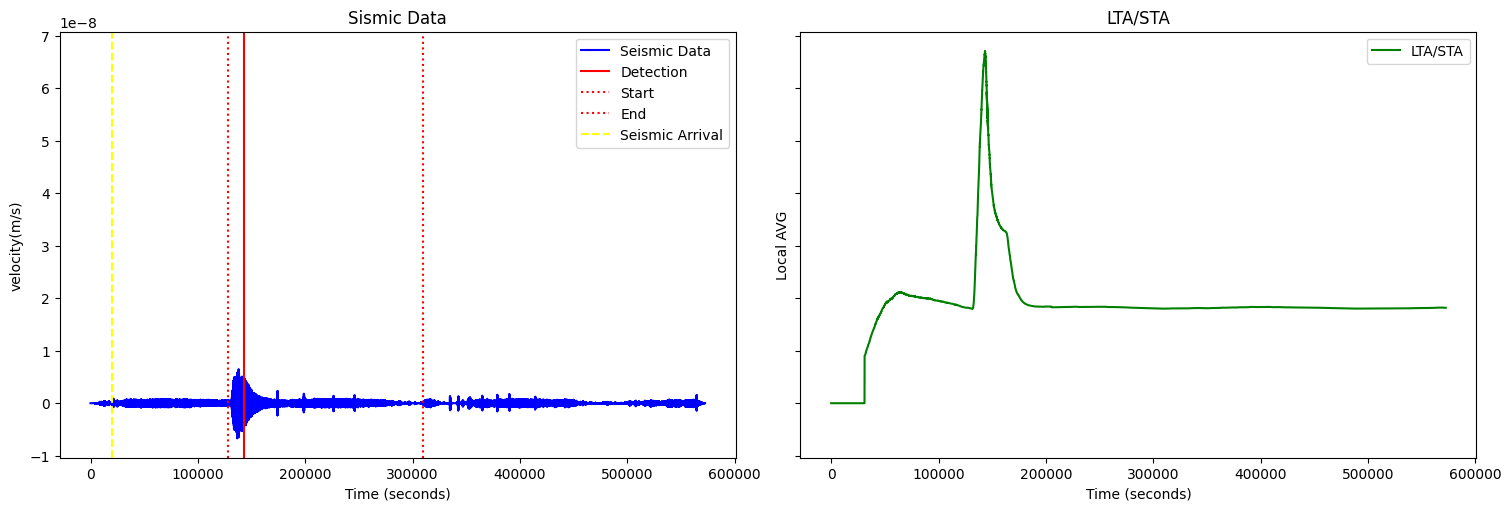

Processed: 31/76
Elapsed: 4.478052377700806 with error: 123510.0 segs.


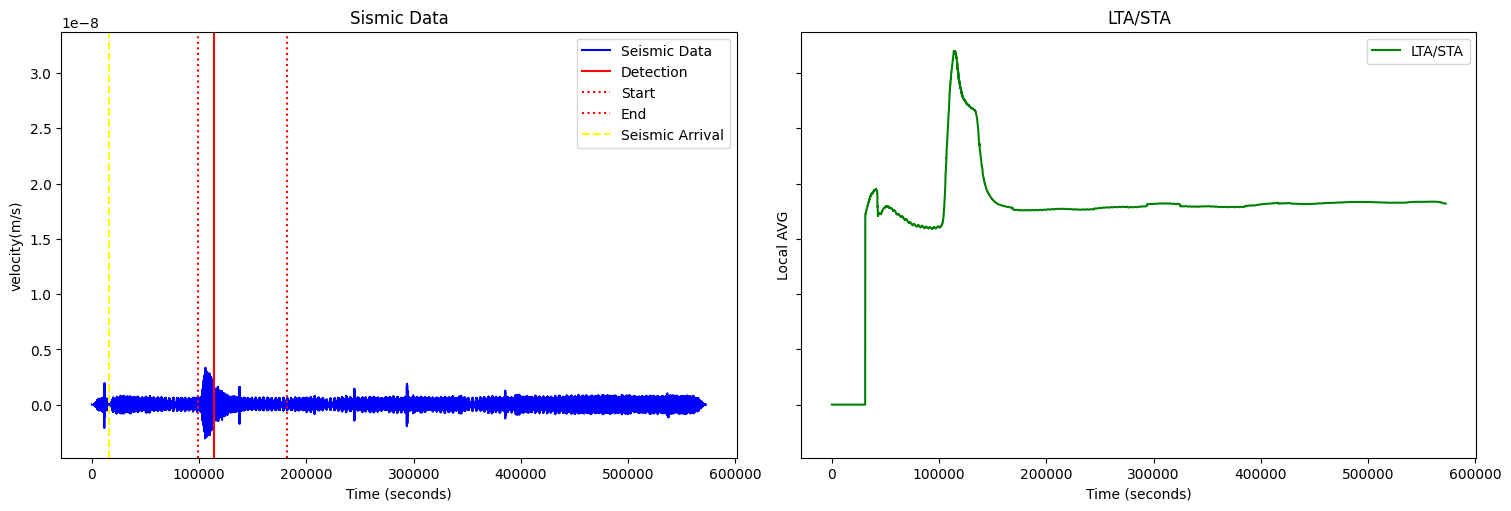

Processed: 32/76
Elapsed: 4.328653335571289 with error: 98477.0 segs.


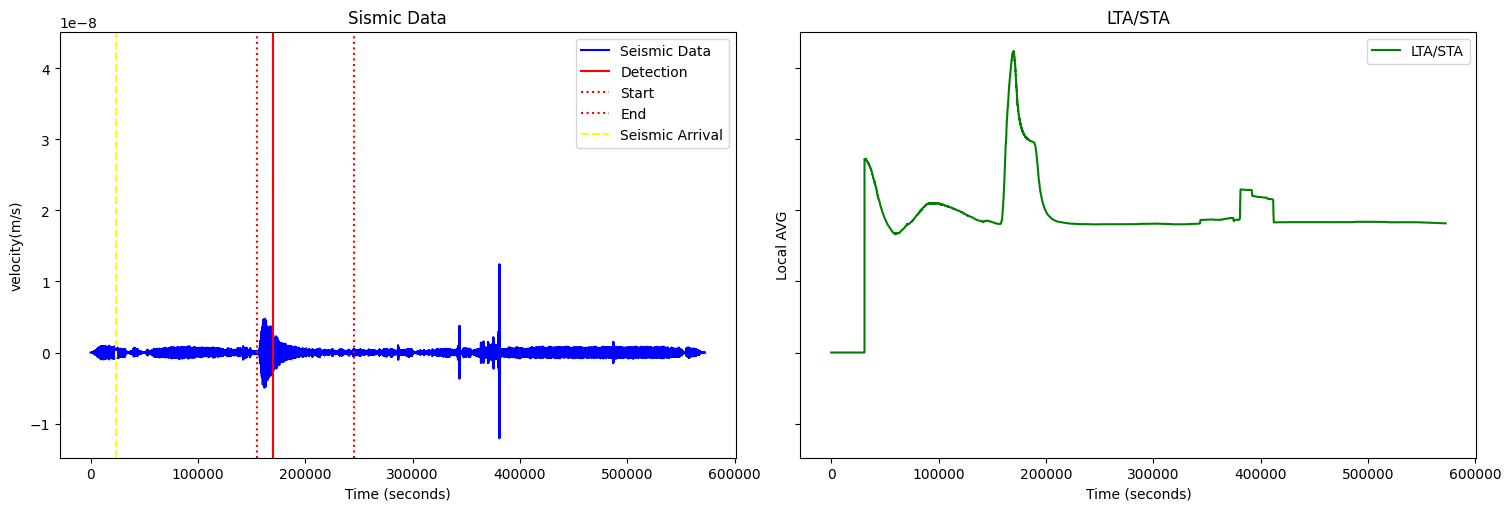

Processed: 33/76
Elapsed: 4.300266981124878 with error: 146135.0 segs.


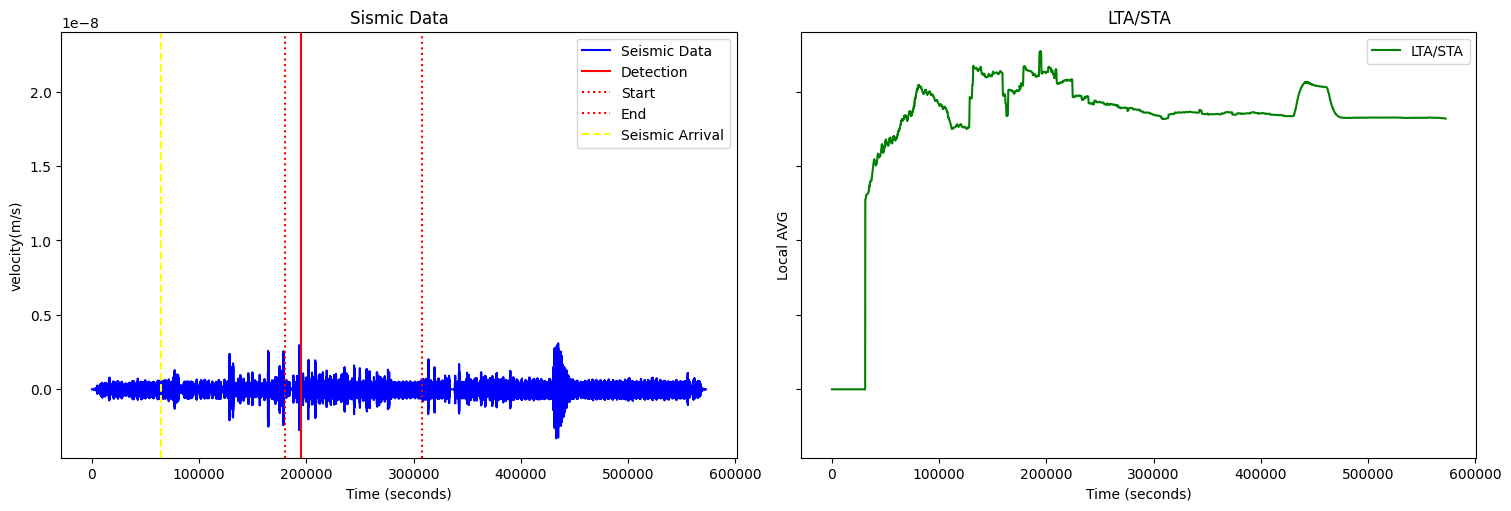

Processed: 34/76
Elapsed: 4.202532529830933 with error: 129728.0 segs.


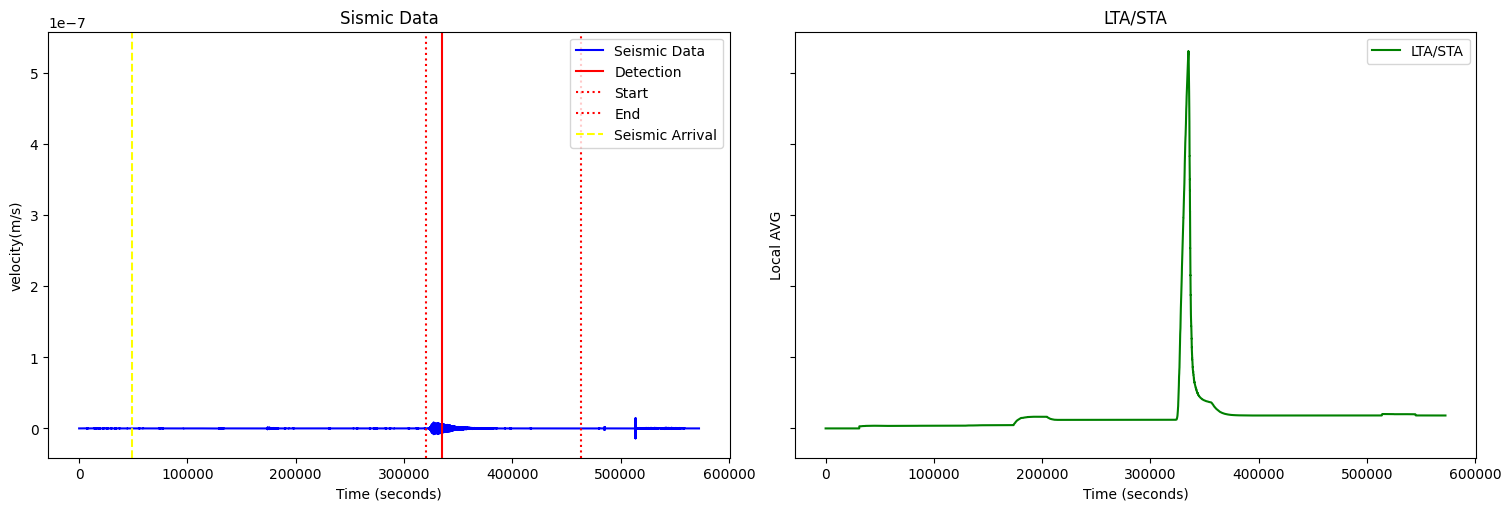

Processed: 35/76
Elapsed: 7.110392093658447 with error: 286106.0 segs.


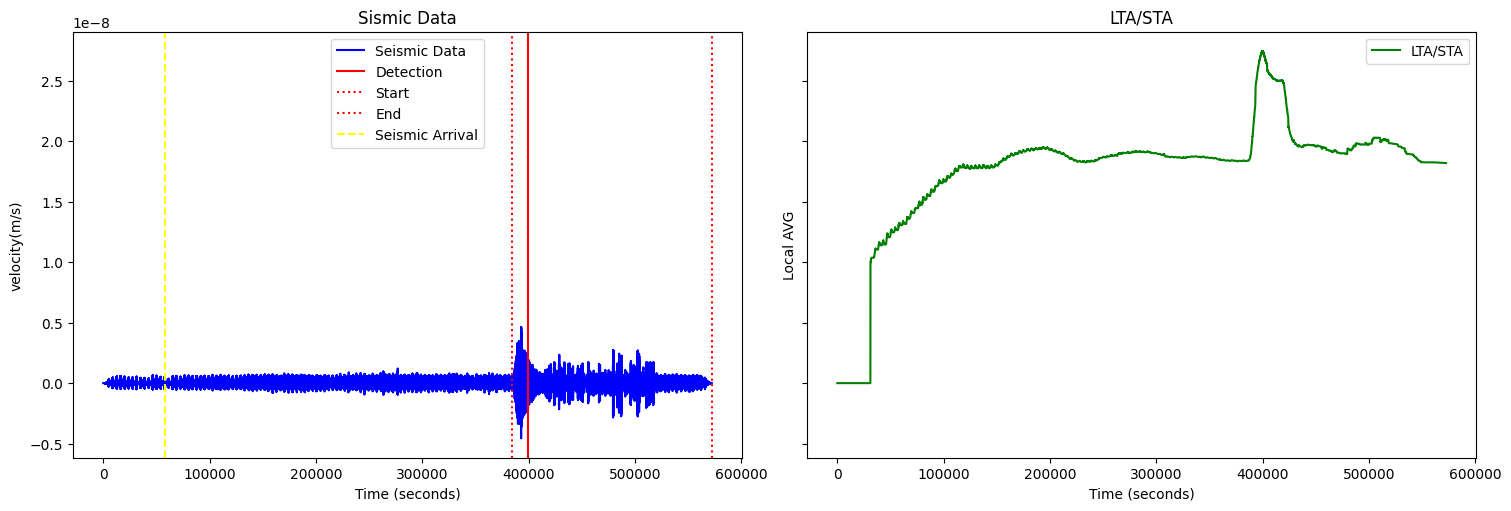

Processed: 36/76
Elapsed: 6.366818189620972 with error: 341418.0 segs.


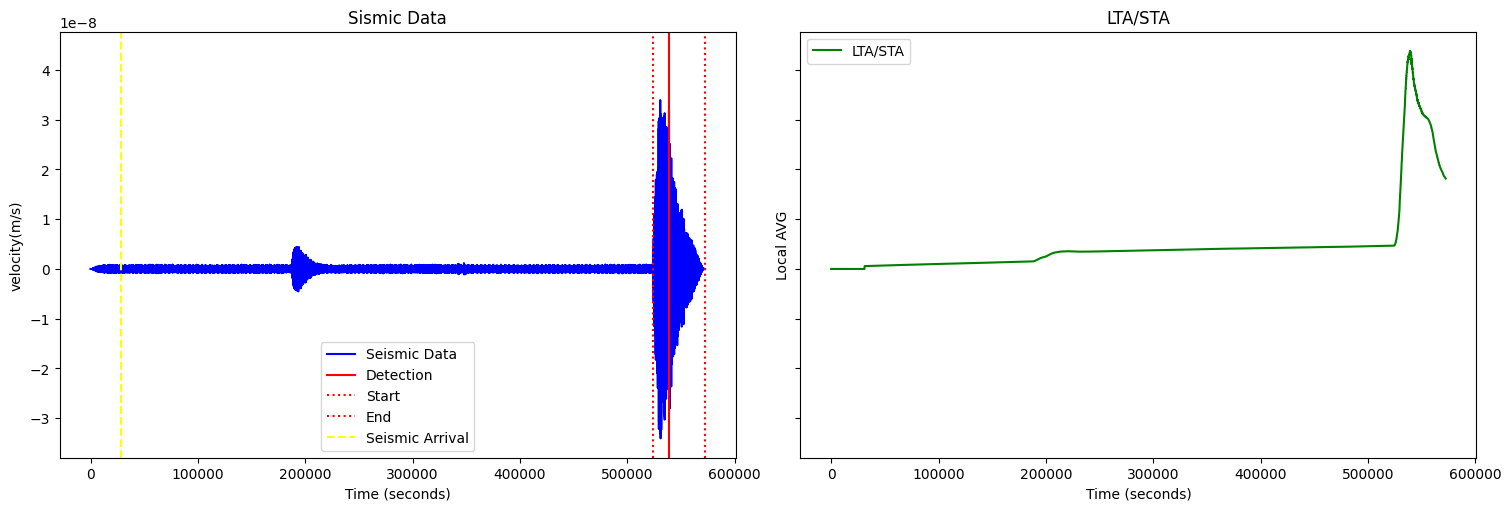

Processed: 37/76
Elapsed: 6.269107103347778 with error: 510867.0 segs.


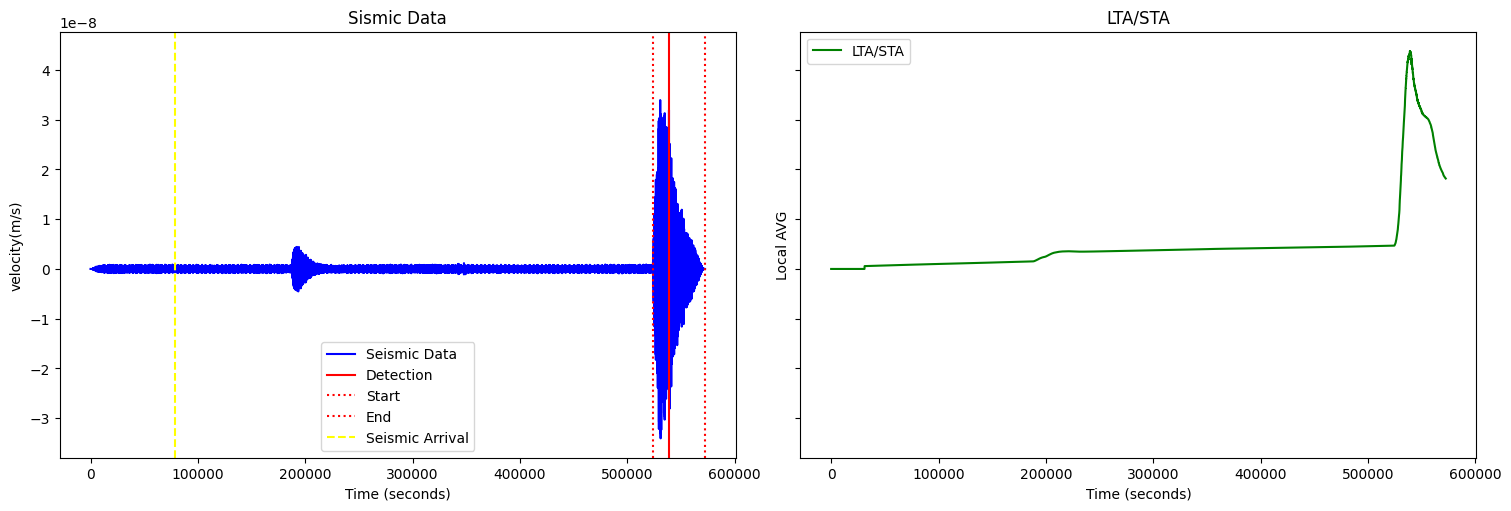

Processed: 38/76
Elapsed: 6.140984058380127 with error: 460107.0 segs.


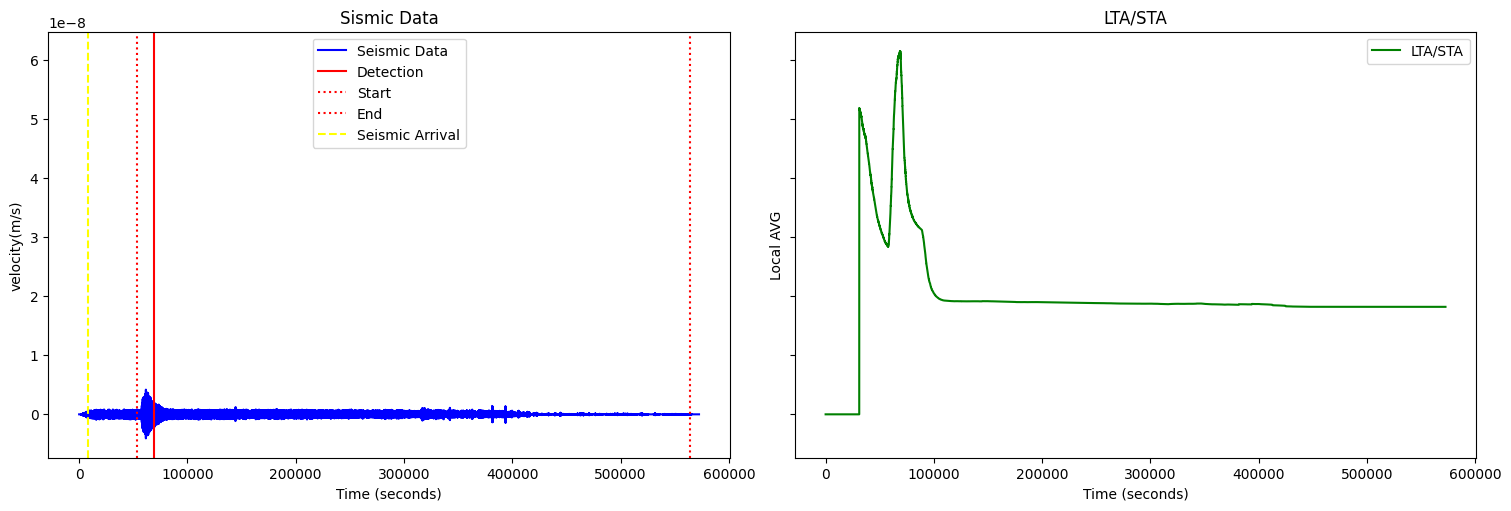

Processed: 39/76
Elapsed: 6.847376823425293 with error: 60172.0 segs.


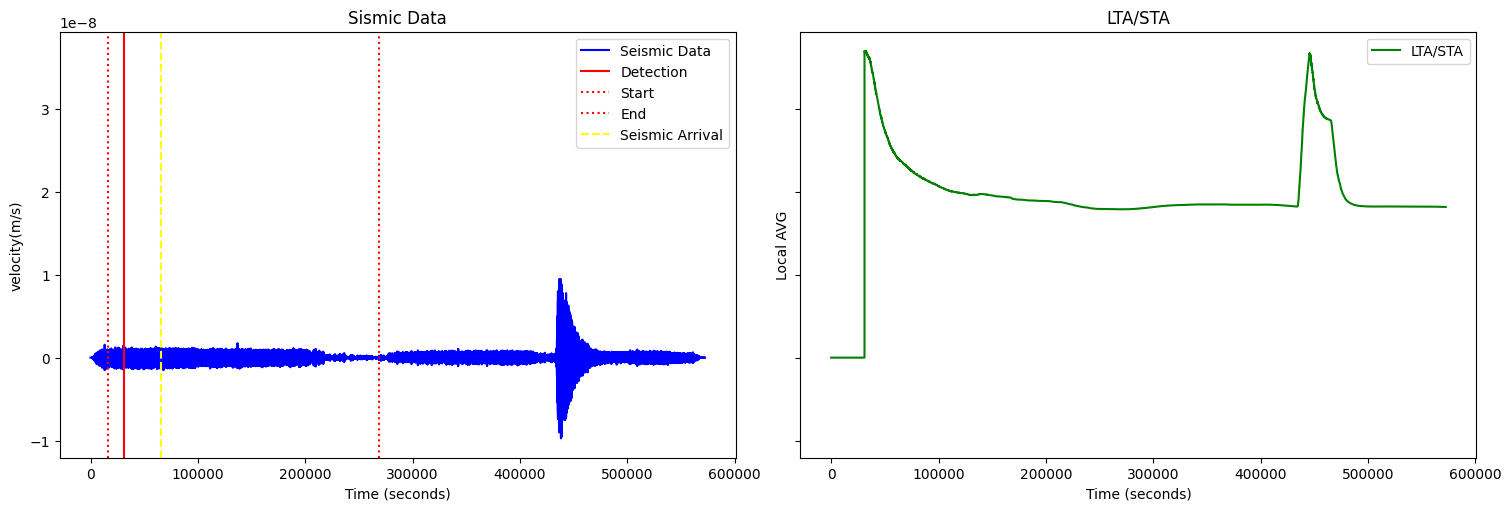

Processed: 40/76
Elapsed: 3.761953353881836 with error: 33688.0 segs.


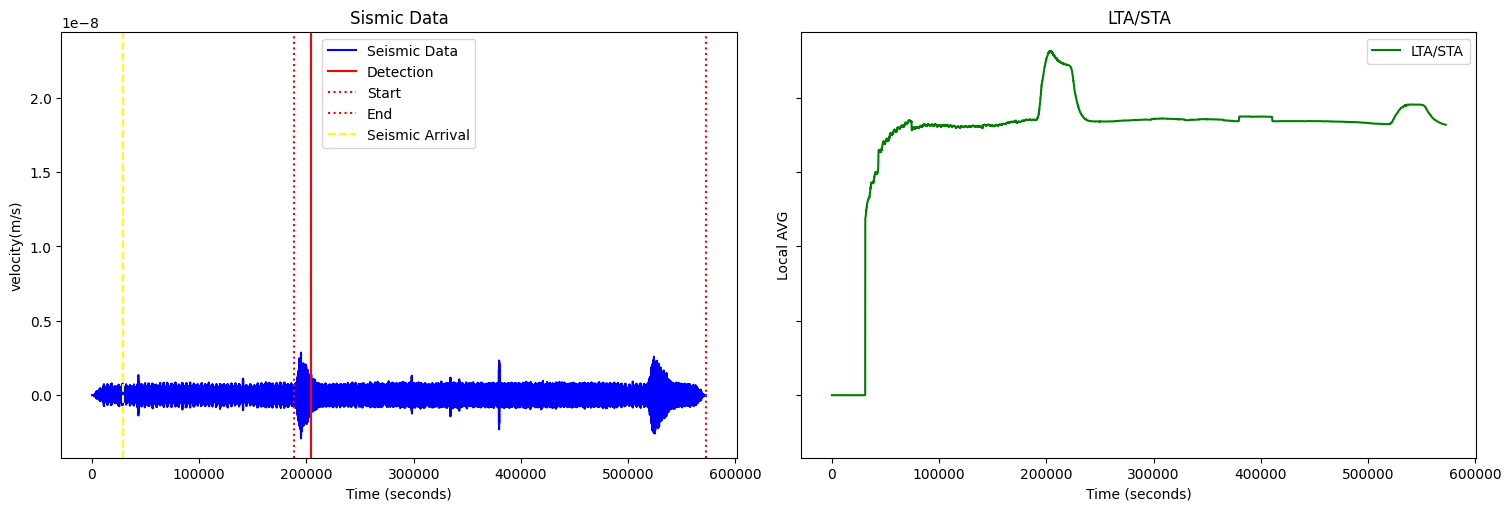

Processed: 41/76
Elapsed: 7.108057022094727 with error: 175163.0 segs.


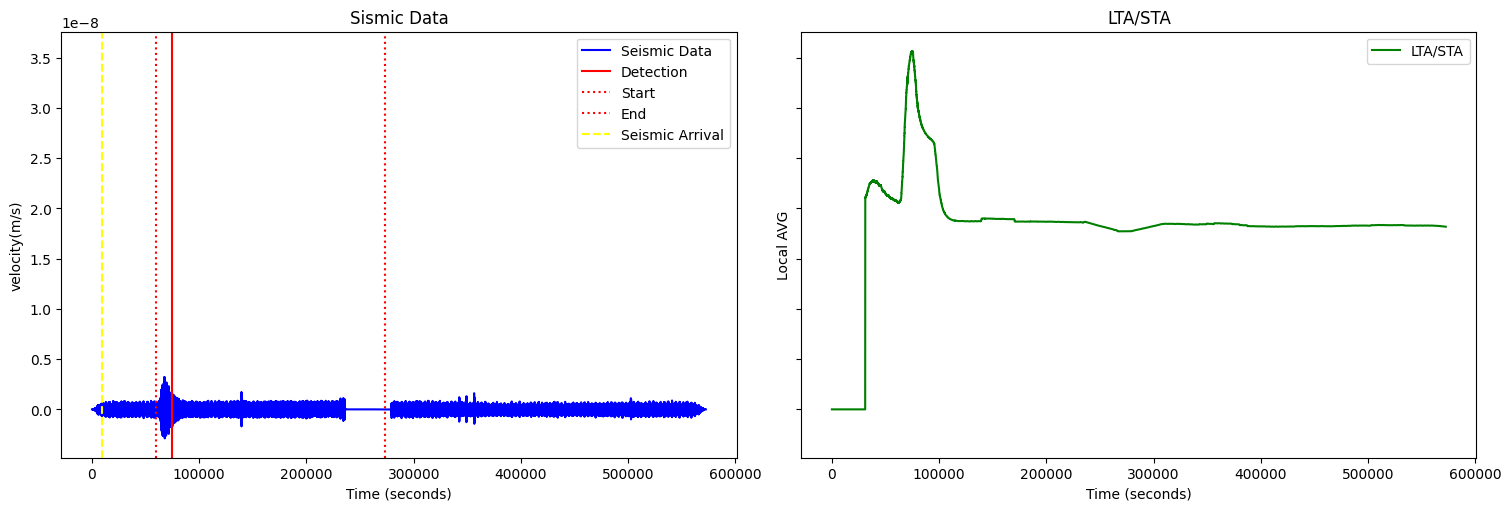

Processed: 42/76
Elapsed: 4.201749086380005 with error: 65475.0 segs.


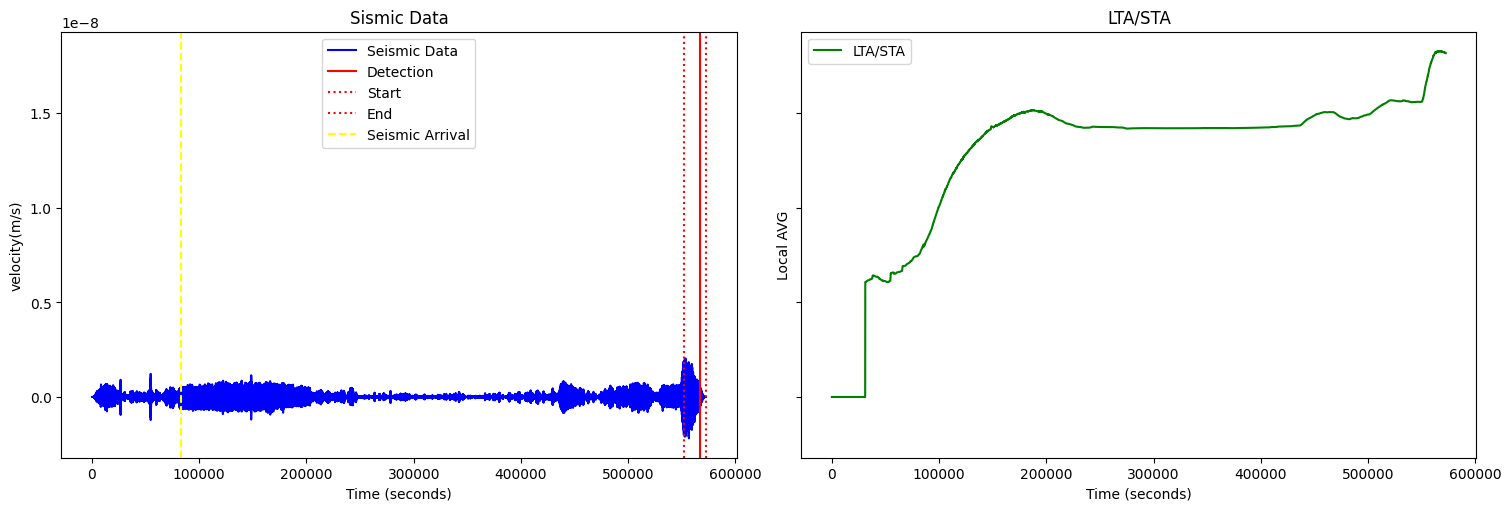

Processed: 43/76
Elapsed: 7.081936597824097 with error: 483798.0 segs.


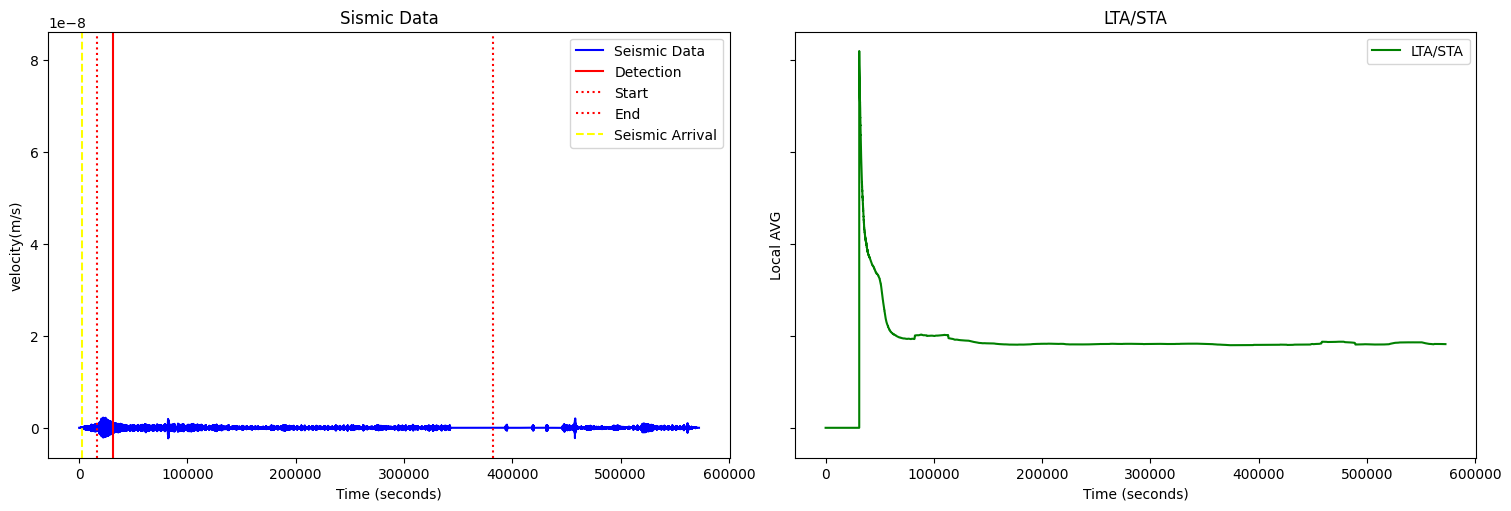

Processed: 44/76
Elapsed: 3.841737985610962 with error: 28410.0 segs.


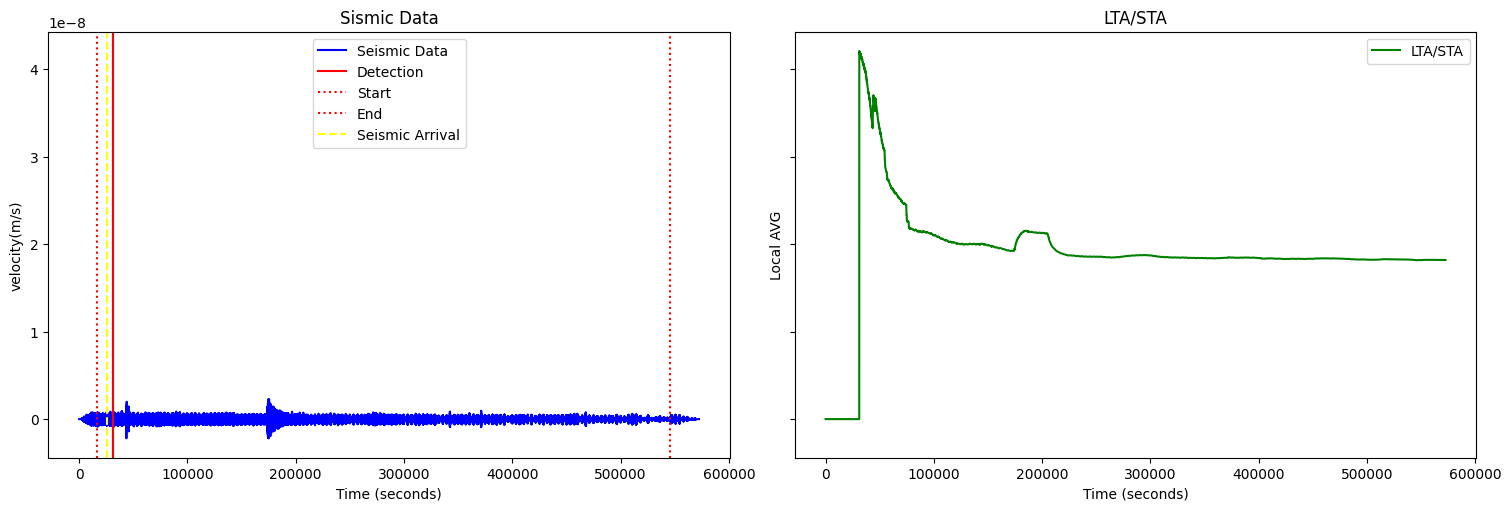

Processed: 45/76
Elapsed: 5.657355785369873 with error: 4995.0 segs.


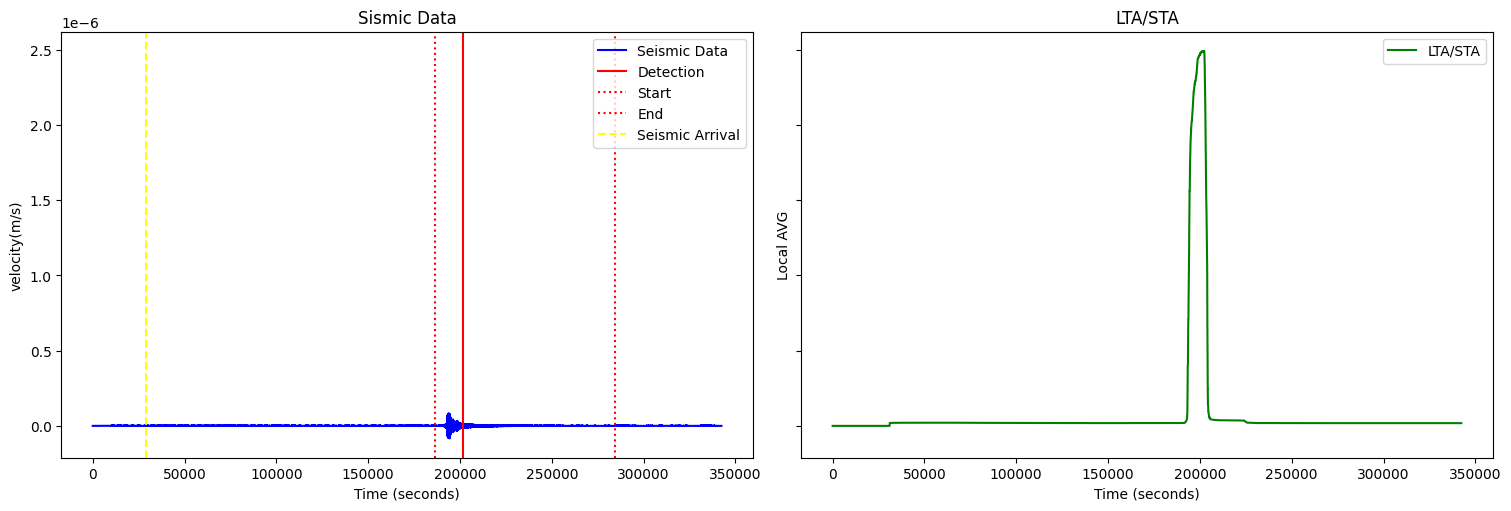

Processed: 46/76
Elapsed: 5.352279424667358 with error: 172703.0 segs.


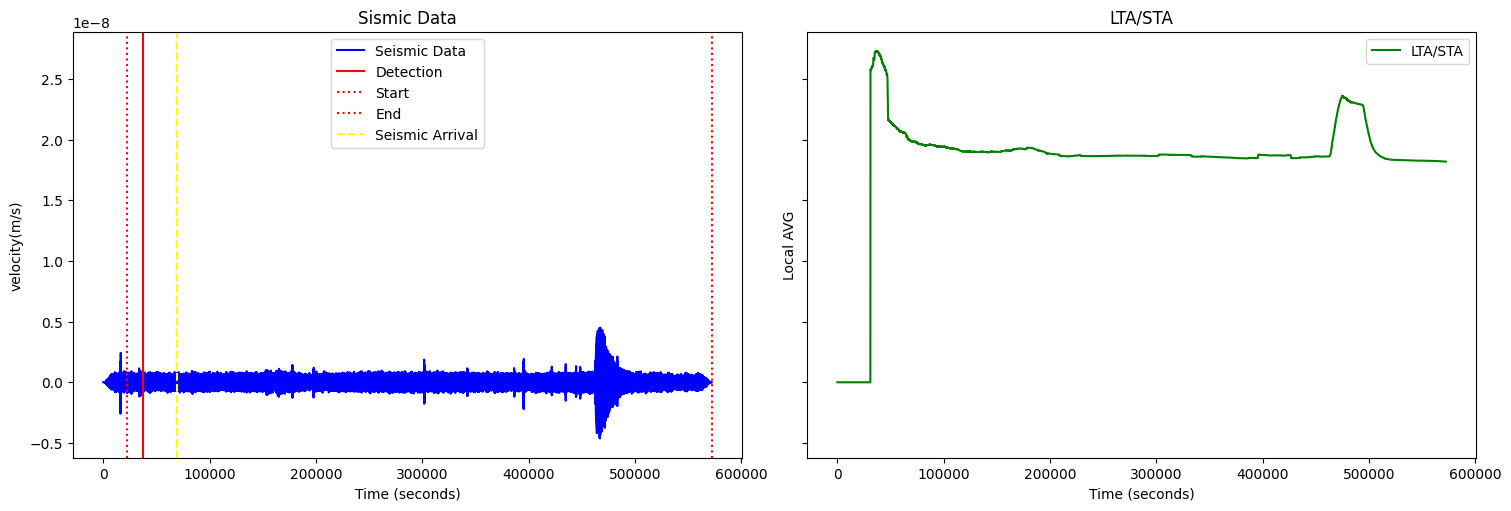

Processed: 47/76
Elapsed: 6.28292179107666 with error: 32438.0 segs.


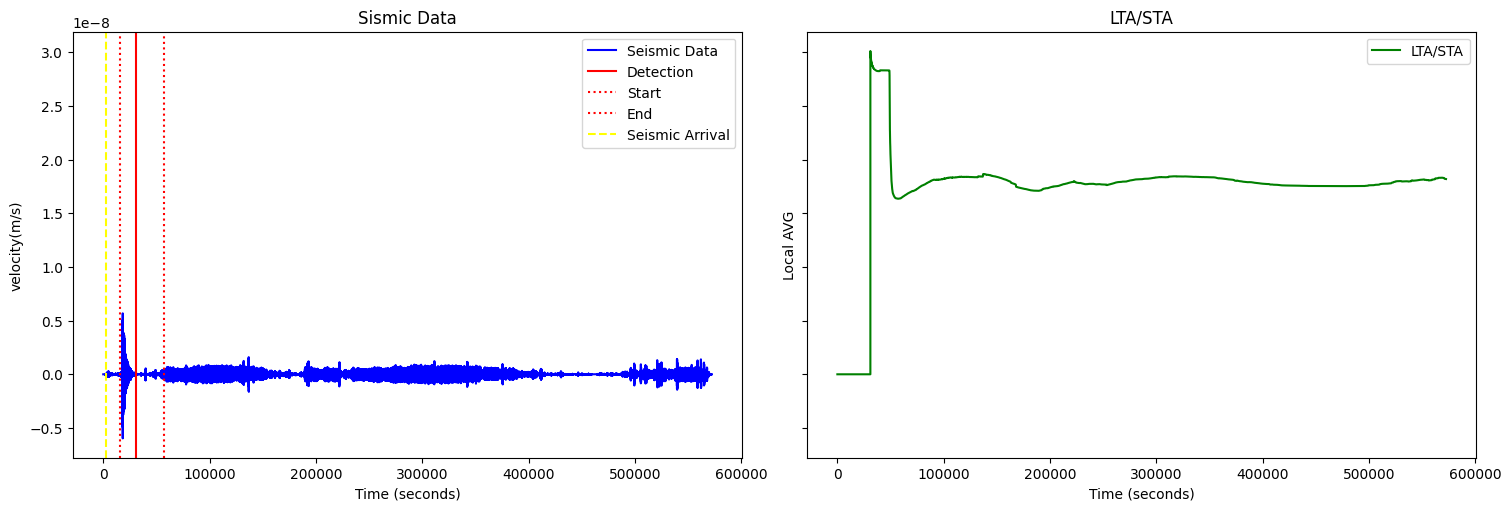

Processed: 48/76
Elapsed: 4.4169628620147705 with error: 28411.0 segs.


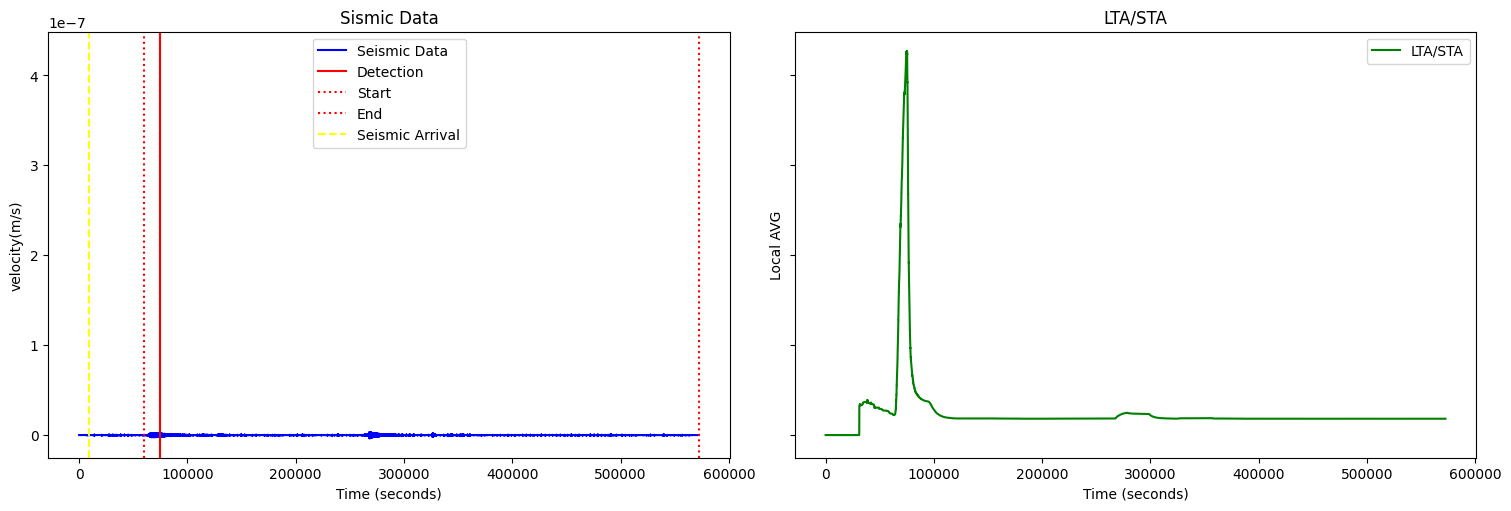

Processed: 49/76
Elapsed: 6.232370615005493 with error: 65615.0 segs.


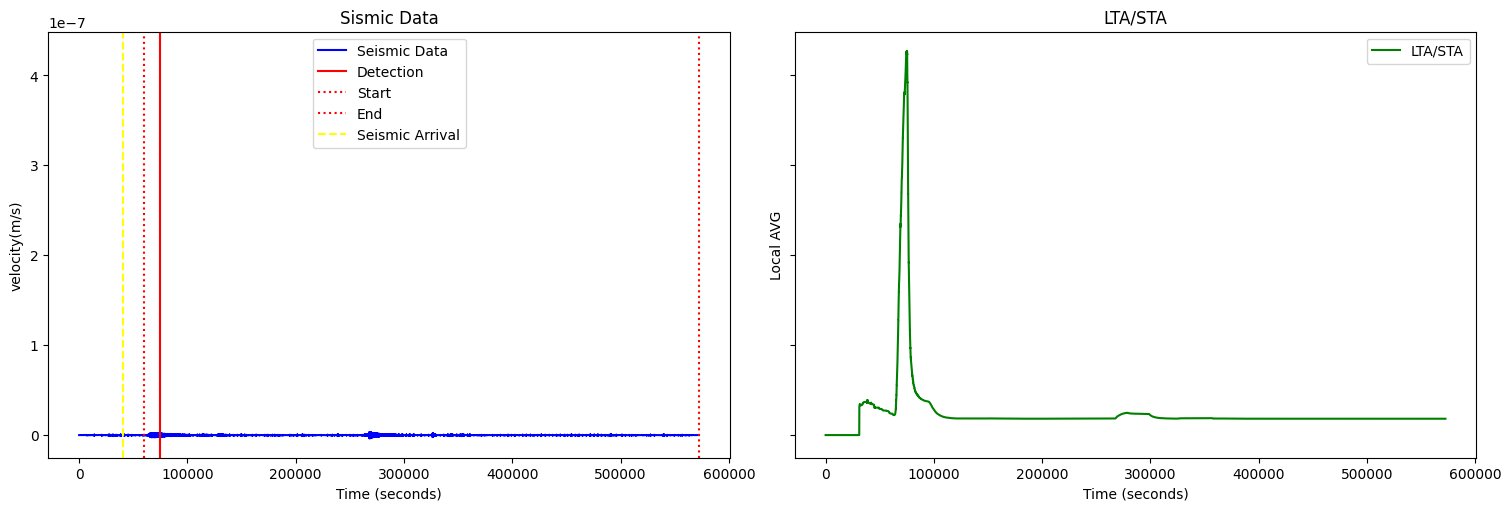

Processed: 50/76
Elapsed: 5.843388557434082 with error: 34895.0 segs.


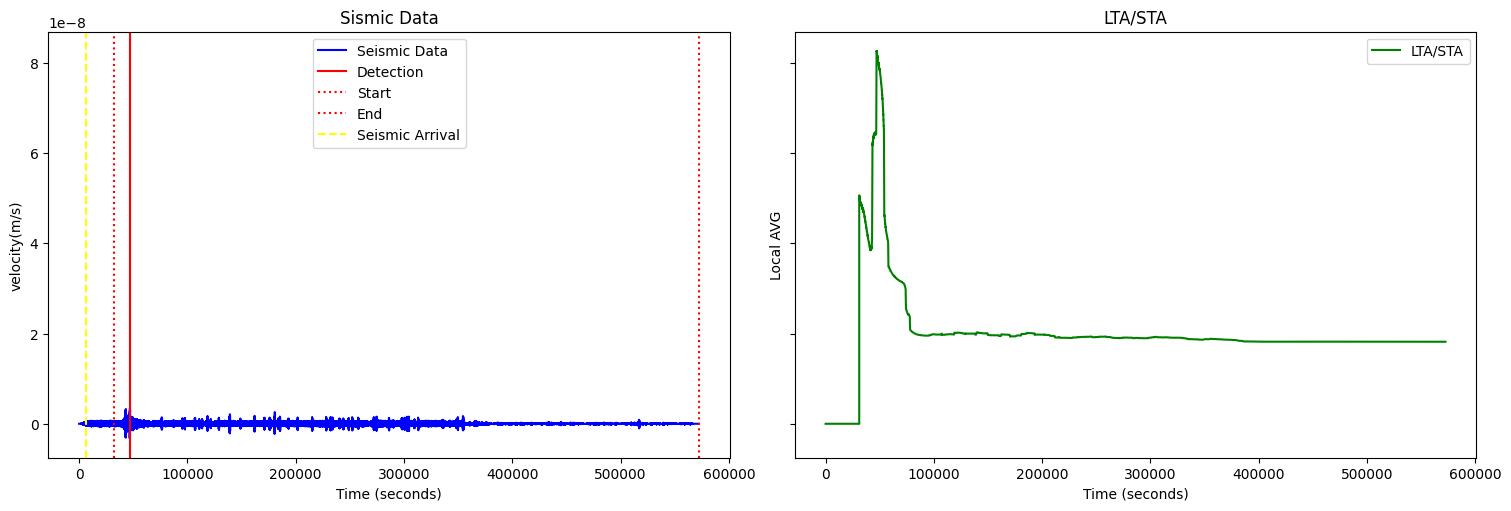

Processed: 51/76
Elapsed: 6.747160911560059 with error: 41023.0 segs.


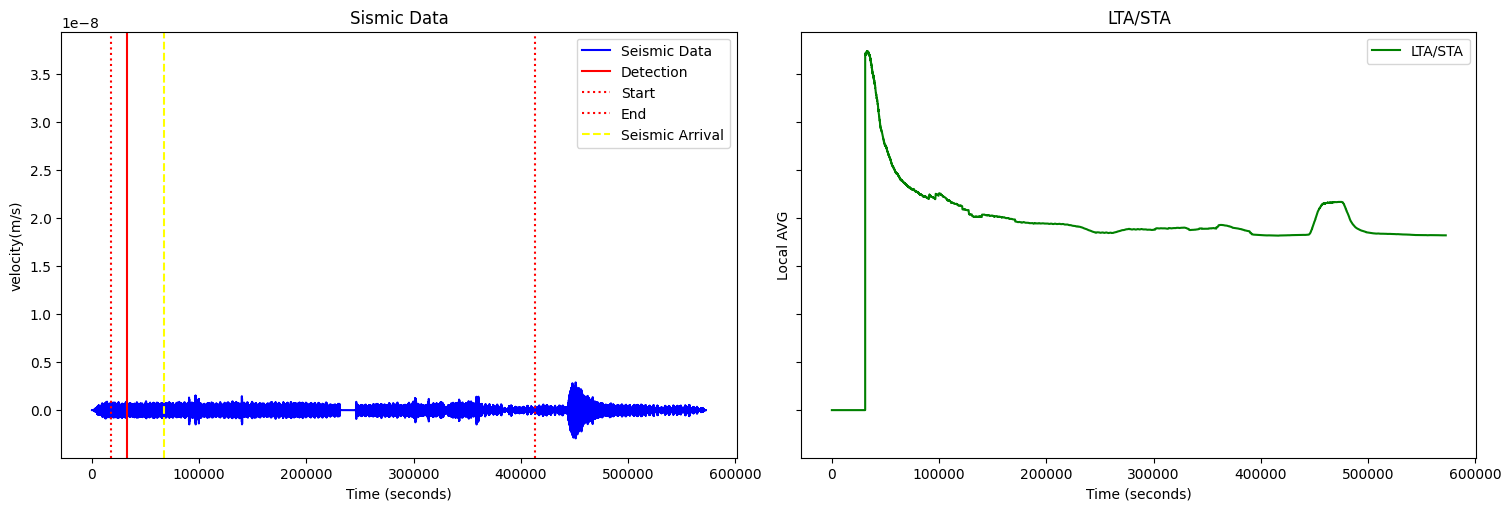

Processed: 52/76
Elapsed: 3.991550922393799 with error: 34035.0 segs.


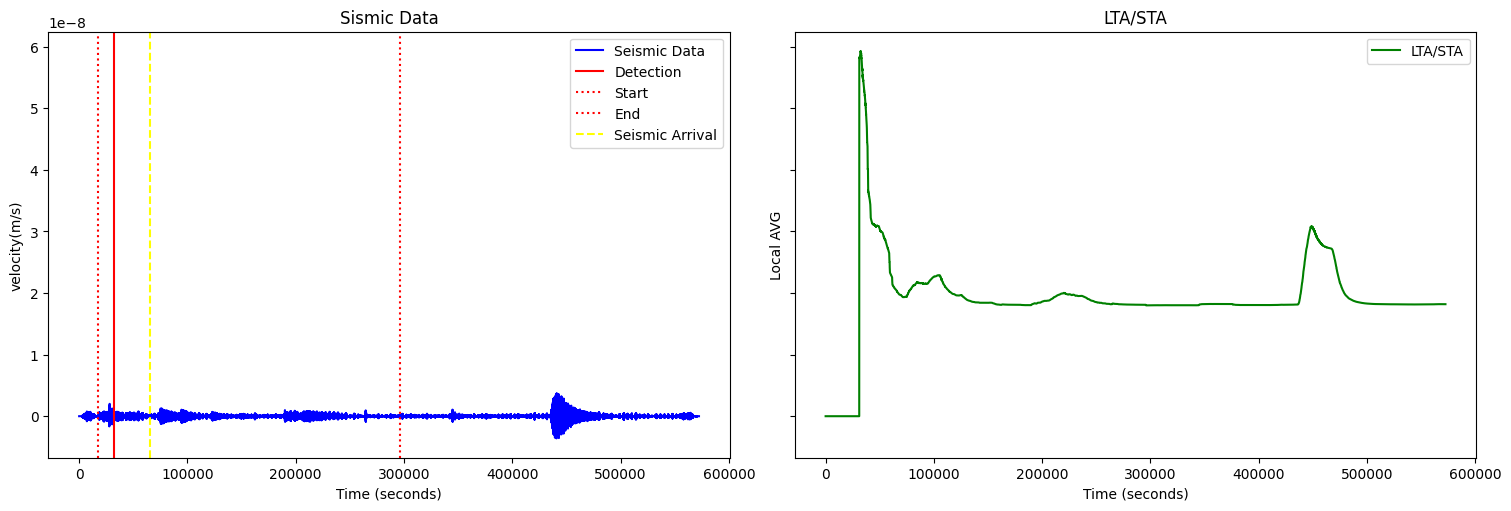

Processed: 53/76
Elapsed: 4.911405086517334 with error: 33374.0 segs.


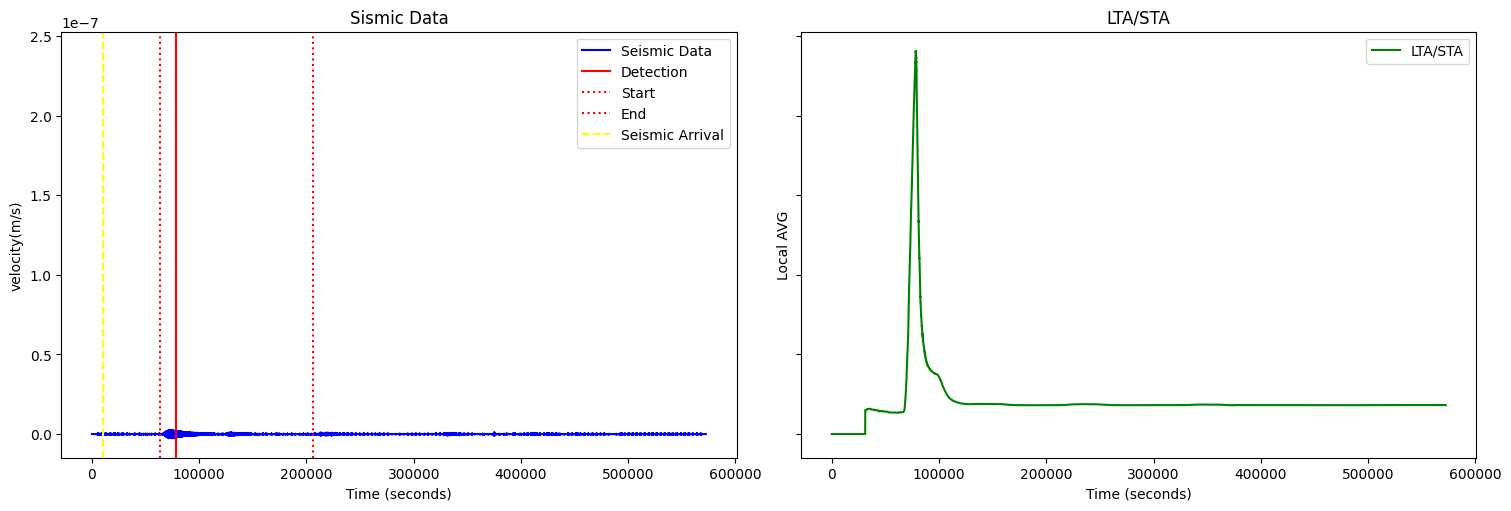

Processed: 54/76
Elapsed: 3.944411516189575 with error: 68256.0 segs.


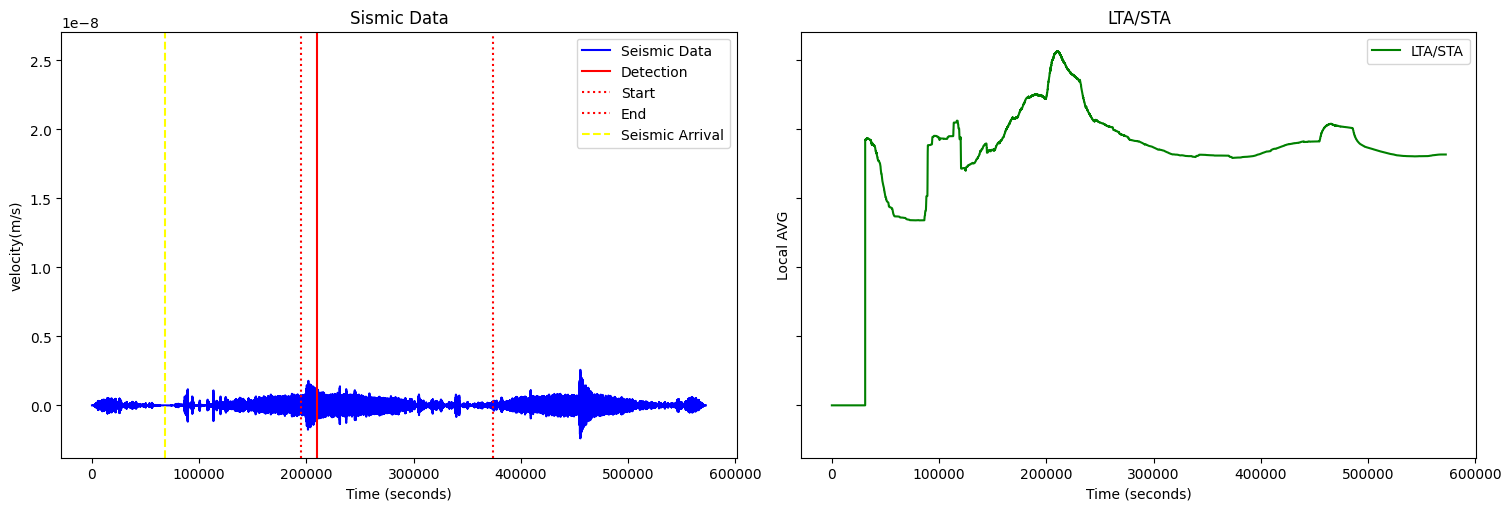

Processed: 55/76
Elapsed: 3.7793915271759033 with error: 141696.0 segs.


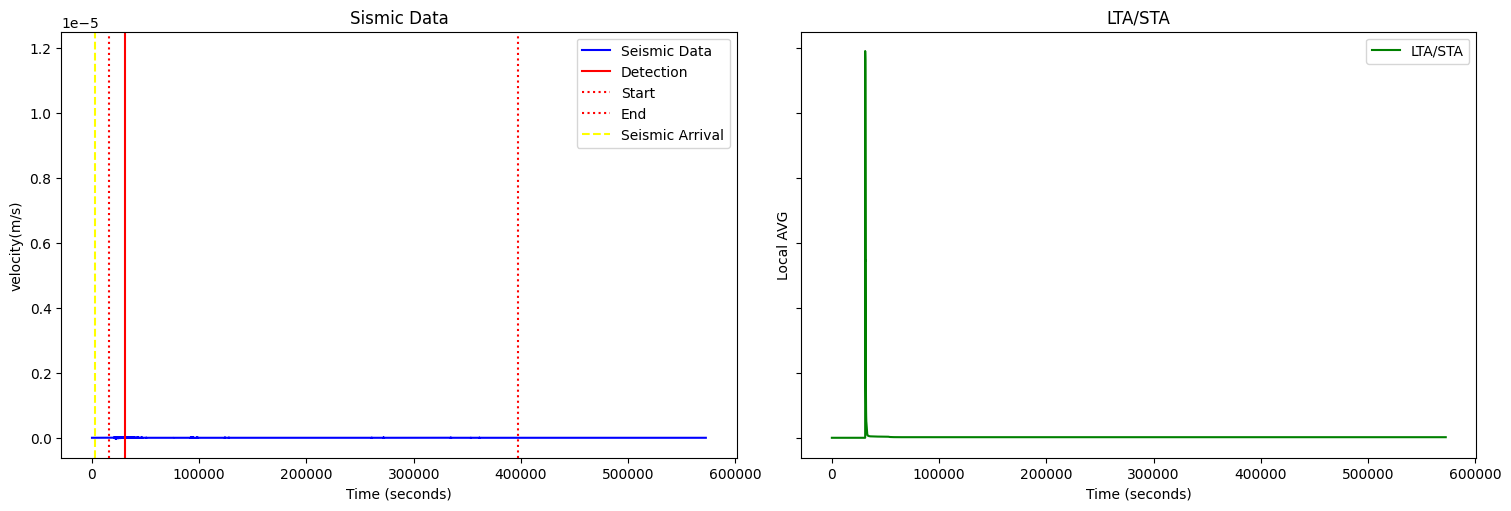

Processed: 56/76
Elapsed: 4.318160772323608 with error: 27930.0 segs.


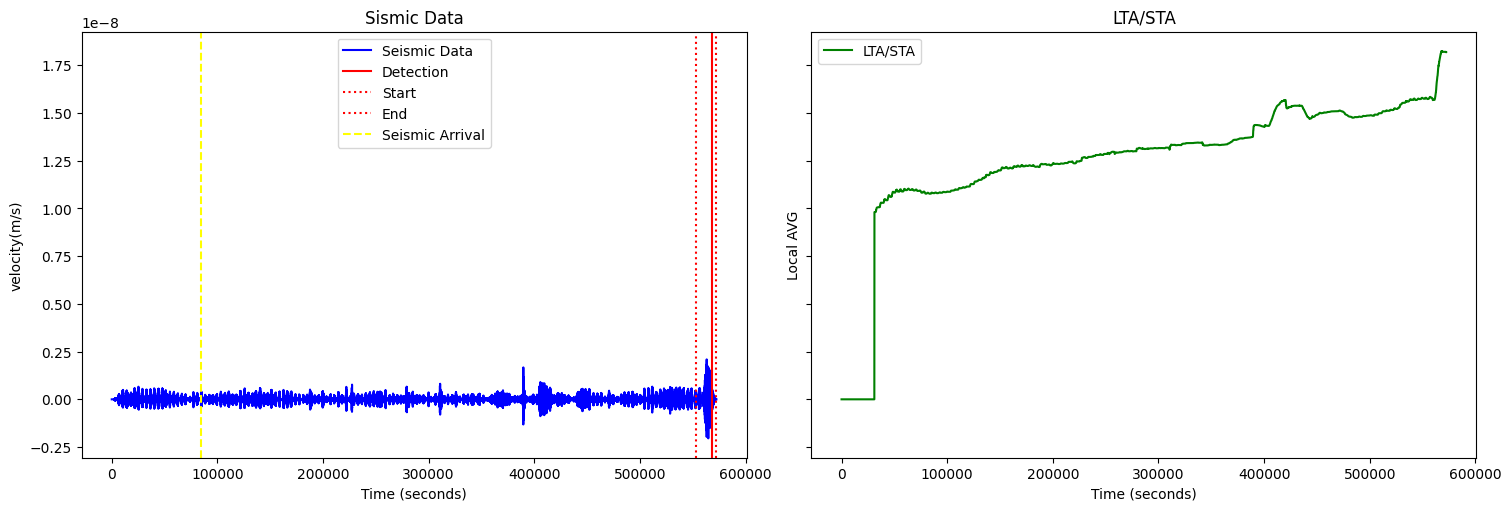

Processed: 57/76
Elapsed: 6.526262283325195 with error: 483685.0 segs.


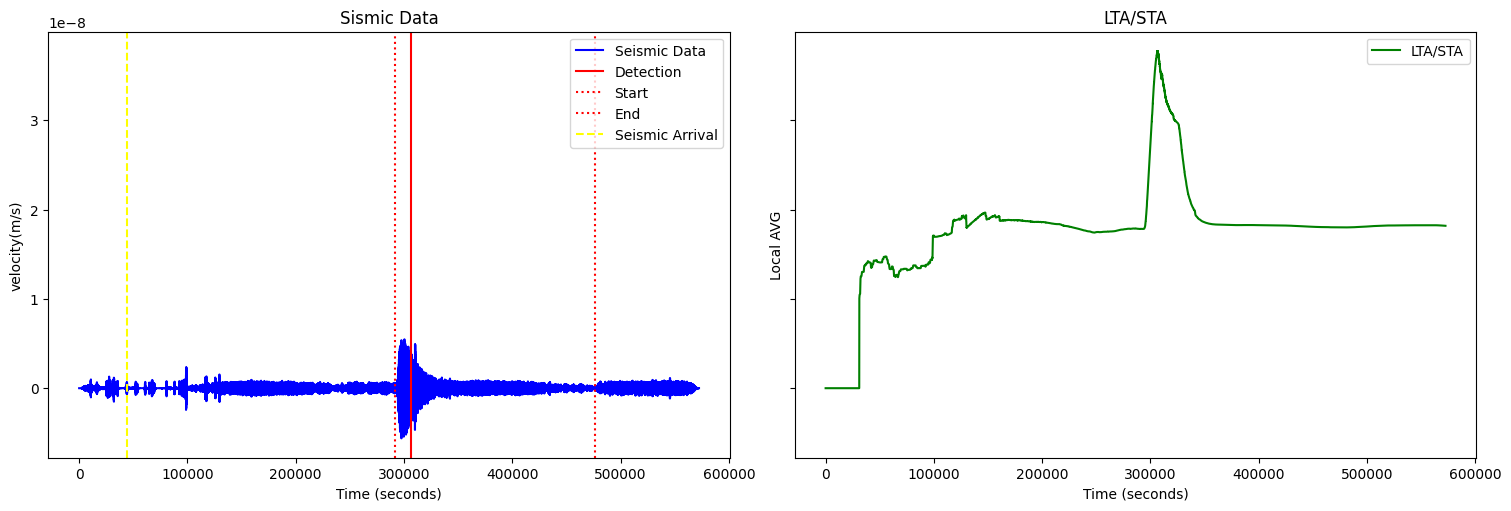

Processed: 58/76
Elapsed: 7.480924844741821 with error: 262427.0 segs.


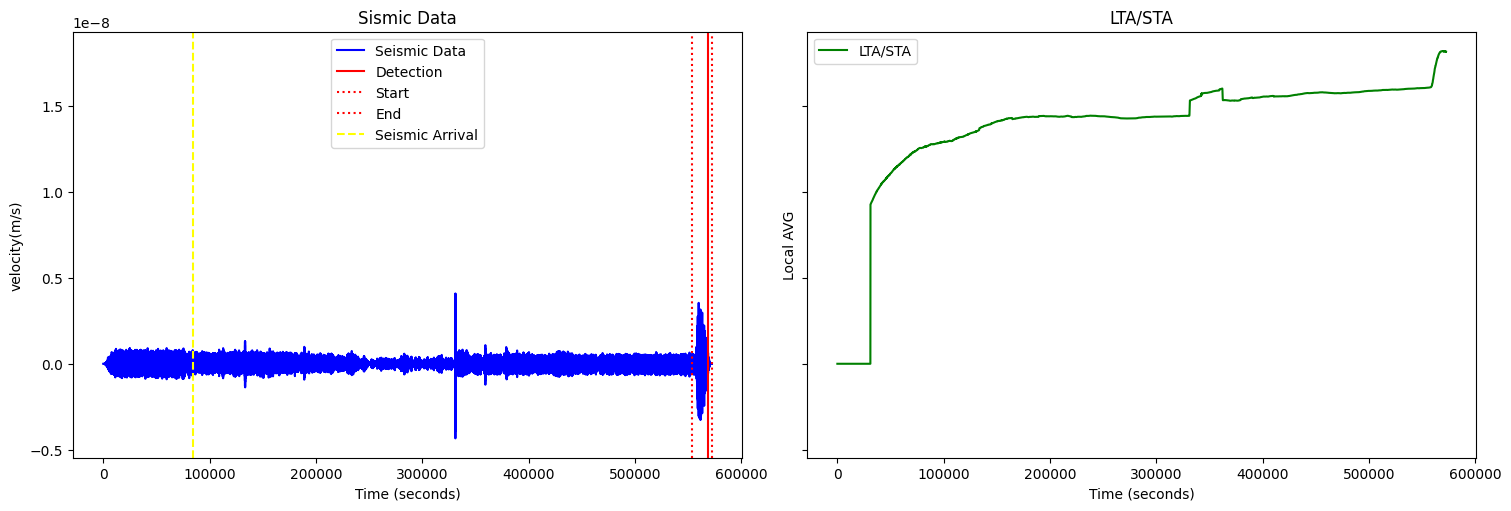

Processed: 59/76
Elapsed: 6.245871543884277 with error: 485069.0 segs.


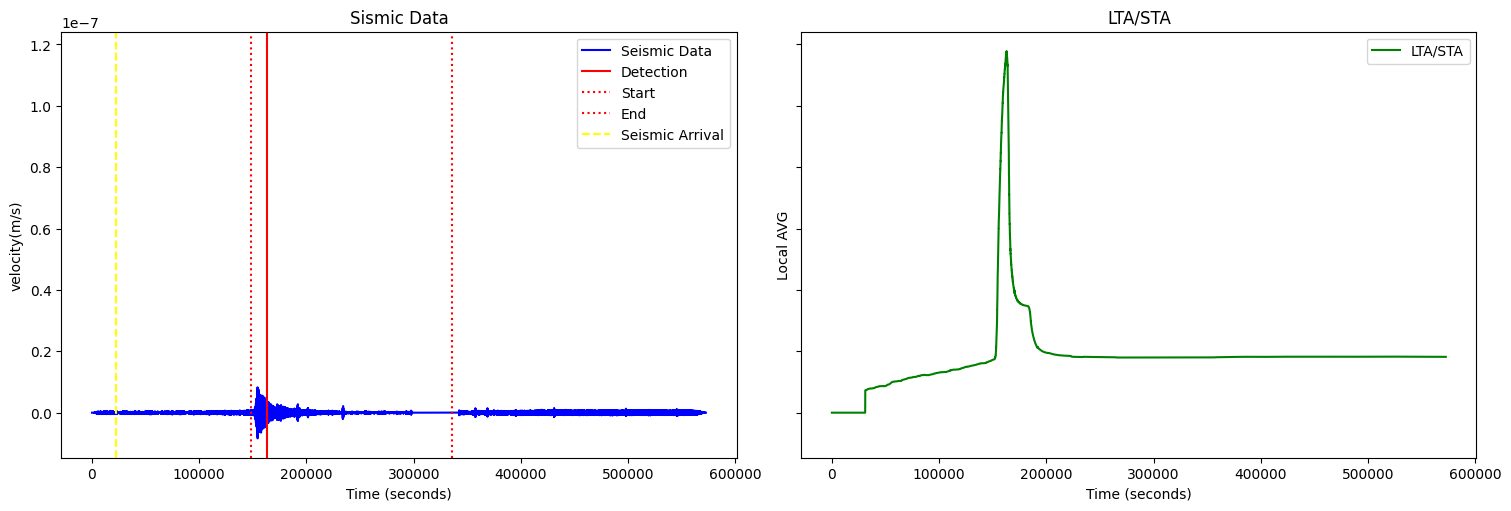

Processed: 60/76
Elapsed: 3.78369402885437 with error: 140043.0 segs.


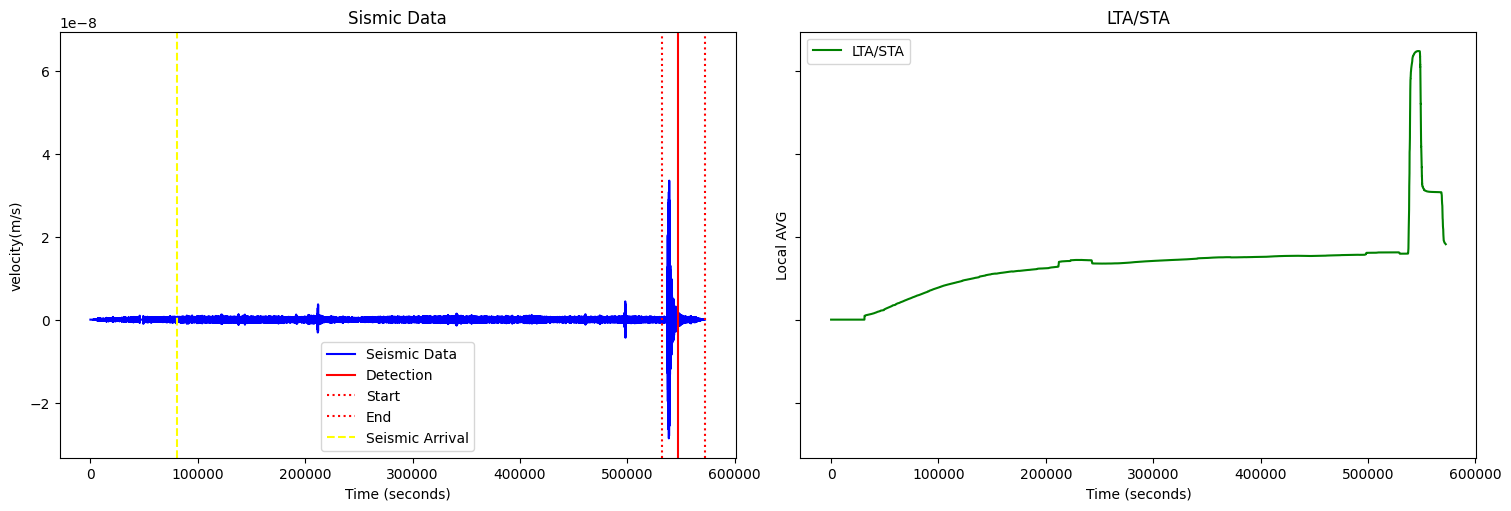

Processed: 61/76
Elapsed: 7.144842863082886 with error: 466277.0 segs.


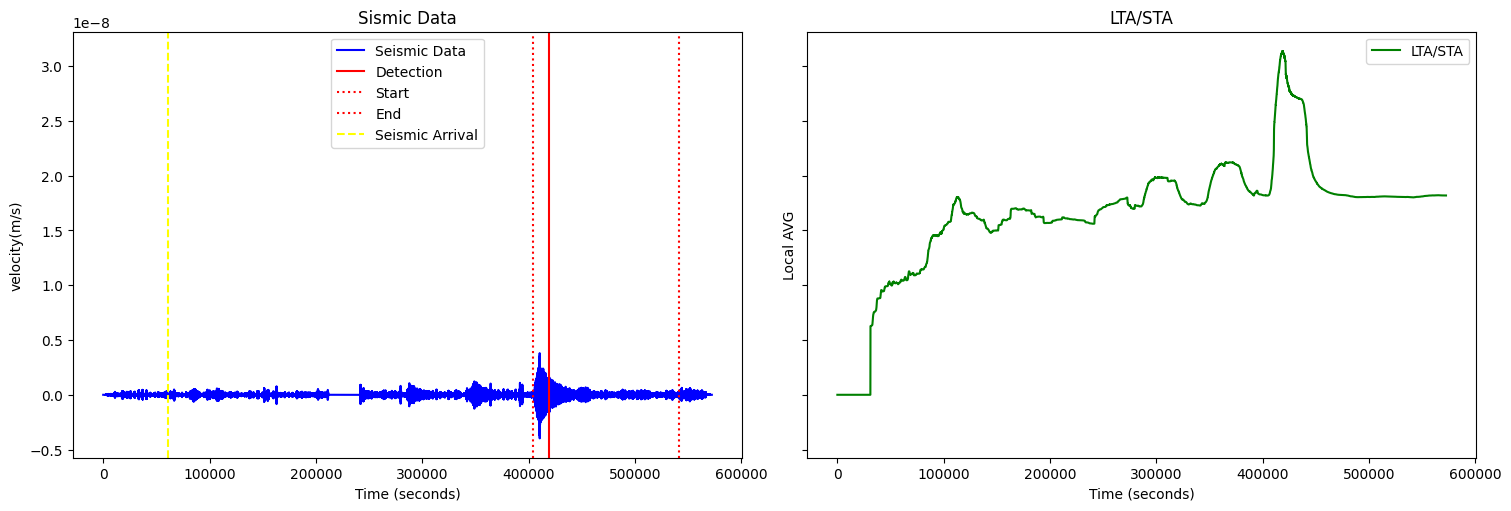

Processed: 62/76
Elapsed: 5.753415107727051 with error: 357800.0 segs.


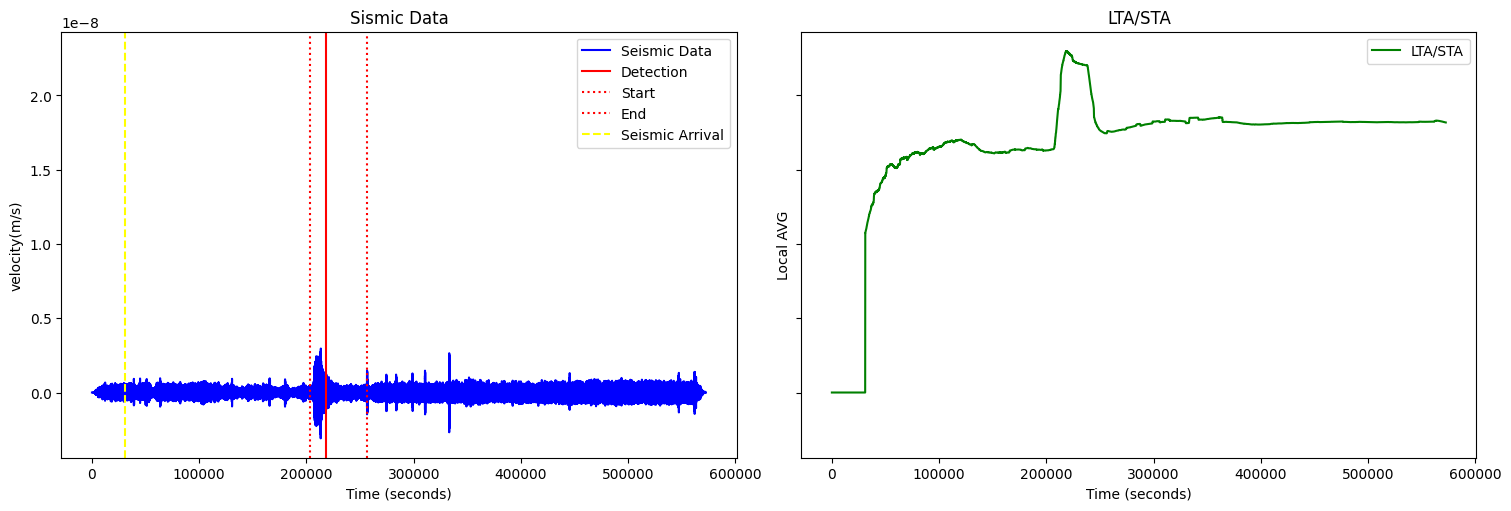

Processed: 63/76
Elapsed: 5.056396007537842 with error: 187403.0 segs.


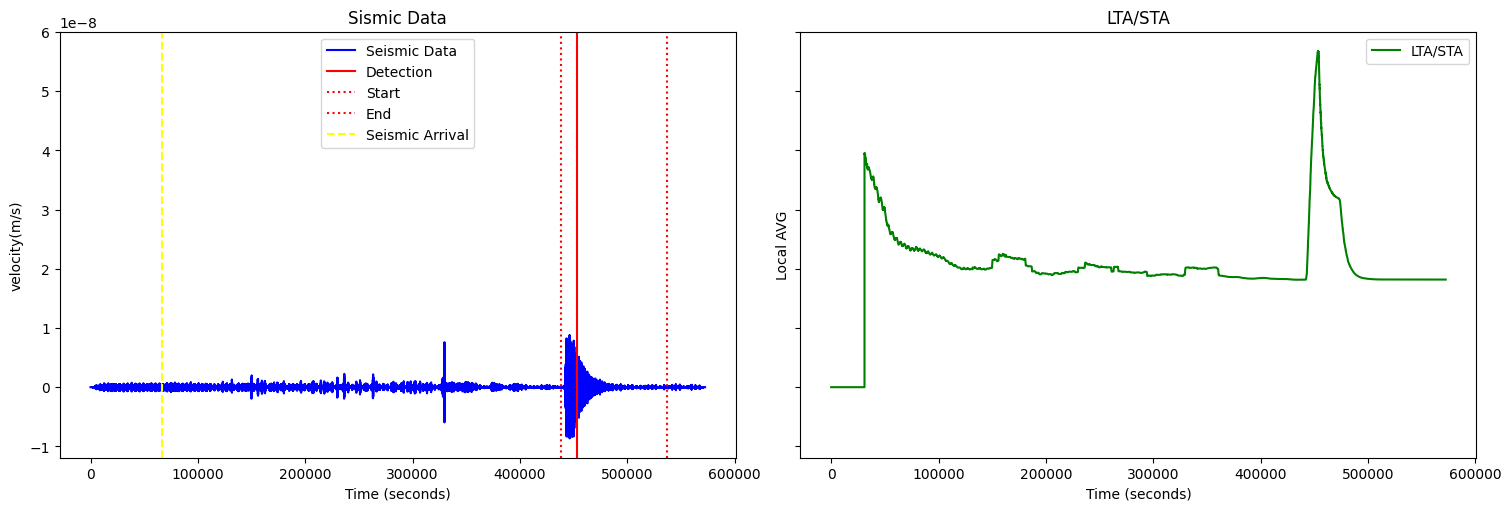

Processed: 64/76
Elapsed: 5.761580944061279 with error: 386732.0 segs.


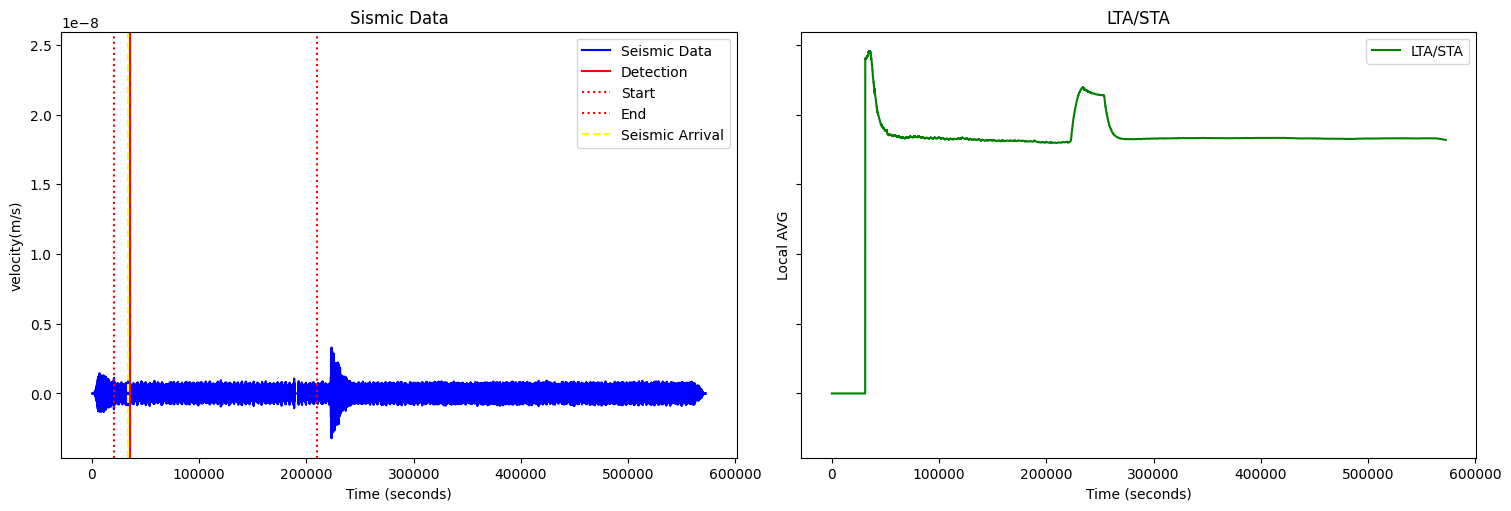

Processed: 65/76
Elapsed: 4.143870830535889 with error: 1625.0 segs.


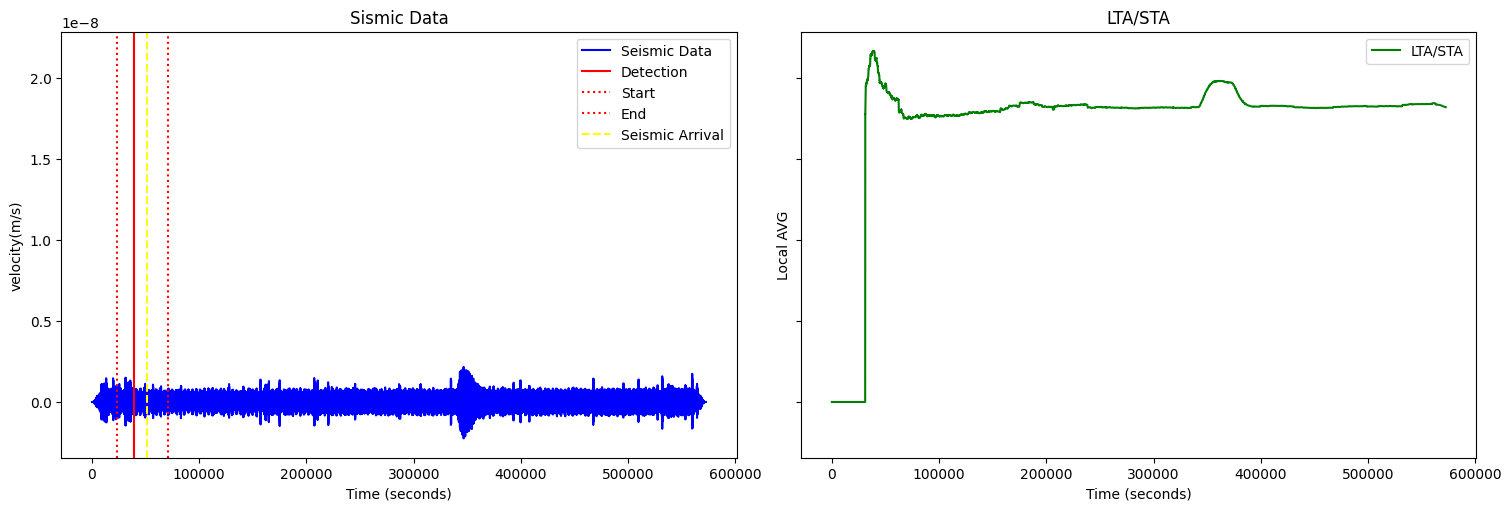

Processed: 66/76
Elapsed: 4.833706855773926 with error: 12700.0 segs.


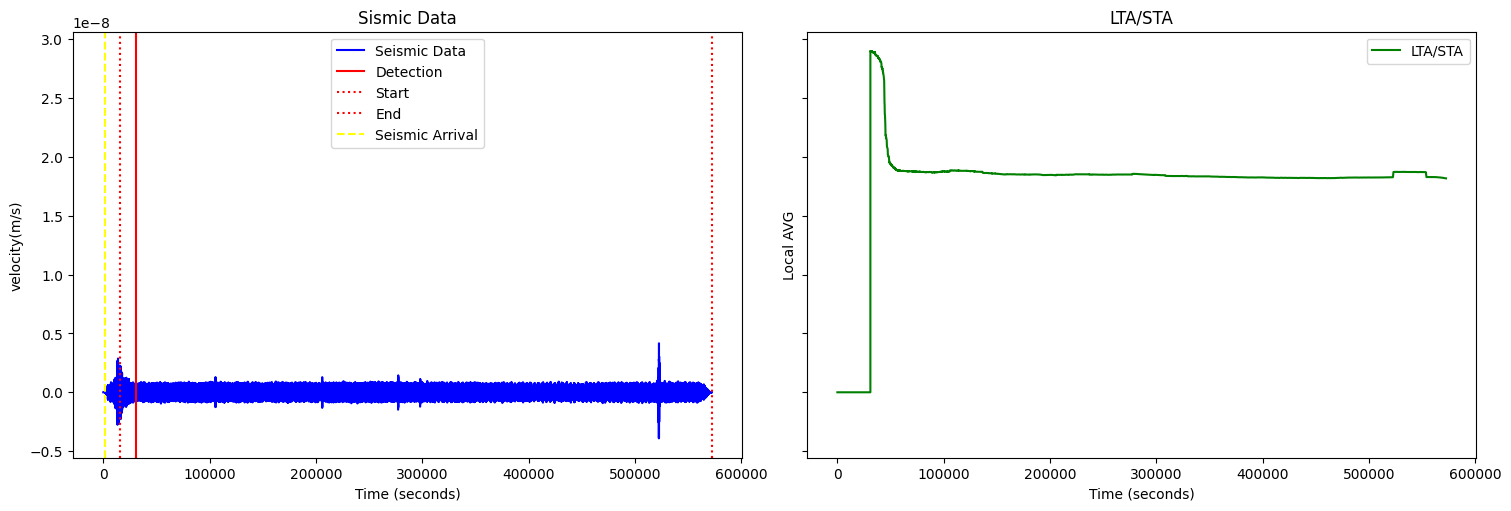

Processed: 67/76
Elapsed: 5.803218126296997 with error: 29671.0 segs.


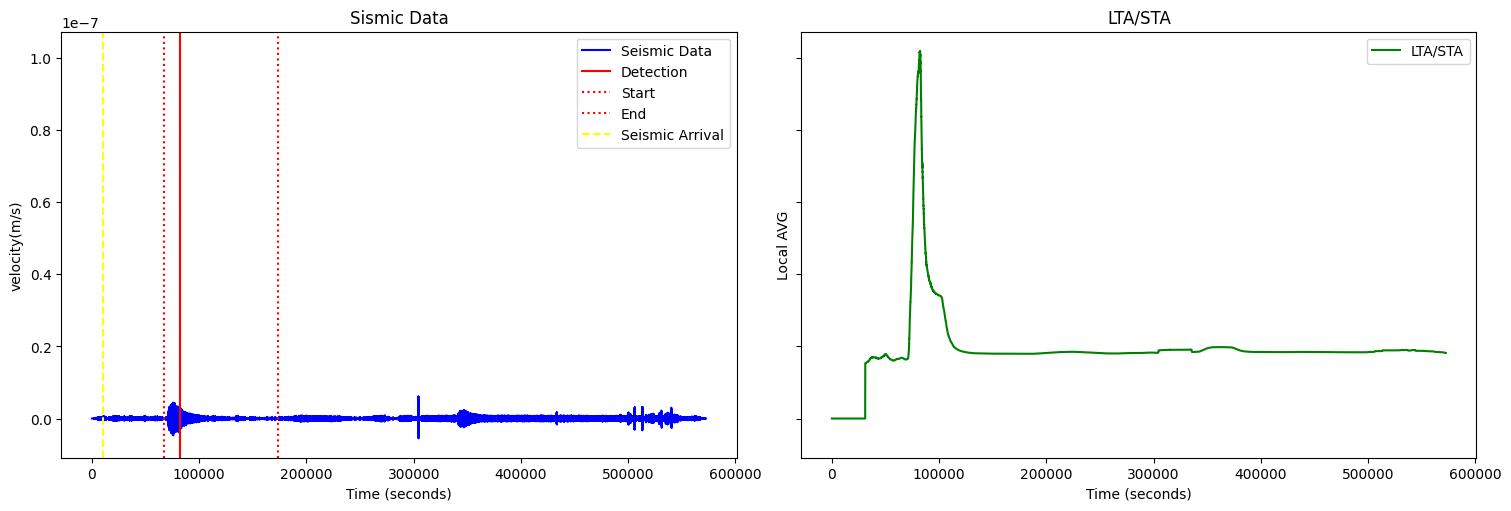

Processed: 68/76
Elapsed: 5.076347589492798 with error: 71635.0 segs.


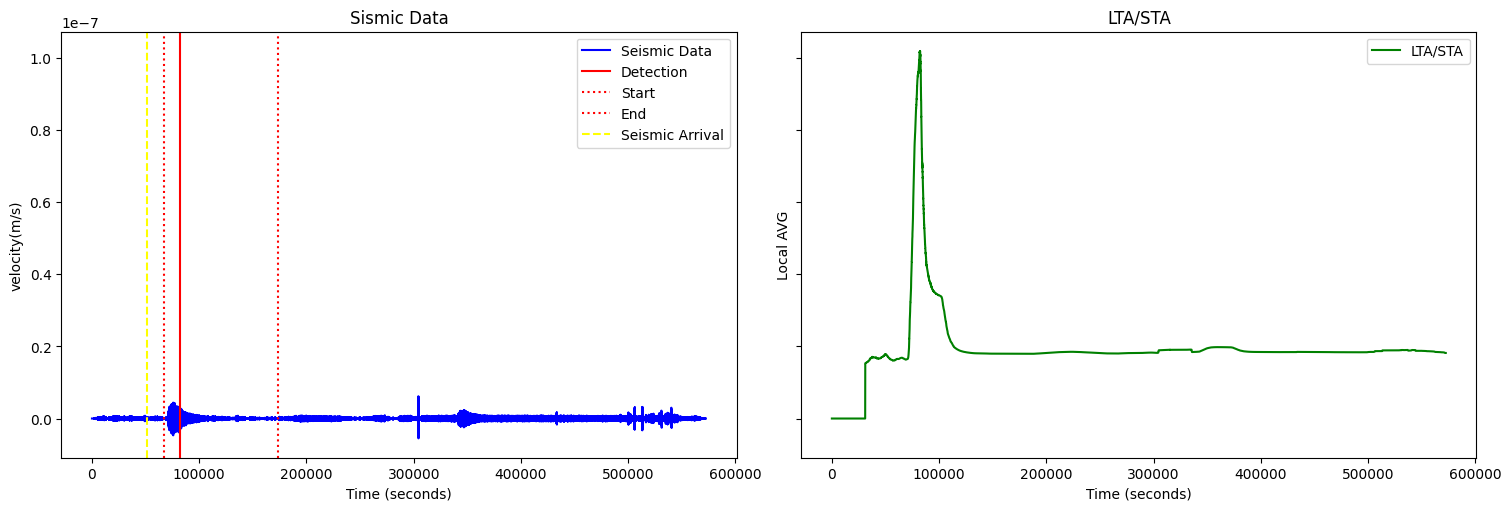

Processed: 69/76
Elapsed: 6.6814680099487305 with error: 31015.0 segs.


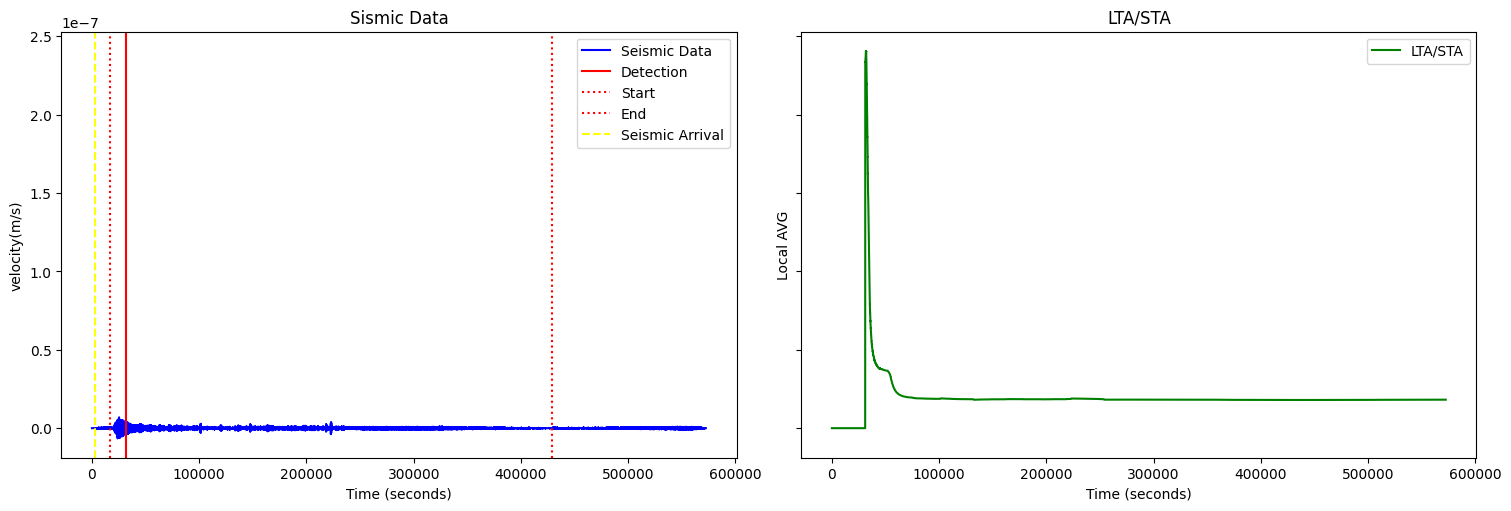

Processed: 70/76
Elapsed: 3.9649672508239746 with error: 28809.0 segs.


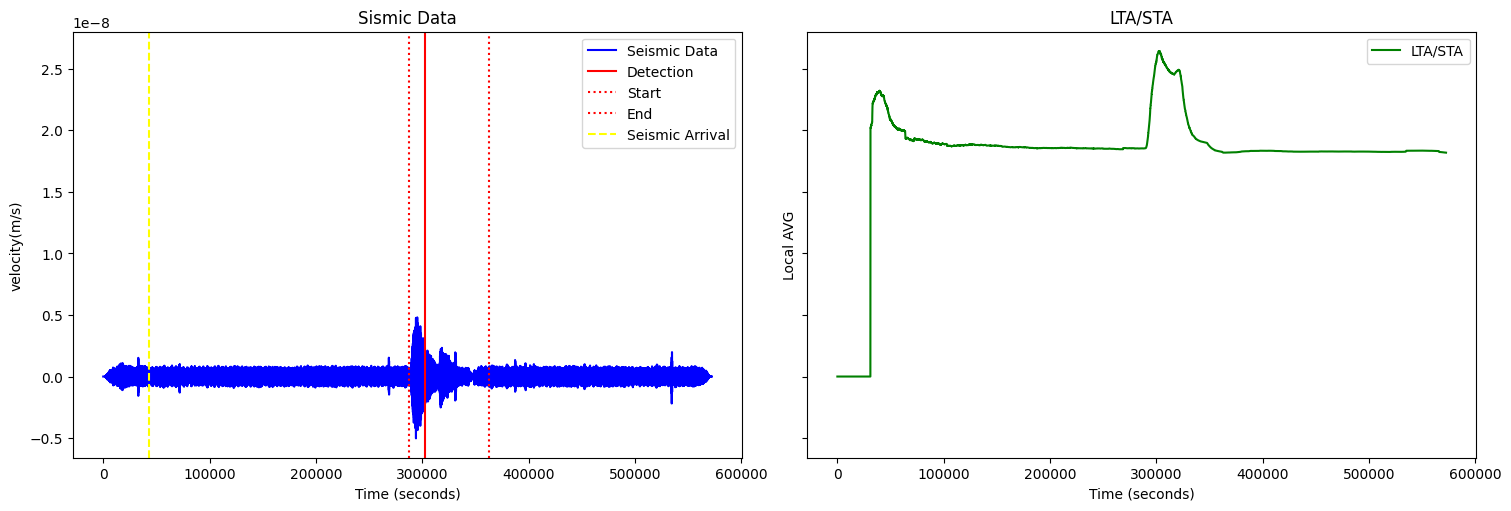

Processed: 71/76
Elapsed: 5.0975072383880615 with error: 258769.0 segs.


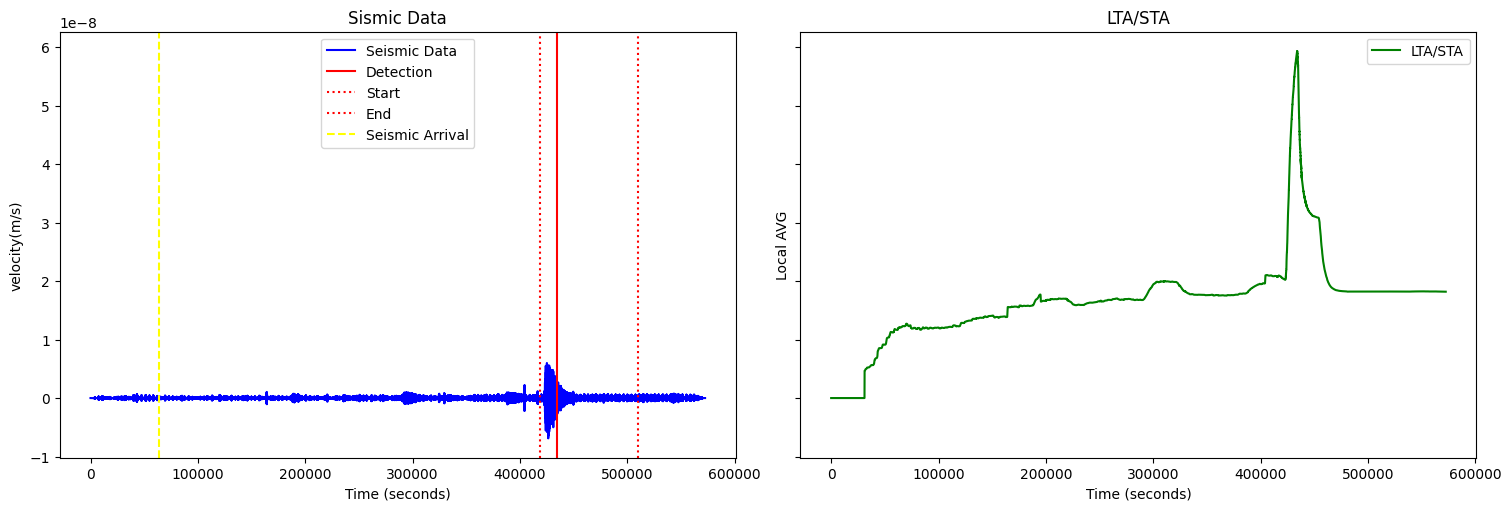

Processed: 72/76
Elapsed: 5.736431837081909 with error: 370315.0 segs.


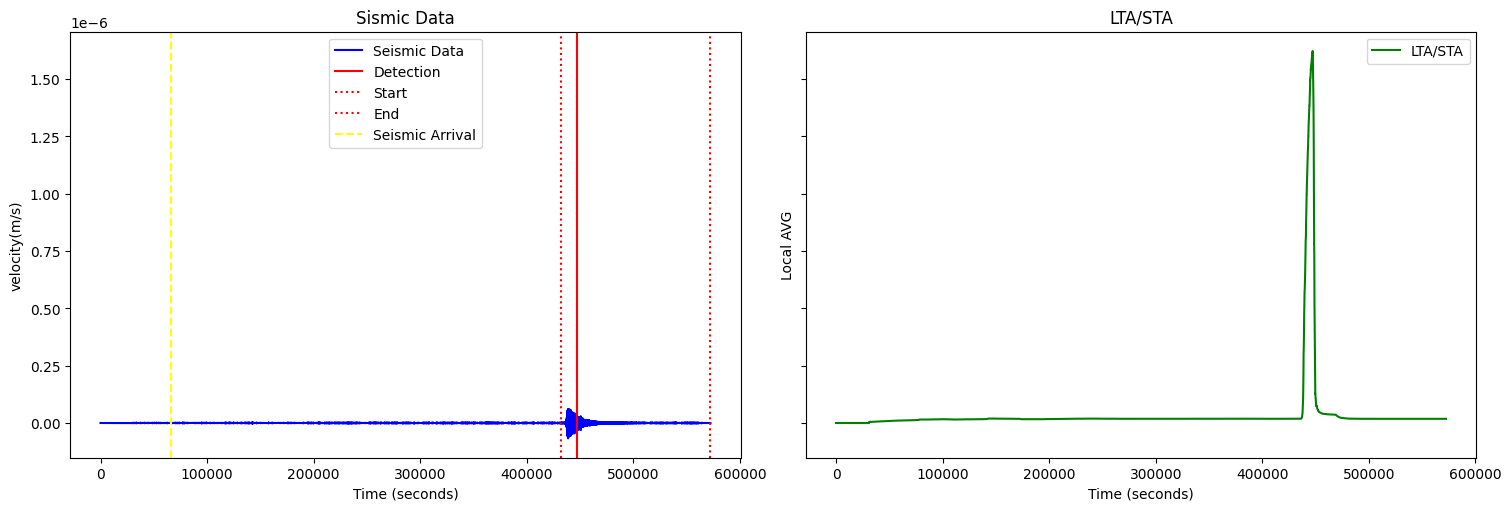

Processed: 73/76
Elapsed: 7.2231457233428955 with error: 381595.0 segs.


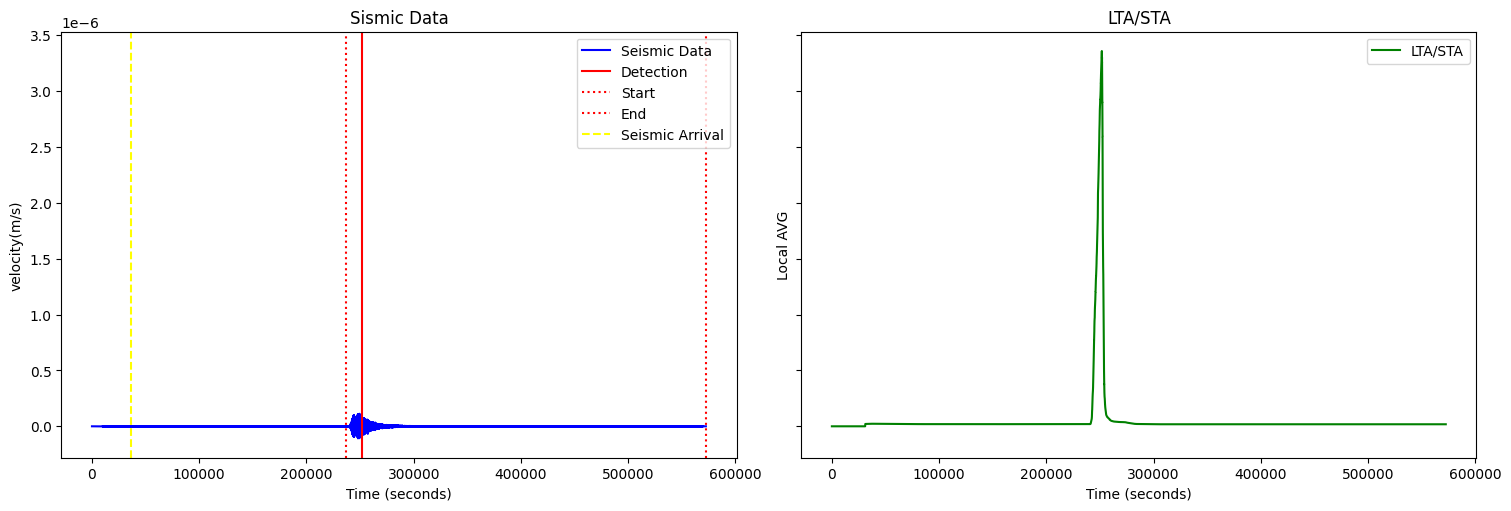

Processed: 74/76
Elapsed: 6.177176237106323 with error: 215417.0 segs.


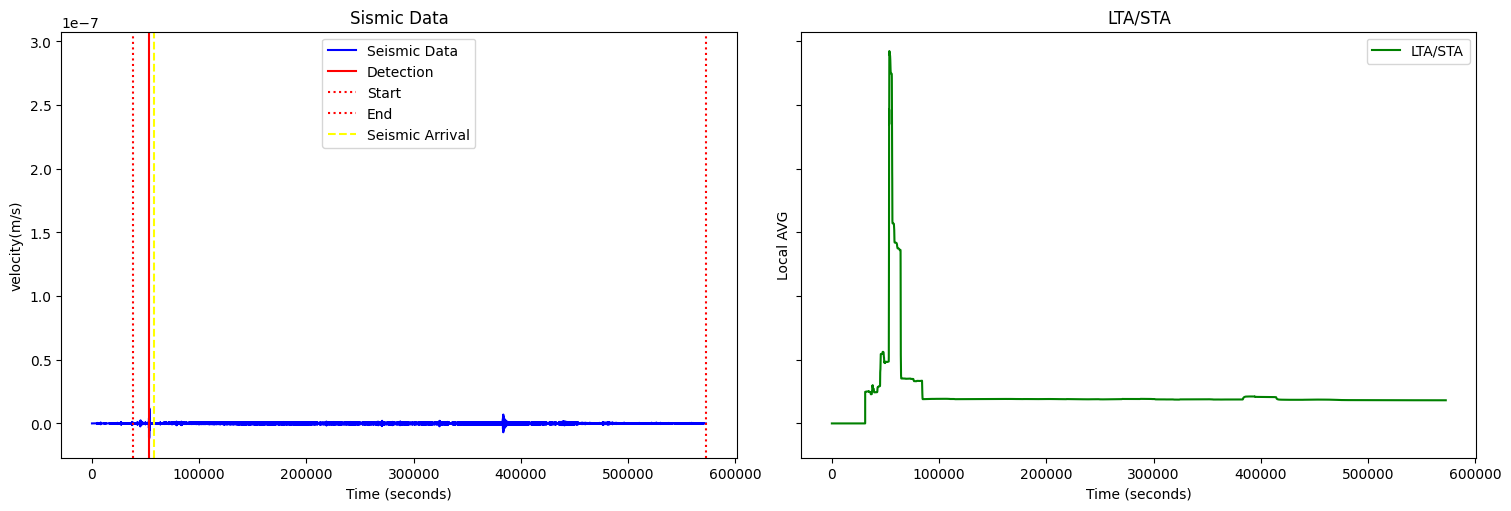

Processed: 75/76
Elapsed: 7.594083786010742 with error: 4176.0 segs.


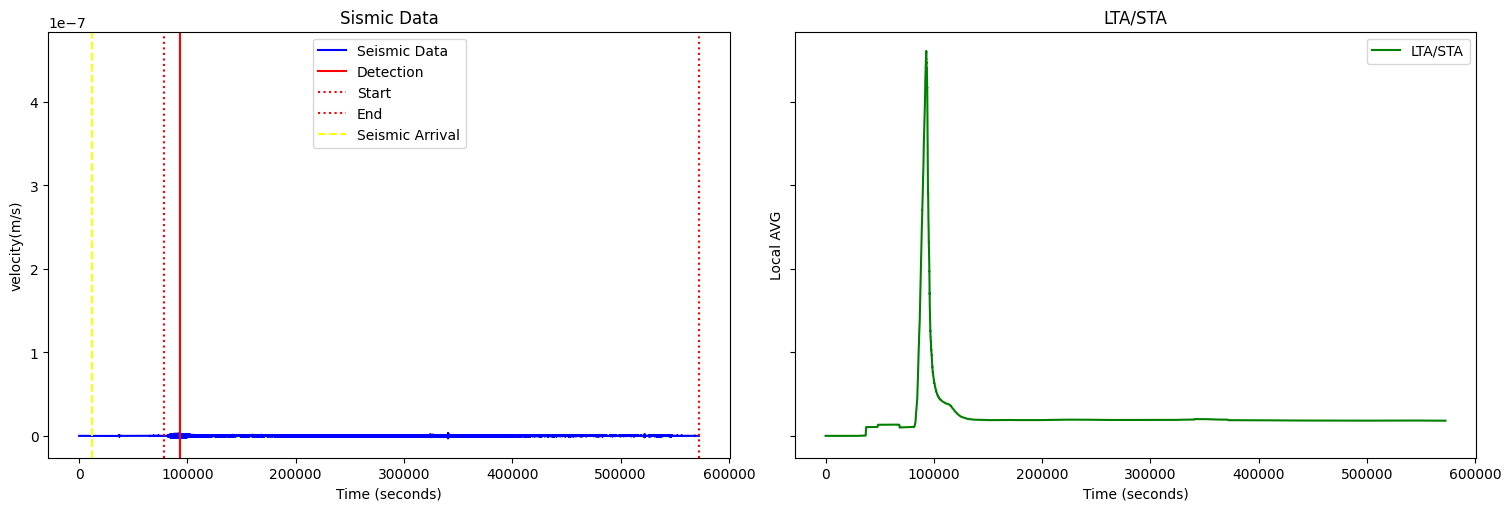

Processed: 76/76
Elapsed: 5.736518144607544 with error: 80698.0 segs.


In [25]:
params = StaLtaParams(sta_window=11000, lta_window=20000)
lunar_errors: List[float] = []

for k, df in enumerate(lunar_train_dataframes):
  now = time.time()

  arr, idx, min_, max_, error = get_arrival_time(dataset=df.get_dataframe(),
                   type_='moon',
                   params=params,
                   real_arrival_time=df.get_arrival_time(),
                   save=False,
                   plot=True)
  pred = {
      'dataset': df,
      'arrival_time': df.get_lklarrival_time(),
      'prediction': idx,
      'min_' : min_,
      'max_': max_,
      'error': error,
      "filename" : df.get_path(),
      'type': 'moon'
  }

  predictions.append(pred)

  lunar_errors.append(error)

  print(f'Processed: {k+1}/{len(lunar_train_dataframes)}')
  print(f'Elapsed: {time.time() - now} with error: {error} segs.')

  plt.show()

In [26]:
saving: List[float] = []

for pred in predictions:
  if pred['type'] == 'mars':
    continue

  init, end = pred['min_'], pred['max_']
  window: int = end - init

  percent: float = 100 - (window * 100 / 600000)

  saving.append(percent)

In [33]:
np.median(saving)

74.69266666666667

(array([ 8.,  1.,  2.,  5.,  2.,  6., 12.,  9., 15., 16.]),
 array([ 7.27166667, 16.2397    , 25.20773333, 34.17576667, 43.1438    ,
        52.11183333, 61.07986667, 70.0479    , 79.01593333, 87.98396667,
        96.952     ]),
 <BarContainer object of 10 artists>)

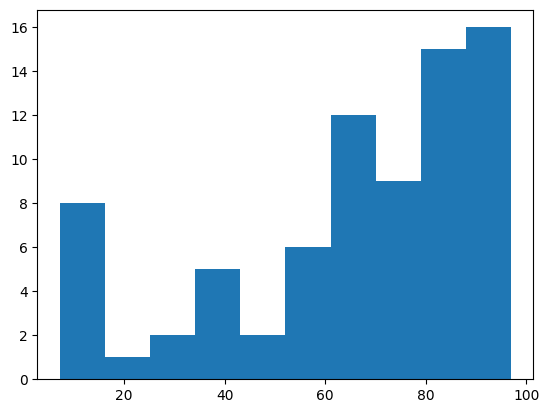

In [32]:
plt.hist(np.array(saving))

In [43]:
len(predictions)

78

In [44]:
pred_file = open('train_predictions_2.pickle', 'ab')
pickle.dump(predictions, pred_file)
pred_file.close()

### Test Dataset processing

In [ ]:
test_predictions: List[dict[str, pd.DataFrame]] = []

In [ ]:
params = StaLtaParams(sta_window=1000, lta_window=5000)

for df in mars_test_dataframes:
  now = time.time()
  arr, idx, min_, max_, error = get_arrival_time(dataset=df,
                   type_='mars',
                   params=params,
                   real_arrival_time=0,
                   save=False)

  pred = {
      'dataset': df,
      'arrival_time': 0,
      'prediction': idx,
      'min_' : min_,
      'max_': max_,
      'error': error,
      'type': 'mars'
  }

  test_predictions.append(pred)

  print(f'Time Elapsed: {time.time() - now} with error: {error} segs.')

In [ ]:
params = StaLtaParams(sta_window=1000, lta_window=5000)

for df in moon_test_dataframes:
  now = time.time()
  arr, idx, min_, max_, error = get_arrival_time(dataset=df,
                   type_='moon',
                   params=params,
                   real_arrival_time=0,
                   save=False)

  pred = {
      'dataset': df,
      'arrival_time': 0,
      'prediction': idx,
      'min_' : min_,
      'max_': max_,
      'error': error,
      'type': 'moon'
  }

  test_predictions.append(pred)

  print(f'Time Elapsed: {time.time() - now} with error: {error} segs.')